# CIS 5450 Final Project - Software Defect Prediction
---

**@author**: *Haoyi Cheng (haoyic), Yinuo Xie (yinuoxie), Chenkang Zhang (stezhang)*

**@version**: December 10th, 2023

# Introduction/Background
---

The objective of this project is to create a classification model capable of predicting the presence of defects in a C program, utilizing various features of the program as indicators. We are aiming to enhance the functionality of Integrated Development Environments (IDEs) by providing users with a tool that can proactively identify potential defects, thereby promoting code accuracy and reducing debugging time. We hope that the outcome of this project would augment the code development process, making it a valuable endeavor in the realm of software engineering.

Specifically speaking, we will be diving into the prediction of possible software defect in C programs based on various software metrics related to the complexity and characteristics associated with programs. The dataset used for this project is [Binary Classification with a Software Defects Dataset](https://www.kaggle.com/competitions/playground-series-s3e23/data) available on Kaggle. It is a synthetic dataset generated from a deep learning model that was trained on the original [Software Defect Dataset](https://www.kaggle.com/datasets/semustafacevik/software-defect-prediction) released on December 2, 2004. Each row in the dataset represents a C program, and the values in each column provide different metrics and characteristics associated with that program.

---

The dataset contains the following features:

**Target Variable:**
- **defects**: a binary target which is represented as a boolean variable. *True*: There are defects found in the C program; *False*: There is no defects found in the C program.

**Input Features:**
- **'id'**: Unique identifier for each C program (numeric).
- **'loc'**: McCabe's line count of code (numeric). It is the total number of lines of code in a software module.
- '**v(g)'**: McCabe "cyclomatic complexity" (numeric). It is a quantitative measure of the number of linearly independent paths through a program's source code.
- **'ev(g)'**: McCabe "essential complexity" (numeric). It is an extension or variation of cyclomatic complexity.
- **'iv(g)**': McCabe "design complexity" (numeric). It is another variation of cyclomatic complexity similar to ev(g).
- **'n'**: Halstead total operators + operands (numeric). It is the total number of operators and operands in the code.
- **'v'**: Halstead "volume" (numeric). It is a measure of the size of the software derived from the number of operators and operands.
- **'l'**: Halstead "program length" (numeric). It represents an estimation of the implementation length.
- **'d'**: Halstead "difficulty" (numeric). It is a measure of program difficulty, calculated as a function of the number of unique operators and operands.
- **'i'**: Halstead "intelligence" (numeric). It is a measure of the algorithm's intelligence.
- **'e'**: Halstead "effort" (numeric). It represents the effort to write the code, computed using other Halstead metrics.
- **'b'**: Halstead "bug" (numeric).
- **'t'**: Halstead's time estimator (numeric).
- **'lOCode'**: Halstead's line count of code (numeric). It represents lines of code without comments.
- **'lOComment'**: Halstead's count of lines of comments (numeric). It represents lines of comments in the code.
- **'lOBlank'**: Halstead's count of blank lines (numeric). It represents blank lines in the code.
- **'locCodeAndComment'**: Halstead's line count of code and comments (numeric). It represents lines of code that include both code and comments.
- **'uniq_Op'**: Unique operators (numeric). It represents unique operators in the code.
- **'uniq_Opnd'**: Unique operands (numeric). It represents unique operands in the code.
- **'total_Op'**: Total operators (numeric). It is the total number of operators.
- **'total_Opnd'**: Total operands (numeric). It is the total number of operands.
- **'branchCount'**: Percentage of the flow graph (numeric).

**Note:** The McCabe and Halstead measures are two metrics that characterize the features of code. More details about the corresponding caculation/description can be read at [here](https://www.kaggle.com/datasets/semustafacevik/software-defect-prediction/data?select=about+JM1+Dataset.txt).


Let's install and import some necessary libraries
---

In [1]:
!pip install scipy==1.8.1
!pip install Cython==0.29.35

!sudo apt-get install swig -y
!pip install pipelineprofiler

!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 11.8 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
jax 0.4.20 requires scipy>=1.9, but you have scipy 1.8.1 which is incompatible.
jaxlib 0.4.20+cuda11.cudnn86 requires scipy>=1.9, but you have scipy 1.8.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.4 MB/s eta 0:00:00
  Attempting uninstall: Cython
    Found existing installation: Cython 3.0.6
    Uninstalling Cython-3.0.6:
    

In [2]:
import shap
import random
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

seed = 42 # random seed through the entire project to ensure that our results are reproducible
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

# Data Loading

---
For quick access to our dataset, we have pre-downloaded it from Kaggle and store the file into the Google Drive.

- There are in total of two files for this dataset. One is the training dataset and another one is the test dataset.

In [3]:
#@title Data Loading via Google Drive
from google.colab import drive
drive.mount('/content/drive')

trainpath = "/content/drive/MyDrive/CIS545/ProjectCode/train.csv"
testpath = "/content/drive/MyDrive/CIS545/ProjectCode/test.csv"

train = pd.read_csv(trainpath, low_memory=False)
test = pd.read_csv(testpath, low_memory=False)

Mounted at /content/drive


In [ ]:
# To view the size of training dataset
print(train.shape)
train.head()

(101763, 23)


id   loc  v(g)  ev(g)  iv(g)     n       v     l      d      i        e  \
0   0  22.0   3.0    1.0    2.0  60.0  278.63  0.06  19.56  14.25  5448.79   
1   1  14.0   2.0    1.0    2.0  32.0  151.27  0.14   7.00  21.11   936.71   
2   2  11.0   2.0    1.0    2.0  45.0  197.65  0.11   8.05  22.76  1754.01   
3   3   8.0   1.0    1.0    1.0  23.0   94.01  0.19   5.25  17.86   473.66   
4   4  11.0   2.0    1.0    2.0  17.0   60.94  0.18   5.63  12.44   365.67   

      b       t  lOCode  lOComment  lOBlank  locCodeAndComment  uniq_Op  \
0  0.09  302.71      17          1        1                  0     16.0   
1  0.05   52.04      11          0        1                  0     11.0   
2  0.07   97.45       8          0        1                  0     12.0   
3  0.03   26.31       4          0        2                  0      8.0   
4  0.02   20.31       7          0        2                  0      7.0   

   uniq_Opnd  total_Op  total_Opnd  branchCount  defects  
0        9.0      38.0        22.0          5.0    False  
1       11.0      18.0        14.0          3.0    False  
2       11.0      28.0        17.0          3.0    False  
3        6.0      16.0         7.0          1.0     True  
4        6.0      10.0        10.0          3.0    False

In [ ]:
# To view the size of test dataset
print(test.shape)
test.head()

(67842, 22)


id    loc  v(g)  ev(g)  iv(g)      n        v     l      d      i  \
0  101763   33.0   5.0    1.0    4.0  144.0   824.82  0.04  26.96  30.05   
1  101764   27.0   8.0    8.0    2.0  125.0   646.24  0.04  22.82  27.22   
2  101765  130.0  11.0    7.0   10.0  545.0  3831.40  0.02  48.15  66.17   
3  101766   65.0   7.0    1.0    7.0  156.0   855.71  0.06  17.23  49.89   
4  101767   22.0   3.0    1.0    3.0   52.0   238.42  0.10   9.60  26.70   

           e     b        t  lOCode  lOComment  lOBlank  locCodeAndComment  \
0   22636.74  0.27  1257.60      30          0        3                  0   
1   14482.46  0.22   804.58      23          0        2                  0   
2  116160.08  1.28  6453.34      99          9       17                  1   
3   16135.47  0.29   896.42      45          8       10                  0   
4    2624.49  0.08   145.80      16          0        4                  0   

   uniq_Op  uniq_Opnd  total_Op  total_Opnd  branchCount  
0     21.0       23.0      87.0        57.0          9.0  
1     18.0       19.0      70.0        49.0         15.0  
2     26.0       53.0     333.0       244.0         21.0  
3     15.0       26.0      88.0        60.0         13.0  
4     12.0       15.0      30.0        24.0          5.0

For the purpose of modeling (building the final model) as well as meeting the basic requirement of this project, we will only apply our analyses on the training set of this dataset since there is no target variable in the test set and we see that (Rows: 101763, Features: 22) already meets the dataset size requirment for the project.

In [ ]:
# Let's get ready for the next step
software_defect = train

# Analyzing Dataset & Data Preprocessing

---

Let's first get some sense of our dataset! We want to make sure our data meet the above descriptions as well as being preprocessed for analyses.

In [ ]:
# Check for missing values
missing_values = software_defect.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 id                   0
loc                  0
v(g)                 0
ev(g)                0
iv(g)                0
n                    0
v                    0
l                    0
d                    0
i                    0
e                    0
b                    0
t                    0
lOCode               0
lOComment            0
lOBlank              0
locCodeAndComment    0
uniq_Op              0
uniq_Opnd            0
total_Op             0
total_Opnd           0
branchCount          0
defects              0
dtype: int64


In [ ]:
# Check for duplicates
duplicates = software_defect.duplicated().sum()
print("Number of duplicates:", duplicates)

Number of duplicates: 0


In [ ]:
# Check for unique id values
unique_ids = software_defect['id'].nunique()
print("Number of unique id values:", unique_ids)
print("Number of rows in the dataset:", len(software_defect))
assert unique_ids == len(software_defect) # assertion here to make sure each ids are unique

Number of unique id values: 101763
Number of rows in the dataset: 101763


In [ ]:
# Check in for whether the target variable is binary
target = software_defect['defects'].unique()
print("Target variable values:", target)

Target variable values: [False  True]


In [ ]:
# Check in for the data types of the columns to see whether they meet the above criteria
print(software_defect.dtypes)

id                     int64
loc                  float64
v(g)                 float64
ev(g)                float64
iv(g)                float64
n                    float64
v                    float64
l                    float64
d                    float64
i                    float64
e                    float64
b                    float64
t                    float64
lOCode                 int64
lOComment              int64
lOBlank                int64
locCodeAndComment      int64
uniq_Op              float64
uniq_Opnd            float64
total_Op             float64
total_Opnd           float64
branchCount          float64
defects                 bool
dtype: object


In [ ]:
# Finally, let's get a summary of the data excluding the id and defects columns
software_defect.iloc[:, 1:-1].describe()

loc           v(g)          ev(g)          iv(g)  \
count  101763.000000  101763.000000  101763.000000  101763.000000   
mean       37.347160       5.492684       2.845022       3.498826   
std        54.600401       7.900855       4.631262       5.534541   
min         1.000000       1.000000       1.000000       1.000000   
25%        13.000000       2.000000       1.000000       1.000000   
50%        22.000000       3.000000       1.000000       2.000000   
75%        42.000000       6.000000       3.000000       4.000000   
max      3442.000000     404.000000     165.000000     402.000000   

                   n              v              l              d  \
count  101763.000000  101763.000000  101763.000000  101763.000000   
mean       96.655995     538.280956       0.111634      13.681881   
std       171.147191    1270.791601       0.100096      14.121306   
min         0.000000       0.000000       0.000000       0.000000   
25%        25.000000      97.670000       0.050000       5.600000   
50%        51.000000     232.790000       0.090000       9.820000   
75%       111.000000     560.250000       0.150000      18.000000   
max      8441.000000   80843.080000       1.000000     418.200000   

                   i             e              b              t  \
count  101763.000000  1.017630e+05  101763.000000  101763.000000   
mean       27.573007  2.085359e+04       0.179164    1141.357982   
std        22.856742  1.905714e+05       0.421844    9862.795472   
min         0.000000  0.000000e+00       0.000000       0.000000   
25%        15.560000  5.647300e+02       0.030000      31.380000   
50%        23.360000  2.256230e+03       0.080000     125.400000   
75%        34.340000  1.019324e+04       0.190000     565.920000   
max       569.780000  1.684662e+07      26.950000  935923.390000   

              lOCode      lOComment        lOBlank  locCodeAndComment  \
count  101763.000000  101763.000000  101763.000000      101763.000000   
mean       22.802453       1.773945       3.979865           0.196604   
std        38.541010       5.902412       6.382358           0.998906   
min         0.000000       0.000000       0.000000           0.000000   
25%         7.000000       0.000000       1.000000           0.000000   
50%        14.000000       0.000000       2.000000           0.000000   
75%        26.000000       1.000000       5.000000           0.000000   
max      2824.000000     344.000000     219.000000          43.000000   

             uniq_Op      uniq_Opnd       total_Op     total_Opnd  \
count  101763.000000  101763.000000  101763.000000  101763.000000   
mean       11.896131      15.596671      57.628116      39.249698   
std         6.749549      18.064261     104.537660      71.692309   
min         0.000000       0.000000       0.000000       0.000000   
25%         8.000000       7.000000      15.000000      10.000000   
50%        11.000000      12.000000      30.000000      20.000000   
75%        16.000000      20.000000      66.000000      45.000000   
max       410.000000    1026.000000    5420.000000    3021.000000   

         branchCount  
count  101763.000000  
mean        9.839549  
std        14.412769  
min         1.000000  
25%         3.000000  
50%         5.000000  
75%        11.000000  
max       503.000000

In [ ]:
# Convert the boolean target variable to 0 and 1
software_defect['defects'] = software_defect['defects'].astype(int)
software_defect.head()

id   loc  v(g)  ev(g)  iv(g)     n       v     l      d      i        e  \
0   0  22.0   3.0    1.0    2.0  60.0  278.63  0.06  19.56  14.25  5448.79   
1   1  14.0   2.0    1.0    2.0  32.0  151.27  0.14   7.00  21.11   936.71   
2   2  11.0   2.0    1.0    2.0  45.0  197.65  0.11   8.05  22.76  1754.01   
3   3   8.0   1.0    1.0    1.0  23.0   94.01  0.19   5.25  17.86   473.66   
4   4  11.0   2.0    1.0    2.0  17.0   60.94  0.18   5.63  12.44   365.67   

      b       t  lOCode  lOComment  lOBlank  locCodeAndComment  uniq_Op  \
0  0.09  302.71      17          1        1                  0     16.0   
1  0.05   52.04      11          0        1                  0     11.0   
2  0.07   97.45       8          0        1                  0     12.0   
3  0.03   26.31       4          0        2                  0      8.0   
4  0.02   20.31       7          0        2                  0      7.0   

   uniq_Opnd  total_Op  total_Opnd  branchCount  defects  
0        9.0      38.0        22.0          5.0        0  
1       11.0      18.0        14.0          3.0        0  
2       11.0      28.0        17.0          3.0        0  
3        6.0      16.0         7.0          1.0        1  
4        6.0      10.0        10.0          3.0        0

Great! Our dataset looks alright now. There are no missing/duplicated values and all the features are numeric. However, we can see that there are many features appear in the dataset. We would like to see if there are any features that are correlated with each other and we might want to do feature selection to reduce the dimensionality of our dataset. Moreover, from the basic statistics of the dataset, we see that features appear to be in different scale. We might consider apply feature scaling for the purpose of modeling. But for now, let's move on to the next step, which is EDAs.

# Exploratory Data Analysis (EDA)

---

This section involves gaining insights and understanding the characteristics of the dataset through visualizations and statistical summaries. The goal is to identify patterns and trends in the data that can be used to inform the machine learning models.

Distribution of the Defects
---

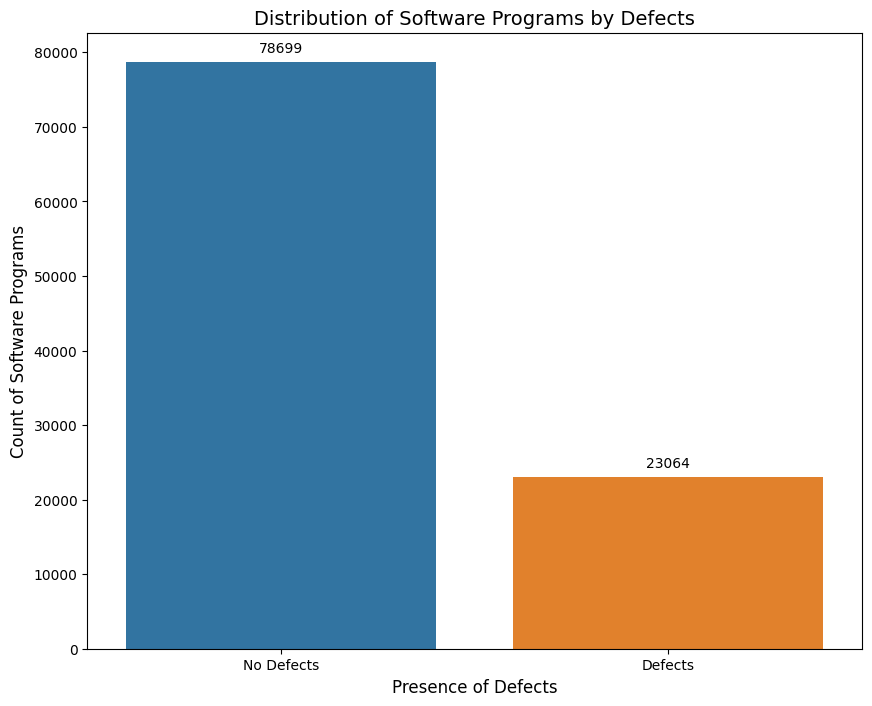

In [ ]:
#@title Plot the distribution of target variable to see the imbalance
plt.figure(figsize=(10, 8))

ax = sns.countplot(x='defects', data=software_defect)
plt.title('Distribution of Software Programs by Defects', fontsize=14)
plt.xlabel('Presence of Defects', fontsize=12)
plt.ylabel('Count of Software Programs', fontsize=12)
plt.xticks([0, 1], ['No Defects', 'Defects'])

# Add annotations on top of the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.show()

<Figure size 1000x800 with 0 Axes>

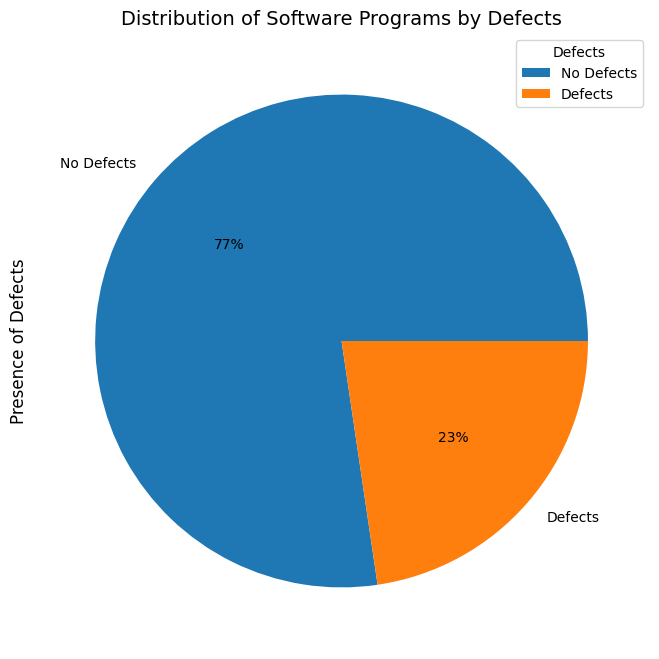

In [ ]:
#@title Plot the pie chart of target variable to see the imbalance
plt.figure(figsize=(10, 8))
label_mapping = {0: 'No Defects', 1: 'Defects'}

plt.figure(figsize=(10, 8))
software_defect['defects'].value_counts().plot(kind='pie', autopct='%1.0f%%', labels=['No Defects', 'Defects'])
plt.title('Distribution of Software Programs by Defects', fontsize=14)
plt.ylabel('Presence of Defects', fontsize=12)

plt.legend(labels=[label_mapping[label] for label in software_defect['defects'].value_counts().index], title='Defects', loc='upper right')

plt.show()

As from both histogram and pie chart plots, we see that our dataset is highly imbalanced. There are 77% of software programs are labeled with no defects while only 23% of software programs are labeled with defects. This will introduce problems when we train and test our model. The skewed distribution of defective and non-defective programs will result in less capable and generalized model because even if the model predicts all programs as no defects will still have greater than 50% accuracy (with potential a lot of false negative, which is very detrimental in real-world situation). Therefore, we would consider **F1 score and AUC/ROC** as the main metrics for training and testing our model. Futhermore, we might also want to do data augmentation on the dataset so that we can make our dataset more balanced.

Distribution of Input Features
---

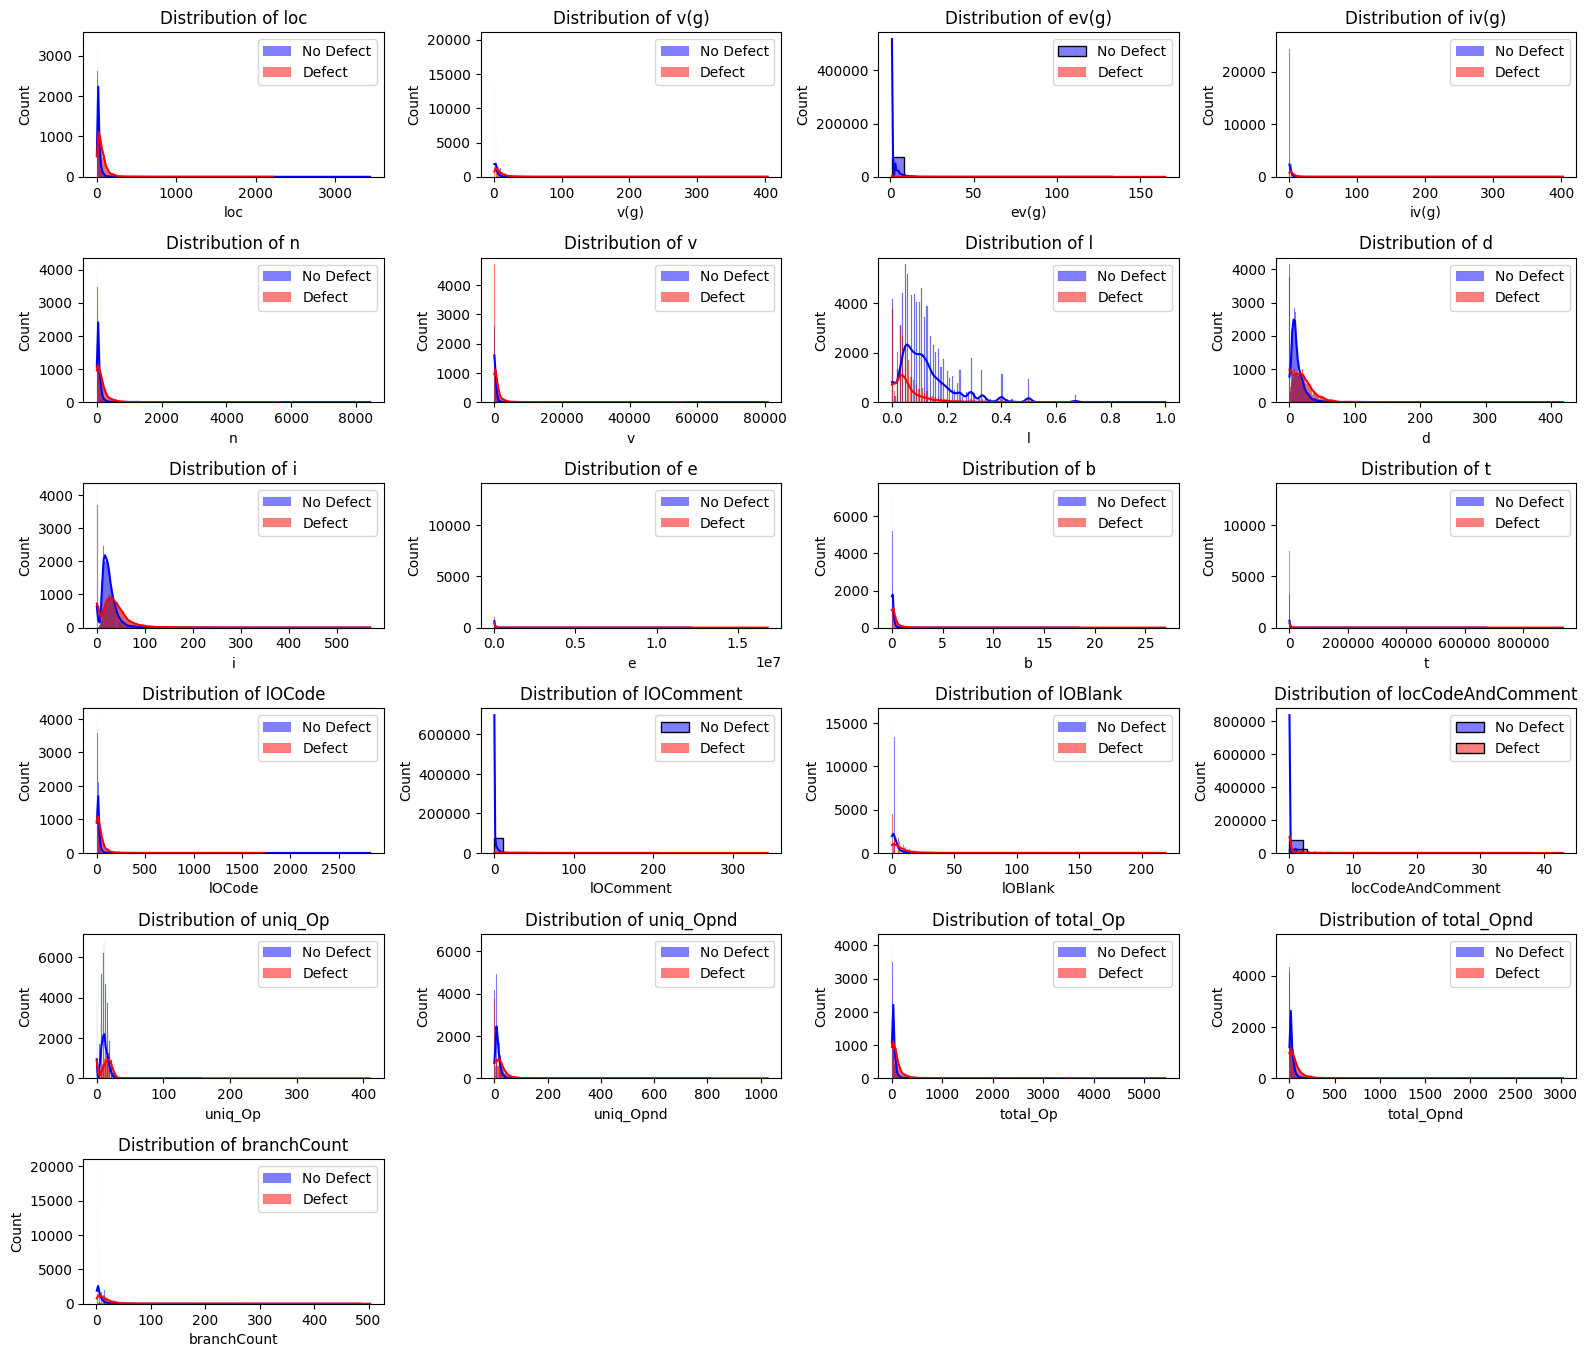

In [ ]:
#@title Plot the distribution of input features excluding id
features = software_defect.iloc[:, 1:-1].columns

plt.figure(figsize=(16, 20))

for i, feature in enumerate(features):
    plt.subplot(9, 4, i+1)
    sns.histplot(software_defect[software_defect['defects'] == 0][feature], kde=True, color='blue', label='No Defect')
    sns.histplot(software_defect[software_defect['defects'] == 1][feature], kde=True, color='red', label='Defect')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend()

plt.tight_layout()
plt.show()

As from the above 21 histograms, we see that our input features are in different scales, just as what we observed in the above basic statistics of the dataset. Therefore, we want to plot the historgams according to individual feature's scale by zooming in on specific sections of the histograms. This helps us better visualize the input features appear in this dataset.

----

It is also worth noting that in these histograms, we can observe that there are many outliers data present in each features. These outliers, represented as thin and short bins that significantly deviating from the majority of the distribution. However, this outliers data might be interpreted as for some programs, they contain significantly longer codes and comments compared to other programs. But for the purpose of modeling, we might want to further identify and understand these outliers as they may represent exceptional cases or anomalies that could significantly impact the overall analysis. (potentially via some other EDA methods)

Creating legend with loc="best" can be slow with large amounts of data.
Creating legend with loc="best" can be slow with large amounts of data.


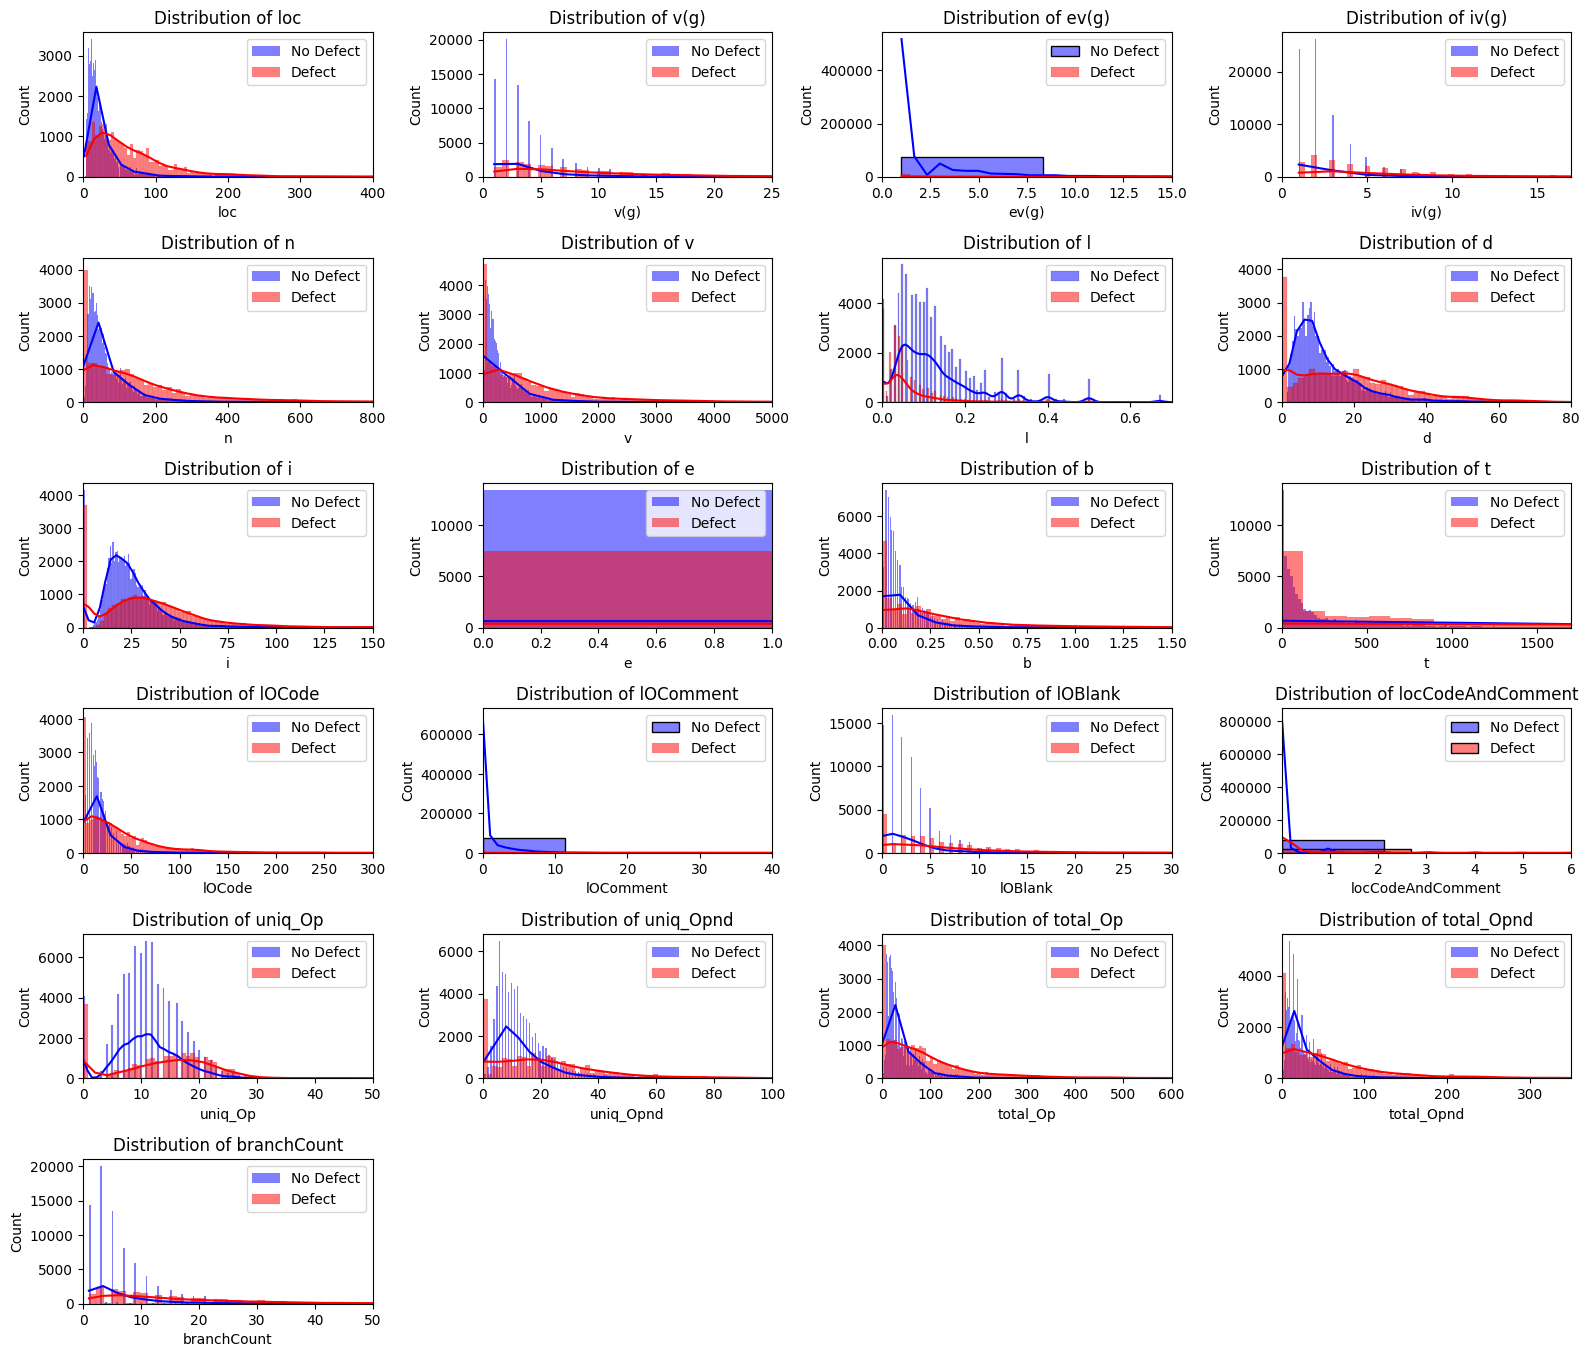

In [ ]:
#@title Plot the distribution of input features excluding id (Zoom in)
# Lets' difine the x-axis limits for each features
ranges = {'loc': 400, 'v(g)': 25, 'ev(g)': 15, 'iv(g)': 17, 'n': 800, 'v': 5000, 'l': 0.7, 'd': 80, 'i': 150, 'e': 1, 'b': 1.5, 't': 1700,
       'lOCode': 300, 'lOComment': 40, 'lOBlank': 30, 'locCodeAndComment': 6, 'uniq_Op': 50, 'uniq_Opnd': 100, 'total_Op': 600, 'total_Opnd': 350, 'branchCount': 50}


plt.figure(figsize=(16, 20))

for i, feature in enumerate(features):
    plt.subplot(9, 4, i+1)
    sns.histplot(software_defect[software_defect['defects'] == 0][feature], kde=True, color='blue', label='No Defect')
    sns.histplot(software_defect[software_defect['defects'] == 1][feature], kde=True, color='red', label='Defect')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.xlim(xmin=0, xmax=ranges[feature])
    plt.ylabel('Count')
    plt.legend()

plt.tight_layout()
plt.show()

That looks better, isn't it?

Based on those histograms, we observe a distinct trend wherein programs labeled as "Defect" exhibit larger values for their associated features compared to programs labeled as "No Defect." This observation aligns with the intuitive expectation that programs without defects may possess certain characteristics that distinguish them from programs with defects. The larger feature values in the "Defect" category may indicate a higher degree of complexity, sophistication, or completeness in the codebase. The defect programs may contain more lines of complicated code and comments, contributing to the detrimental nature of these programs. The increased complexity might result in a higher likelihood of introducing errors or bugs, leading to the classification of these programs as having defects. On the other hand, programs labeled as "No Defect" might exhibit lower feature values, suggesting the possibility of containing less complex code segments. This observation could imply that simpler and more straightforward code structures are associated with defect-free software.

----

Let's do one more step to confirm our findings. As all 21 features' histograms are right-skewed, why not centered our data by applying log-transform on the data.

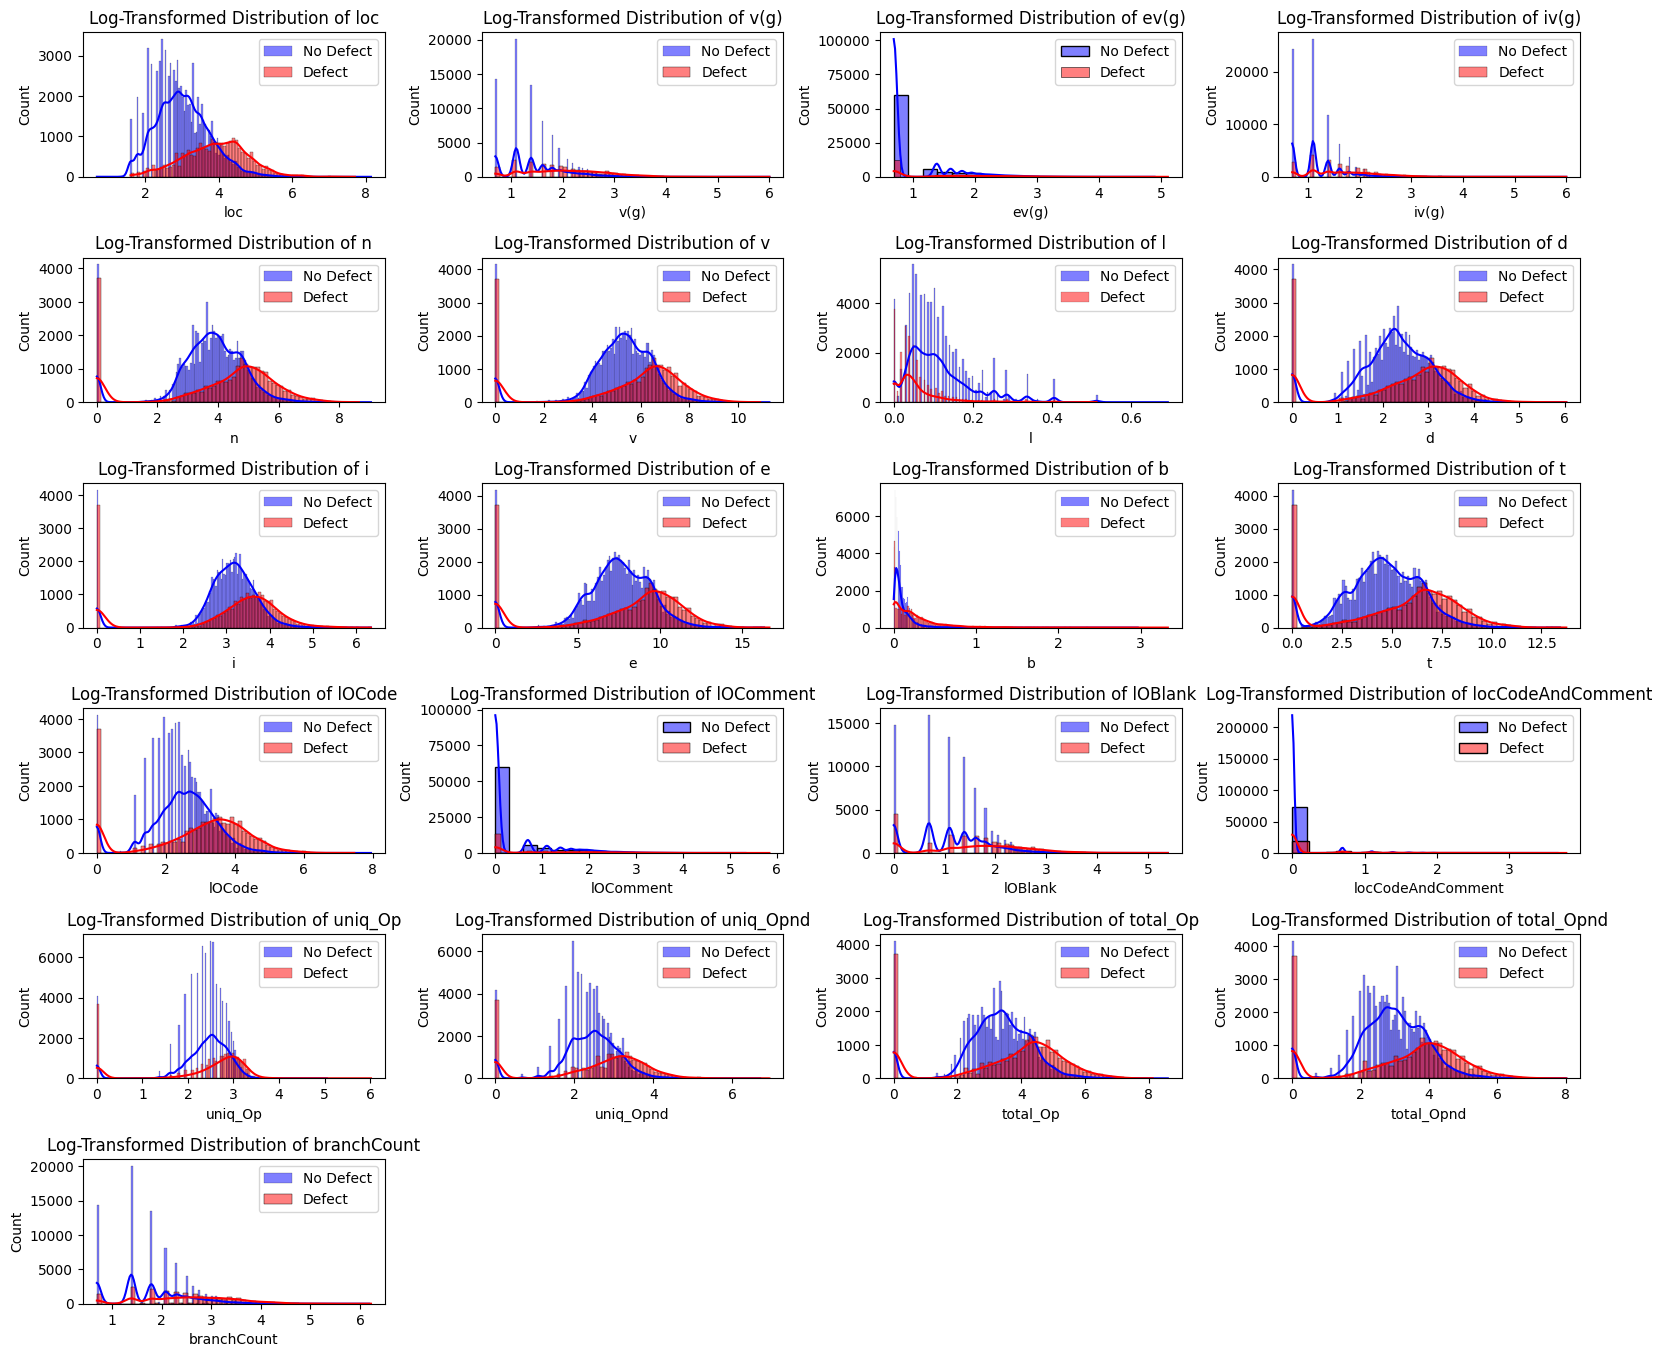

In [ ]:
#@title Plot the distribution of input features excluding id (Log-Transformed)

plt.figure(figsize=(16, 20))

for i, feature in enumerate(features):
    plt.subplot(9, 4, i+1)
    sns.histplot(np.log1p(software_defect[software_defect['defects'] == 0][feature]), kde=True, color='blue', label='No Defect')
    sns.histplot(np.log1p(software_defect[software_defect['defects'] == 1][feature]), kde=True, color='red', label='Defect')
    plt.title(f'Log-Transformed Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend()

plt.tight_layout()
plt.show()

With the Log-Transformed data, our histograms again show us "Defect" program exhibit larger values for their associated features compared to programs labeled as "No Defect." Also, the presence of outliers still be told from those histograms. Let's move on to do next EDA.

Boxplot of Input Features
---

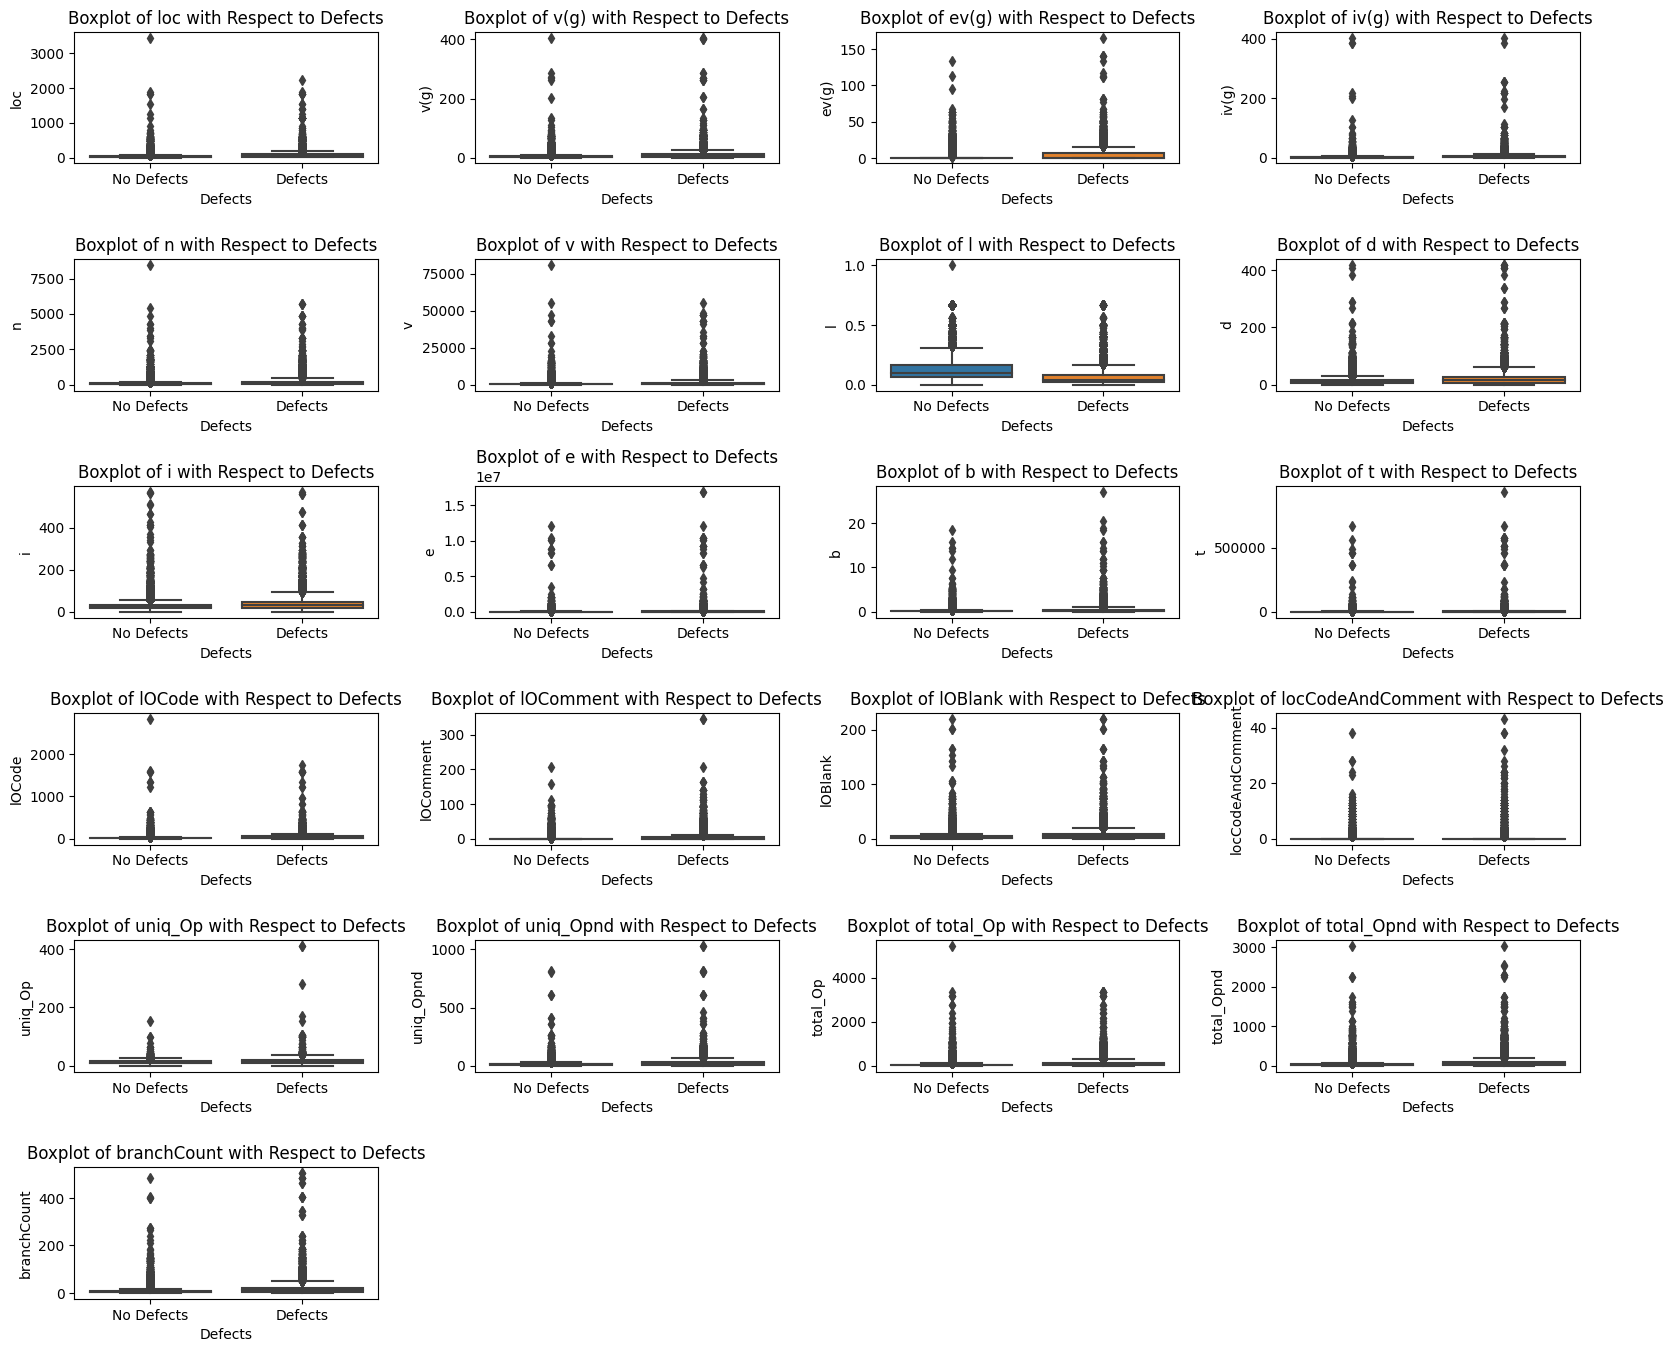

In [ ]:
#@title Plot the boxplot of input features excluding id
features = software_defect.iloc[:, 1:-1].columns

plt.figure(figsize=(16, 20))

for i, feature in enumerate(features):
    plt.subplot(9, 4, i+1)
    sns.boxplot(x='defects', y=feature, data=software_defect)
    plt.title(f'Boxplot of {feature} with Respect to Defects')
    plt.xlabel('Defects')
    plt.xticks([0, 1], ['No Defects', 'Defects'])
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

Based on the boxplots of 21 input features, we can clearly observe that the features are widely spread. Just as what we observed from the histograms, theses features contain many outliers data as present by data points in the boxplot. While one more findings compared to what we see from histograms is that outliers data tend to more common in "defect" programs, and the corresponding value of these outliers also tend to be larger compared to defect-free programs. Moreover, the boxplots again indicate that "Defect" program exhibit larger values for their associated features compared to programs labeled as "No Defect."

----

Also, as we also observed from histograms, all those box plots have longer tail to the upper, which implies a distribution with a rightward shift. We want to log-transformed these data and plot them again via violin plots to see if there are any new findings.

Violin Plot of Input Features
---

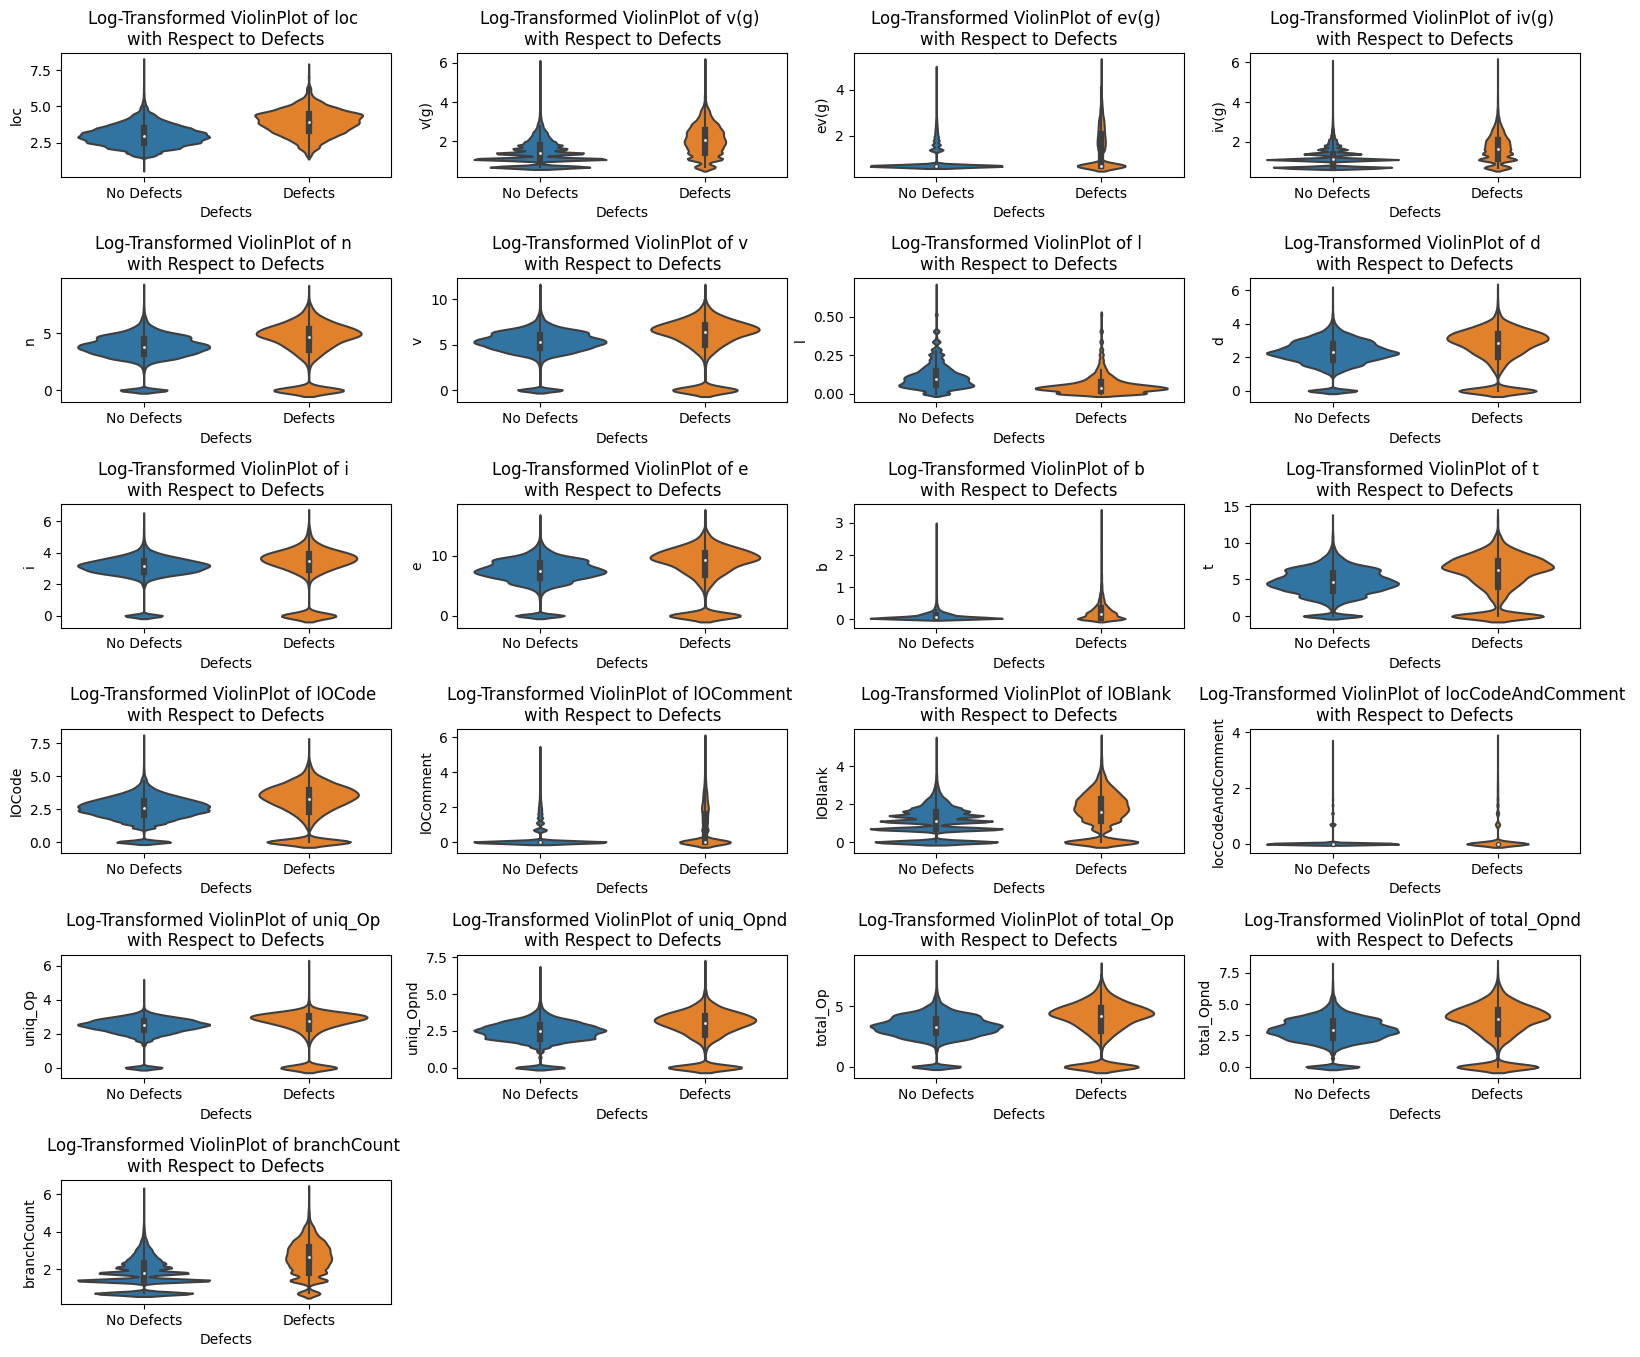

In [ ]:
#@title Plot the Violin Plot of input features excluding id (Log-Transformed)
features = software_defect.iloc[:, 1:-1].columns

# Log-transform the input features
software_defect_log = software_defect.copy()
software_defect_log[features] = np.log1p(software_defect_log[features])

plt.figure(figsize=(16, 20))

for i, feature in enumerate(features):
    plt.subplot(9, 4, i+1)
    sns.violinplot(x='defects', y=feature, data=software_defect_log)
    plt.title(f'Log-Transformed ViolinPlot of {feature} \nwith Respect to Defects')
    plt.xlabel('Defects')
    plt.xticks([0, 1], ['No Defects', 'Defects'])
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

Again, similar trends can be also observed in these log-transformed violin plots. The larger feature values in the "Defect" category compared to "No Defect" category highlights the importance of considering code complexity and comprehensibility in the context of software quality assurance. Some new findings from these violin plots is that in terms of outlier concentration, we see that "No Defects' programs tend to be more concentrated around the lower whisker. This indicates that defect-free program often have simpler and more straightforward code structures. However, this might be explained by the nature of this unbalanced dataset where "No Defects" data are more common, leading to its more concentrated character.

Correlation Matrix of Dataset
---
---

Now, it's worth to explore the correlation between each features available for the software programs. This can potentially help us to identify relationships and dependencies among different aspects of the programs. Moreover, identifying highly correlated features is crucial for feature selection in the modeling process, as it aids in avoiding multicollinearity and ensures that the selected features provide unique and relevant information for our model.

In [ ]:
#@title Get the Correlation Matrix
corr_matrix = software_defect[software_defect.columns[1:]].corr()
corr_matrix

loc      v(g)     ev(g)     iv(g)         n         v  \
loc                1.000000  0.761509  0.544569  0.696327  0.759605  0.758069   
v(g)               0.761509  1.000000  0.729249  0.790553  0.631041  0.618267   
ev(g)              0.544569  0.729249  1.000000  0.545255  0.390504  0.367697   
iv(g)              0.696327  0.790553  0.545255  1.000000  0.589718  0.585134   
n                  0.759605  0.631041  0.390504  0.589718  1.000000  0.928390   
v                  0.758069  0.618267  0.367697  0.585134  0.928390  1.000000   
l                 -0.388018 -0.387270 -0.325488 -0.291631 -0.300350 -0.254087   
d                  0.599474  0.574305  0.357735  0.487112  0.808291  0.748121   
i                  0.486427  0.304531  0.160594  0.319971  0.725408  0.673386   
e                  0.501281  0.430184  0.275179  0.394291  0.569544  0.582332   
b                  0.739926  0.611954  0.360889  0.563969  0.918254  0.935263   
t                  0.512228  0.472080  0.280391  0.414640  0.602202  0.590431   
lOCode             0.803460  0.641835  0.382541  0.636895  0.911761  0.899258   
lOComment          0.528029  0.379520  0.292689  0.337728  0.566374  0.531985   
lOBlank            0.670751  0.461759  0.282293  0.426030  0.775345  0.735278   
locCodeAndComment  0.246244  0.208324  0.164563  0.178546  0.262916  0.242057   
uniq_Op            0.367068  0.389917  0.200460  0.378869  0.618021  0.544283   
uniq_Opnd          0.637582  0.532358  0.279100  0.550633  0.818994  0.798964   
total_Op           0.764612  0.639125  0.394963  0.591597  0.963373  0.936446   
total_Opnd         0.761662  0.606453  0.372867  0.567097  0.953080  0.942189   
branchCount        0.762755  0.966702  0.774752  0.747870  0.626009  0.608678   
defects            0.342642  0.301187  0.259928  0.245618  0.258080  0.231179   

                          l         d         i         e         b         t  \
loc               -0.388018  0.599474  0.486427  0.501281  0.739926  0.512228   
v(g)              -0.387270  0.574305  0.304531  0.430184  0.611954  0.472080   
ev(g)             -0.325488  0.357735  0.160594  0.275179  0.360889  0.280391   
iv(g)             -0.291631  0.487112  0.319971  0.394291  0.563969  0.414640   
n                 -0.300350  0.808291  0.725408  0.569544  0.918254  0.602202   
v                 -0.254087  0.748121  0.673386  0.582332  0.935263  0.590431   
l                  1.000000 -0.426309 -0.162300 -0.091764 -0.254245 -0.097000   
d                 -0.426309  1.000000  0.515402  0.471276  0.755130  0.493976   
i                 -0.162300  0.515402  1.000000  0.286149  0.681469  0.300938   
e                 -0.091764  0.471276  0.286149  1.000000  0.614868  0.798266   
b                 -0.254245  0.755130  0.681469  0.614868  1.000000  0.606153   
t                 -0.097000  0.493976  0.300938  0.798266  0.606153  1.000000   
lOCode            -0.289713  0.778856  0.677093  0.580089  0.881238  0.593100   
lOComment         -0.187982  0.486619  0.435828  0.328993  0.531810  0.343287   
lOBlank           -0.288838  0.676297  0.654349  0.436276  0.743894  0.442066   
locCodeAndComment -0.125480  0.268184  0.214151  0.124604  0.244790  0.129090   
uniq_Op           -0.399440  0.782781  0.527640  0.275824  0.538952  0.306073   
uniq_Opnd         -0.283644  0.690652  0.803330  0.414846  0.795270  0.444073   
total_Op          -0.294469  0.808275  0.702058  0.579018  0.922115  0.602882   
total_Opnd        -0.290559  0.784738  0.740201  0.566986  0.935335  0.581832   
branchCount       -0.416185  0.575155  0.313935  0.427110  0.611808  0.456930   
defects           -0.253237  0.241936  0.208577  0.095366  0.232594  0.099592   

                     lOCode  lOComment   lOBlank  locCodeAndComment   uniq_Op  \
loc                0.803460   0.528029  0.670751           0.246244  0.367068   
v(g)               0.641835   0.379520  0.461759           0.208324  0.389917   
ev(g)              0.382541   0.292689  0.282293     

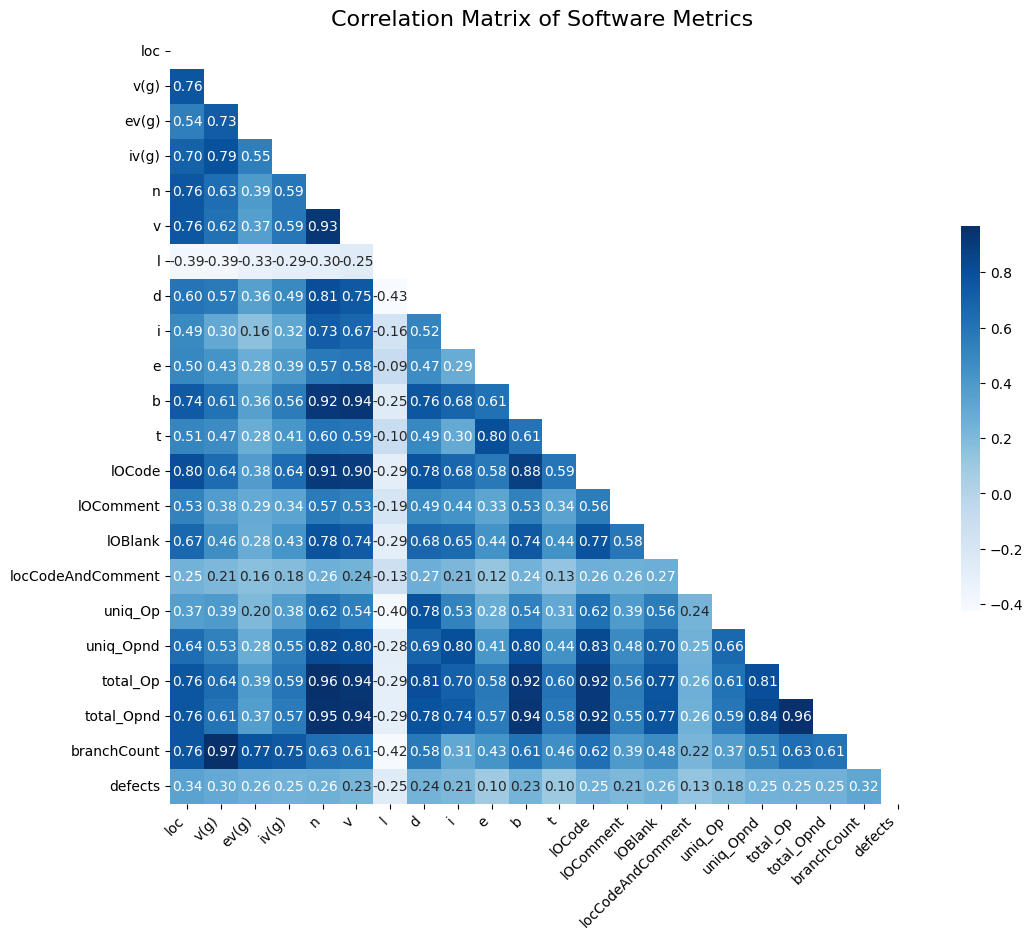

In [ ]:
#@title the Correlation Matrix
plt.figure(figsize=(12, 10))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='Blues', cbar_kws={'shrink': .5}, mask=mask)
plt.title('Correlation Matrix of Software Metrics', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

From the above plot of correlation matrix, we can get some insights into our data:

---

First and foremost, let's look at the relationship between each input features with respect to target variable, Defects.

- The observed correlation between the input features and the defects variable does not appear to be very strong.
- The features, **loc (McCabe's line count of code), v(g) (McCabe's cyclomatic complexity), and branchCount (percentage of the flow graph)** are relatively highly correlated with defects variable. These correlation makes sense as from the above EDAs, we have already observed that the degree of complexity, sophistication, or completeness of programs distinguish defect programs from defect-free programs.
- The features, **e (Halstead "effort") are t (Halstead time estimator)** are relatively weakly correlated with defects variable. These correlations also make sense in the context of real-world, as individual efforts and time put into writing the program are less likely to affect the characteristics and quality of code. Individual efforts and time put into writing the program might be confounding variable, as they are differ from programmers' coding ability perspective.
- The feature, **l (Halstead "program length")**, is negatively correlated with the defects variable. This somehow contradicts our finding from the above EDAs, in which it implies that longer program lengths may contribute to more robust and error-resistant software. But with this new findings, we can further refine our hypothesis. The increased complexity might result in a higher likelihood of introducing errors or bugs, but longer program lengths still support the notion that complete, comprehensive, and well-structured codebases are less prone to defects. This understanding invites further investigation into the intricate dynamics between program length, complexity, and software robustness, which will be discussed later in this project.

---

What's more, let's look into the relationship between each input feature.

- The feature, **l (Halstead "program length")**, tend to show a relatively weak negative correlation with all other features. This might suggest the less usefulness of this feature. However, as we discussed above, the negative correlation with defects variable might still indicate that this character can guide our decision-making processes in the context of software quality assessment.
- Note that, there are some highly correlated input features, which are **branchCount & v(g), total_Opnd & n, total_Opnd & v, total_Opnd & b, total_Op & n, total_Op & v, total_Op & b, total_Op & total_Opnd, n & v, b & v**. These correlations might indicate shared patterns or characteristics that co-occur within the software programs. We want to further analyze these correlations within the following EDA section.

Scatter Plot of Highly Correlated Input Features
---

Let's further varify/analzye our findings above via scatter plots.

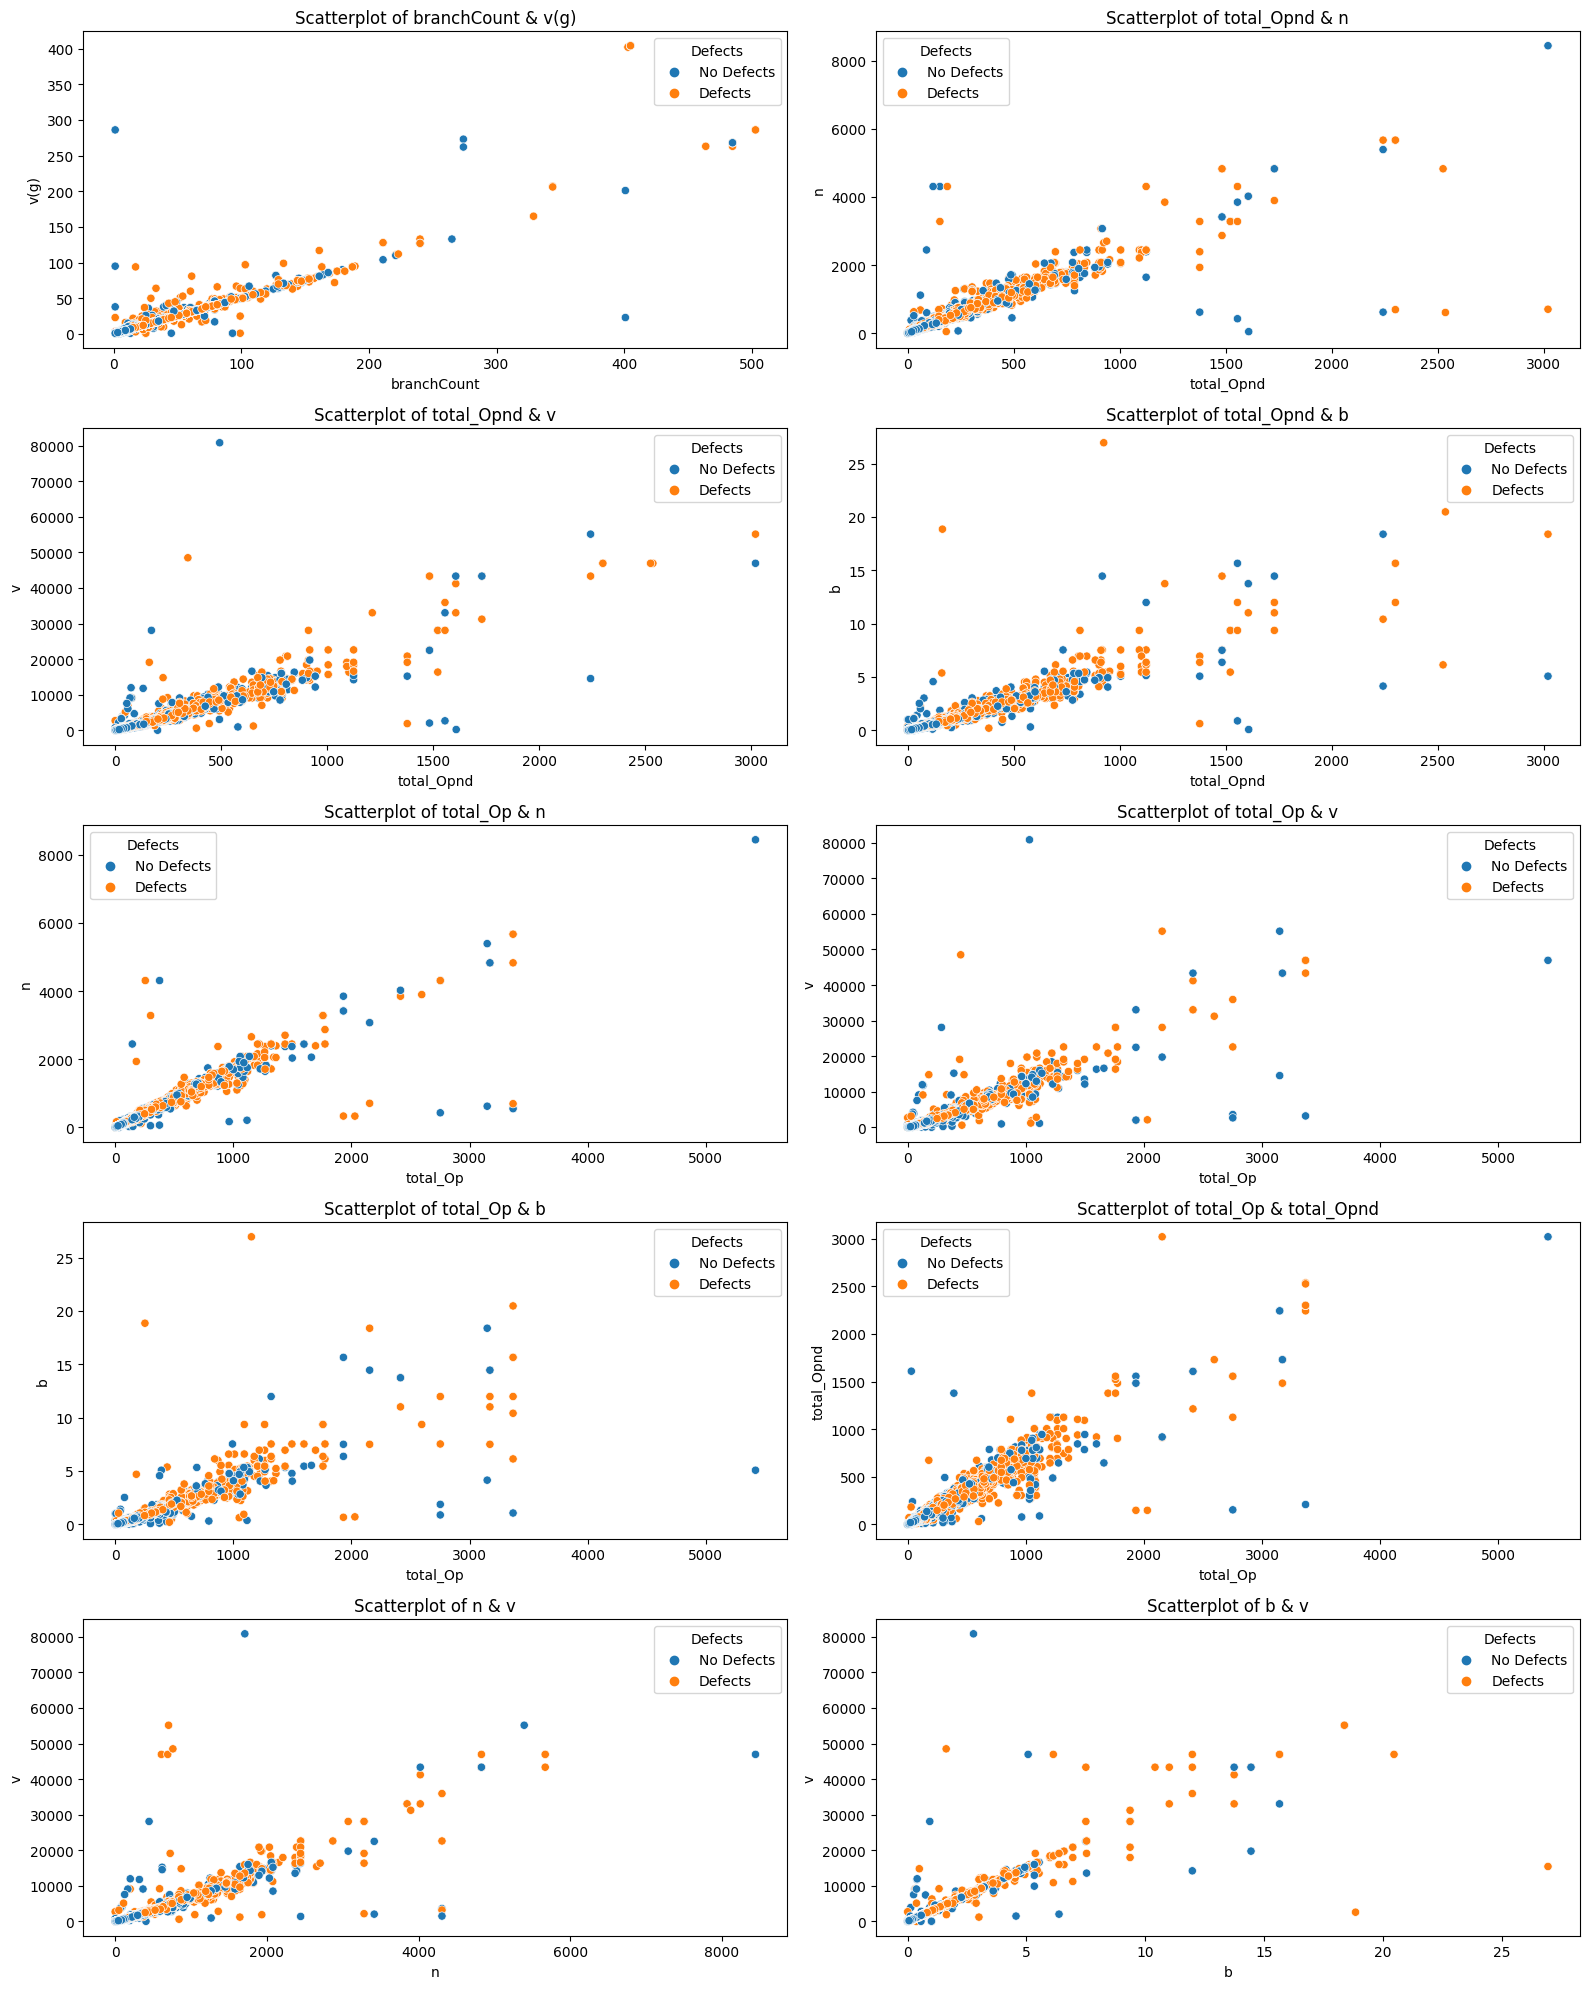

In [ ]:
# Plot the scatterplot of the highly correlated feature pairs
feature_pairs = [('branchCount', 'v(g)'), ('total_Opnd', 'n'), ('total_Opnd', 'v'), ('total_Opnd', 'b'), ('total_Op', 'n'), ('total_Op', 'v'), ('total_Op', 'b'), ('total_Op', 'total_Opnd'), ('n', 'v'), ('b', 'v')]

software_defect_copy = software_defect.copy()
software_defect_copy['defects'] = software_defect_copy['defects'].map({0: 'No Defects', 1: 'Defects'})

plt.figure(figsize=(16, 20))

for i, feature_pair in enumerate(feature_pairs):
    plt.subplot(5, 2, i+1)
    sns.scatterplot(x=feature_pair[0], y=feature_pair[1], data=software_defect_copy, hue='defects')
    plt.title(f'Scatterplot of {feature_pair[0]} & {feature_pair[1]}')
    plt.xlabel(feature_pair[0])
    plt.ylabel(feature_pair[1])
    plt.legend(title='Defects')

plt.tight_layout()
plt.show()

Based on the above scatter plots, we can verify that some input features are highly correlated and they appear a linear relationship. Therefore, we would want to do feature engineering like PCA so that the multicollinearity problem would not affect our modeling process. Also, notice that all these scatterplots appear a positive trend, which makes sense as programs get more complex (length & complexity), their corrending metrics value would also increase.

---

Great! With enough understanding of our data, let's now do the modeling stage of our project.

# Modeling

---
As from the above analyses, we know that our task is a binary classification problem. Therefore, we would like to build classification models, such as Logistic Regression, decision tree like Random Forest, and boosting model like Gradient Tree Boosting and XGBoost classifier for the predictive modeling analyses.

Evaluation Metrics
---

Before we dive into building our classification model. It is crucial to identify the evaluation metics for our models, as it ensures the correctness/quality of our final product.

As from the distribution of the target variable, defects, we see that our dataset are highly imbalanced. This indicates that we might want to use some metrics other than accruacy (as explained before) for our models' evaluation. With this in mind, we will mainly focus our evaluation into these two metrics.

- **F1-Score**: The F1-score is the harmonic mean of precision (positive predictive value) and recall (true positive rate). It is a better measure than accuracy when the classes are imbalanced. Given that our dataset is imbalanced, we will use the F1-score to evaluate the models. Also, the weighted F1-score is being used to evaluate the model, as it is the average of the F1-score of each class, weighted by the number of samples in each class. This weighted value helps us better understand the model's performance.

- **ROC/AUC**: ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. The higher the AUC, the better the model is at predicting 0s as 0s and 1s as 1s. An excellent model has AUC near to the 1 which means it has a good measure of separability. A poor model has AUC near to the 0 which means it has the worst measure of separability. ROC is plotted with TPR against the FPR where TPR is on the y-axis and FPR is on the x-axis.

Note: While the (weighted) F-1 score and ROC/AUC remain as our main metrics, we will also calculate the accuracy, (weighted) precision and recall for reference.

In [ ]:
#@title Define the Evalution Function
def evaluate_model(model, X, y):
    # Predicting the test data
    y_pred = model.predict(X)

    # Calculating different metrics
    report = classification_report(y, y_pred)

    # Creating and displaying the confusion matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(12, 6), dpi=200)
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['No Defects', 'Defects'], yticklabels=['No Defects', 'Defects'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    # Predicting the probabilities
    y_pred_proba = model.predict_proba(X)[:, 1]

    # Calculating the ROC Curve and AUC
    fpr, tpr, _ = roc_curve(y, y_pred_proba)

    # Creating a smoother ROC curve
    smooth_fpr = np.linspace(0, 1, 100)
    smooth_tpr = np.interp(smooth_fpr, fpr, tpr)
    smooth_roc_auc = roc_auc_score(y, y_pred_proba)

    # Plotting ROC Curve
    plt.subplot(1, 2, 2)
    plt.plot(smooth_fpr, smooth_tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % smooth_roc_auc)
    plt.plot([0, 1], [0, 1], color='darkgray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

    return report, round(smooth_roc_auc, 2)


Training, Validation, Test Data Split
---

Other than the evaluation metrics, it is also important to split our data into the training, validation, and test sets. This helps ensure the robustness and generalization of our model. The training set will be used to train the model's parameters, allowing it to learn patterns and relationships within the data. The validation set serves as a benchmark during the training process, enabling us to fine-tune hyperparameters and prevent overfitting. Moreover, by having a separate test set that the model has never seen during training, we can objectively assess its performance on new and unseen data by the above evaluating metrics.

For this project, we will be using a 65/15/20 split for the training, validation, and test sets. For the purpose of reproducing the same output if we rerun the code, we will set the random seed to be 42, as mentioned above.

In [ ]:
#@title Split to get Training, Validation, Test Data

# First, let's get our features and target variable
X = software_defect.iloc[:, 1:-1]
y = software_defect.iloc[:, -1]

# Split the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

# Display the shapes of the train, validation, and test sets
print("Training set shapes:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("\nValidation set shapes:")
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("\nTest set shapes:")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("y_test shape:", y_test.shape)

Training set shapes:
X_train shape: (65128, 21)
y_train shape: (65128,)

Validation set shapes:
X_val shape: (16282, 21)
y_val shape: (16282,)

Test set shapes:
X_test shape: (20353, 21)
y_test shape: (20353,)
y_test shape: (20353,)


BaseLine Model - Logistic Regression
---

For the baseline model, we will use the Logistic Regression model. Logistic Regression is a classification algorithm that is used to predict the probability of a categorical dependent variable. In this case, the dependent variable is the defects column, which is a binary variable. The model will predict the probability of a software module having a defect or not. We choose Logistic Regression as our baseline model because of its simplicity, interpretability, and effectiveness in binary classification tasks.

In [ ]:
#@title Vanilla Logistic Regression
# Let's first try to fit our vanilla Logistic Regression on the training set
log_reg = LogisticRegression(random_state=seed)
log_reg.fit(X_train, y_train)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


LogisticRegression(random_state=42)

ooops! From the above logs, we see that the model fails to fit on the data as it failed to converge. By reading the messages, we see that it fails to converge because the number of iterations (max_iter) has reached. As according to the [library](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), the default number of iterations (max_iter) is set to 100. Because the volume of our data, the logistic regression is failed to converge given the number of iterations allow. Therefore, as suggested by the output, let's increase the number of iterations (max_iter) to 1000 to see whether it will work.

In [ ]:
# Let's fit the training set to our vanilla Logistic Regression again, with increasing max_iter
log_reg = LogisticRegression(random_state=seed, max_iter=1000)
log_reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

Great! It works now. Let's now evaluate how our model performs by calling the previously defined evaluate_model() function on the test set.

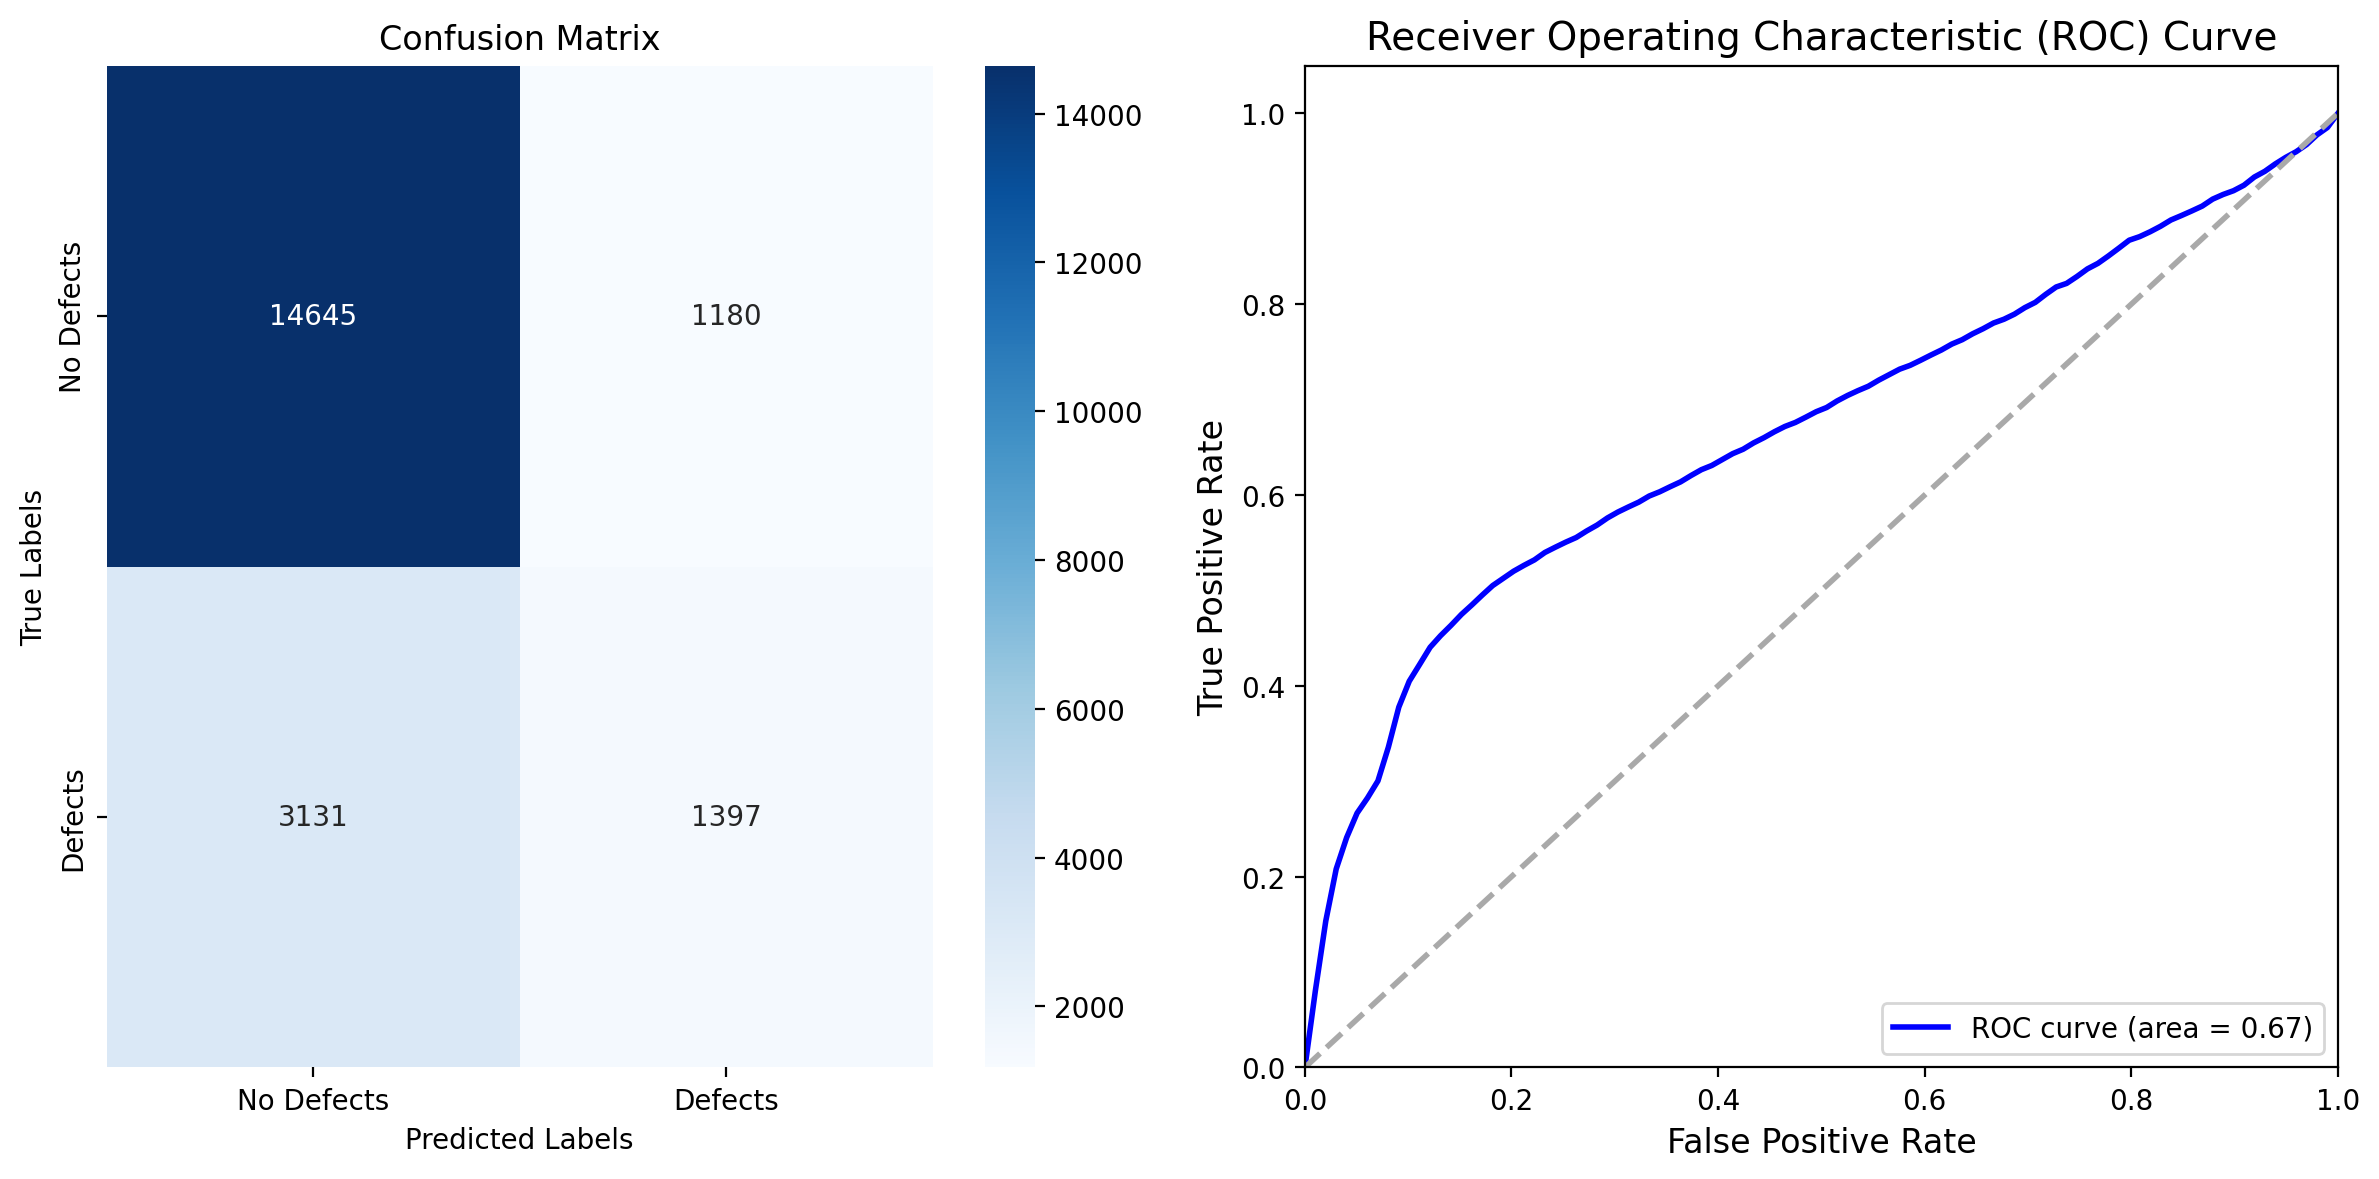

Baseline Test Results: 
              precision    recall  f1-score   support

           0       0.82      0.93      0.87     15825
           1       0.54      0.31      0.39      4528

    accuracy                           0.79     20353
   macro avg       0.68      0.62      0.63     20353
weighted avg       0.76      0.79      0.77     20353

Baseline Test AUC:  0.67


In [ ]:
# Evaluating the model on the test set
report, auc = evaluate_model(log_reg, X_test, y_test)

print("Baseline Test Results: ")
print(report)
print("Baseline Test AUC: ", auc)

Based on the above evaluation metrics, we can see that our vanilla logistic regression model doesn't adequately fit to the data, although it is a decent prediction. The value of 0.67 for AUC means that there is a 67% chance that the model will be able to distinguish between positive class and negative class. Meanwhile, based on the value of weighted F1-score, we see that value of 0.77 is good in terms of prediction as the model is able to correctly predict more than half of the test samples. However, based on the confusion matrix as well as the precision, recall and macro f1-score for the positive labeled samples, we see that the model is doing very poorly on predicting the positive class. There are almost half of the positive samples is being misclassified as negative. As we previously mentioned, this is very detrimental in real-world situation, as we want our model to be more sensitive and responsive to this positive samples since they are defect programs. With that being said, we want to tune the vanilla logistic regression model to see if we can improve on these metrics, which will eventually make our model more capable.

As we saw during the EDA, the input features of our dataset are in different scales. Therefore, we would like to see whether feature scaling would improve the performance of our vanilla logistic regression model.

**Note**: although logistic regression model is a scale-invariant model, but feature scaling might be beneficial as it helps improve the convergence.

In [ ]:
#@title Feature Scaling (Normalization) via StandardScaler
# Instantiate the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the train set
scaler.fit(X_train)

# Transform the train, validation, and test sets
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Now, let's fit our vanilla logistic regression model again on the scaled training set
log_reg_scaled = LogisticRegression(random_state=seed, max_iter=1000)
log_reg_scaled.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

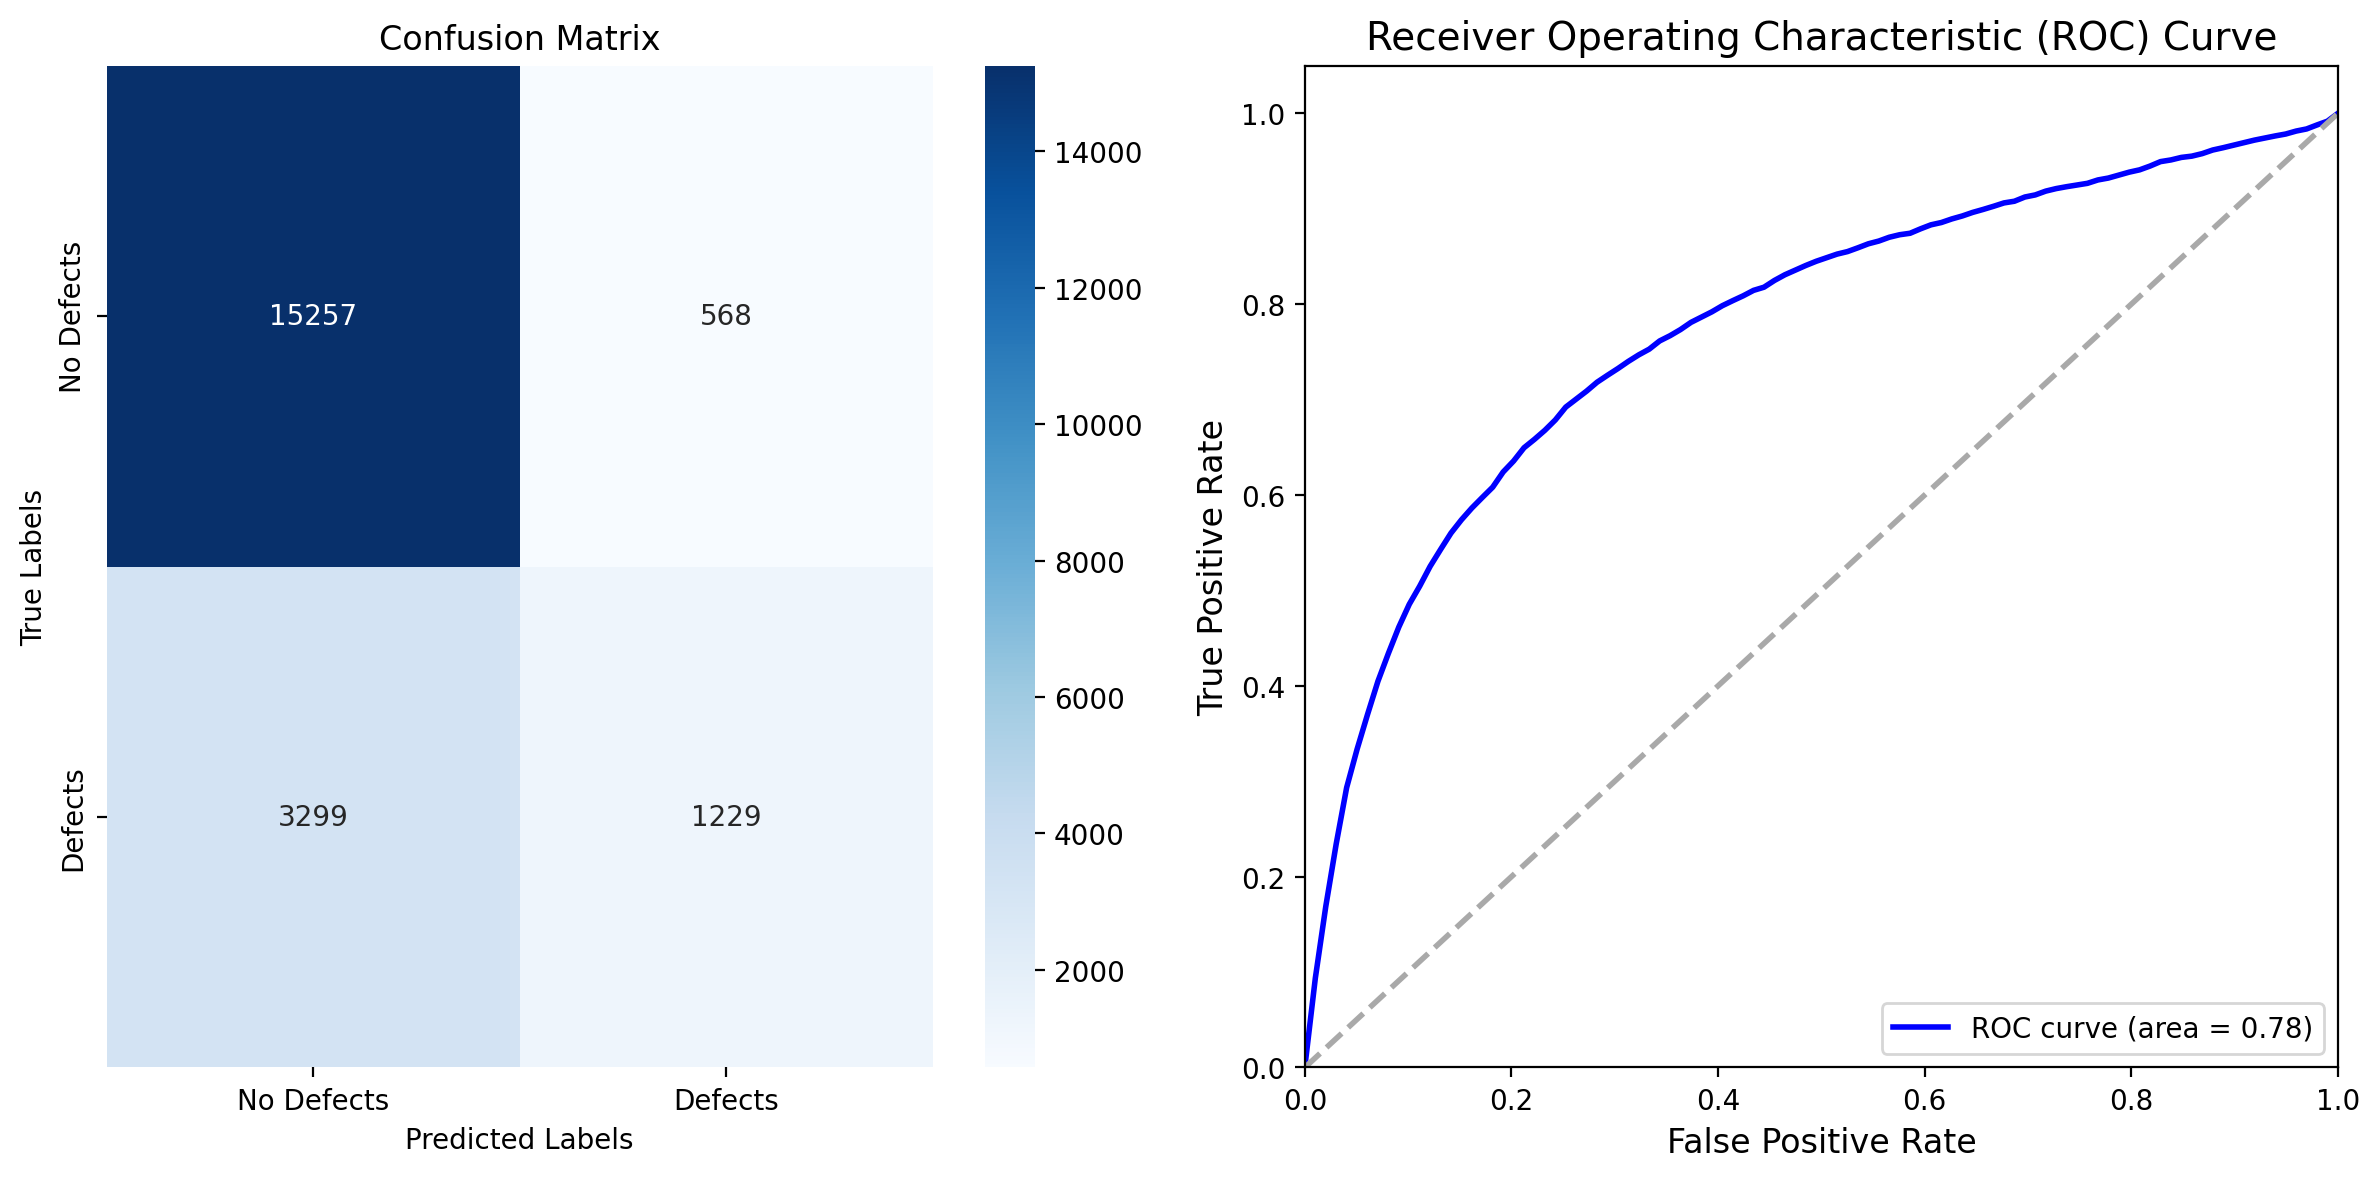

Baseline Test Results (standardized): 
              precision    recall  f1-score   support

           0       0.82      0.96      0.89     15825
           1       0.68      0.27      0.39      4528

    accuracy                           0.81     20353
   macro avg       0.75      0.62      0.64     20353
weighted avg       0.79      0.81      0.78     20353

Baseline Test AUC:  0.78


In [ ]:
# Evaluating the resulting model on the test set
report, auc = evaluate_model(log_reg_scaled, X_test_scaled, y_test)

print("Baseline Test Results (standardized): ")
print(report)
print("Baseline Test AUC: ", auc)

Great! We see that the performance of our vanilla logistic regression was improved. The AUC value is now 0.78, which indicates that there are 78% chance that the model will be able to distinguish between positive class and negative class. Also, based on the confusion matrix, we see that the model is more capable of predicting positive samples as positive. However, the weighted F1 score does not improve promisingly, as we see the model is still misclassified some of samples with the labels in comparison to the ground truth label. Therefore, it is worth trying a hyperparemter tuning on the model to see if we could make the vanilla logistic regression performs even better!

---

Specifically, we will be using Grid Search for the hyperparemter tuning for the logistic regression models. Grid search is a systematic method for selecting the optimal combination of hyperparameters by exhaustively evaluating all possible parameter values within a predefined search space. For our case, we will search for two different hyperparameters of logistic regression which are crucial for the performance of the model.
- **l1_ratio**: As name suggests, it is the regularization parameters for the logistic regression. Since we saw before that there are some input features are highly correlated, we want to avoid any multicollinearity that might affect the model's performance. Also, L1 regularization helps us to do feature selection, potentially improve the model's performance.
- **C**: It is an inverse of regularization strength. The smaller the values would specify stronger regularization. We want also tune this hyperparameter to control the regularization on the logistic regression model.

**Note**: Since we want to tune for regularized logistic regression, to make sure L1 and L2, are applied uniformly across all features, we will use the normalized data as got from previous step. (since it also contributes to better performance)

In [ ]:
#@title Hyperparemeter Tuning for Logistic Regression
# Defining the parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0, 0.25, 0.5, 0.75, 1],
}

# Initializing Grid Search with cross-validation
grid_search = GridSearchCV(
    LogisticRegression(random_state=seed, max_iter=1000, class_weight='balanced', penalty='elasticnet', solver='saga'),
    param_grid, cv=3, scoring=['f1_weighted', 'roc_auc'], n_jobs=-1,
    verbose=1, refit='f1_weighted')

# Fitting grid search
grid_search.fit(X_train_scaled, y_train)

# Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'C': 0.001, 'l1_ratio': 1}
Best Score: 0.7809400370447616


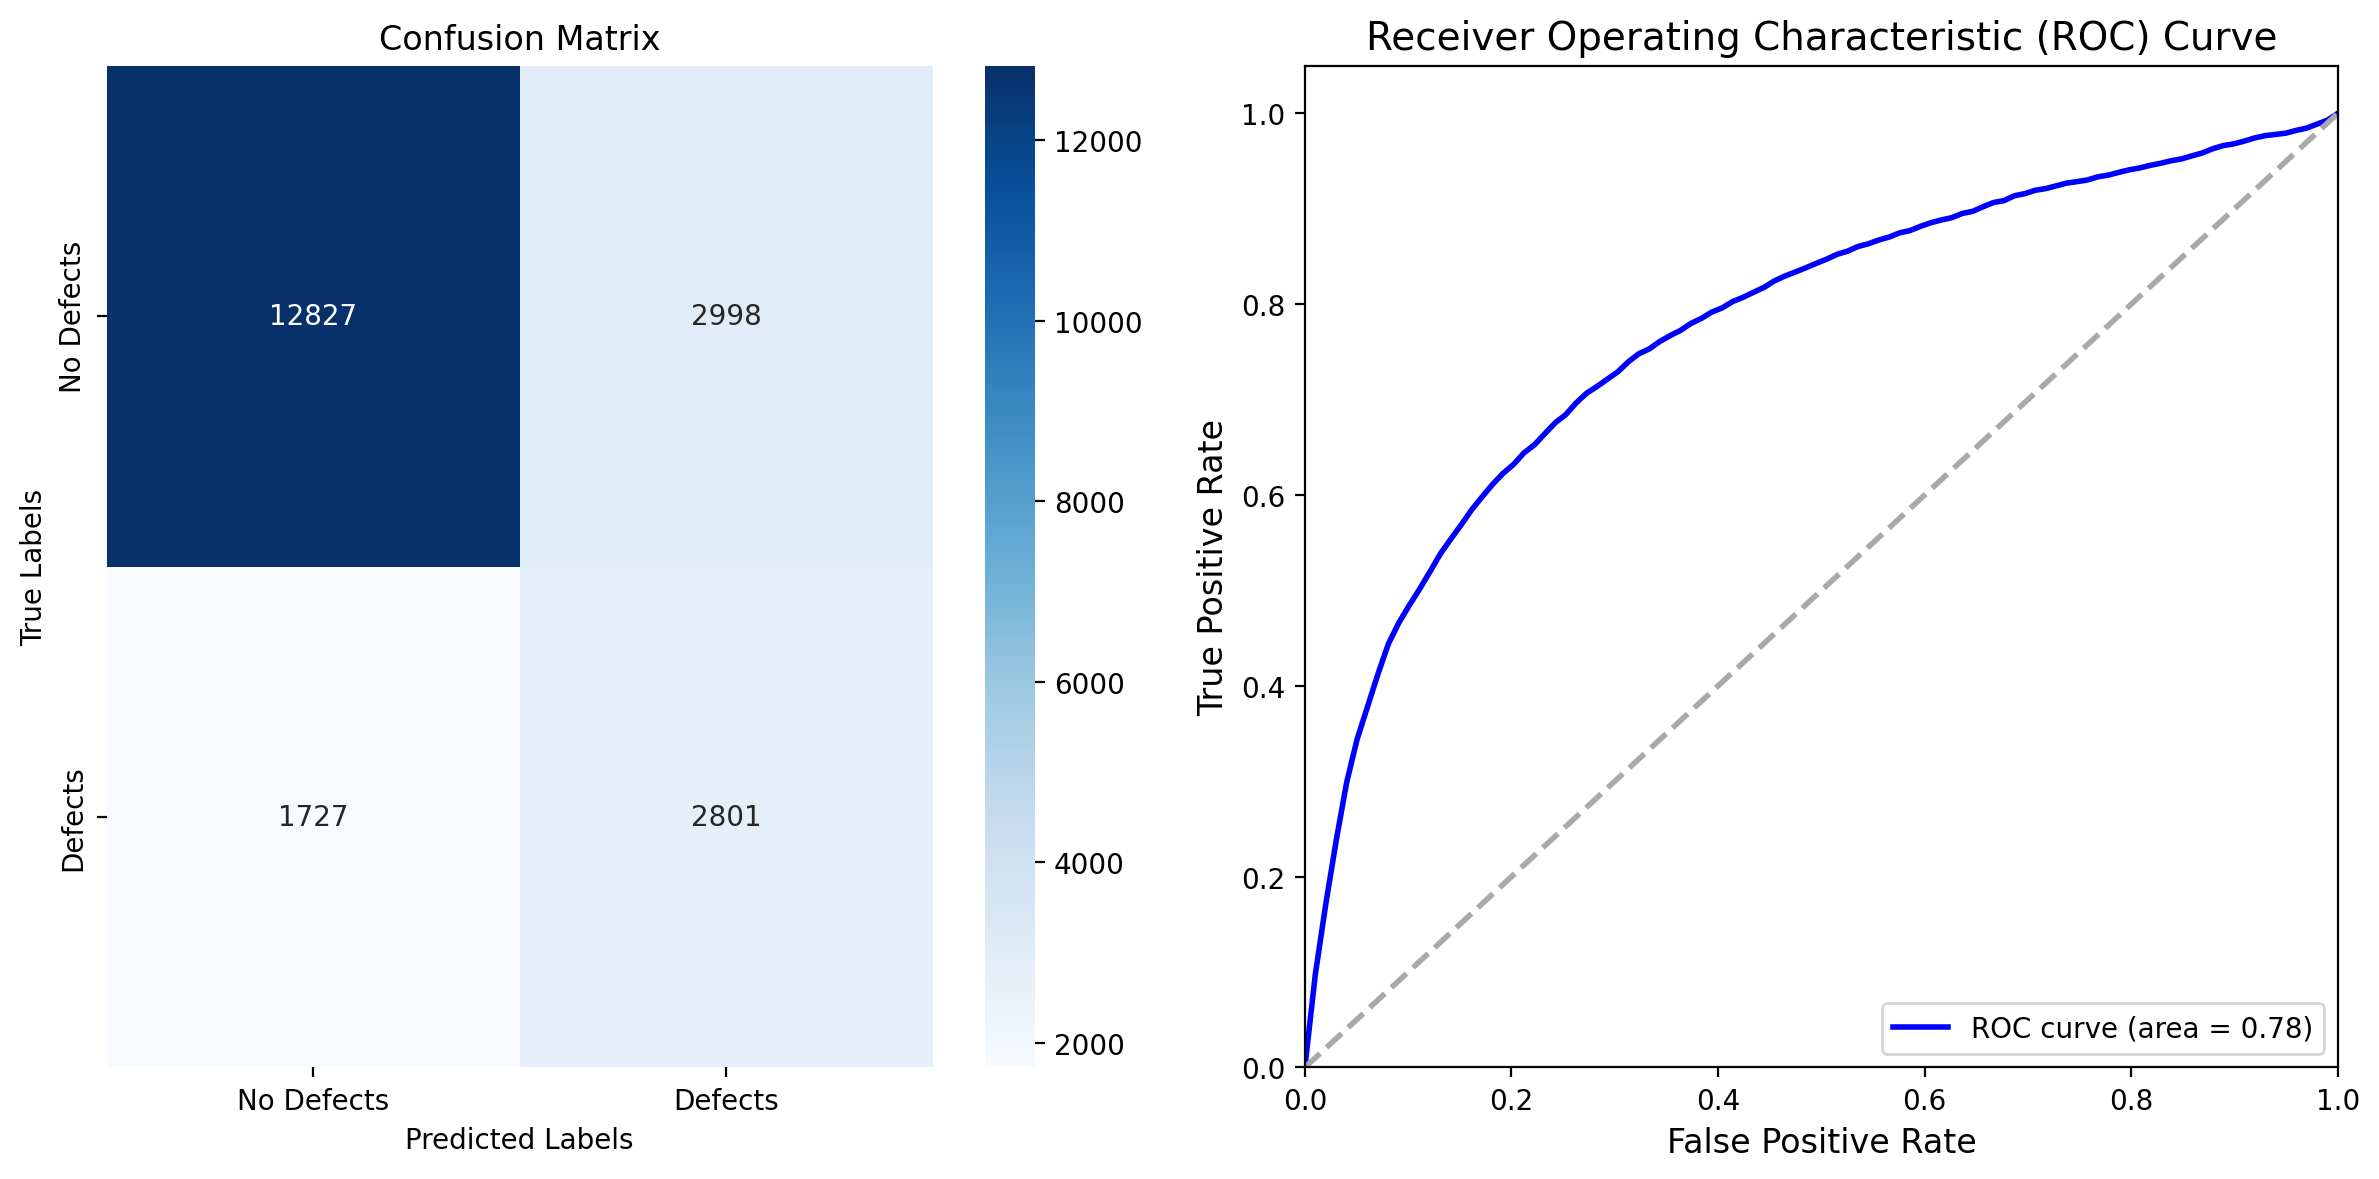

Baseline Test Results (Tuned): 
              precision    recall  f1-score   support

           0       0.88      0.81      0.84     15825
           1       0.48      0.62      0.54      4528

    accuracy                           0.77     20353
   macro avg       0.68      0.71      0.69     20353
weighted avg       0.79      0.77      0.78     20353

Baseline Test AUC:  0.78


In [ ]:
# Let's get the tuned logistic regression
log_reg_tuned = grid_search.best_estimator_

# Finally, let's evaluating the resulting model on the test set
report, auc = evaluate_model(log_reg_tuned, X_test_scaled, y_test)

print("Baseline Test Results (Tuned): ")
print(report)
print("Baseline Test AUC: ", auc)

Based on the above metrics, we see that the performance of our logistic regression .

---

In order to further improve our model's predictions, we would then want to interpret how our model arrives at its decisions. This involves delving into the feature importance and understanding which features contribute the most to the model's predictions. This analysis can be done via the help of SHAP (SHapley Additive exPlanations) value, in which it can provide insights into the impact of each feature on the model's output. Now, let's calculate the SHAP score on the tuned logistic regression.

In [ ]:
#@title SHAP Feature Importance Analysis
# Intialize the SHAP explainer
explainer = shap.LinearExplainer(log_reg_tuned, X_train_scaled,
                                 feature_perturbation="correlation_dependent")
shap_values = explainer(X_test_scaled)

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

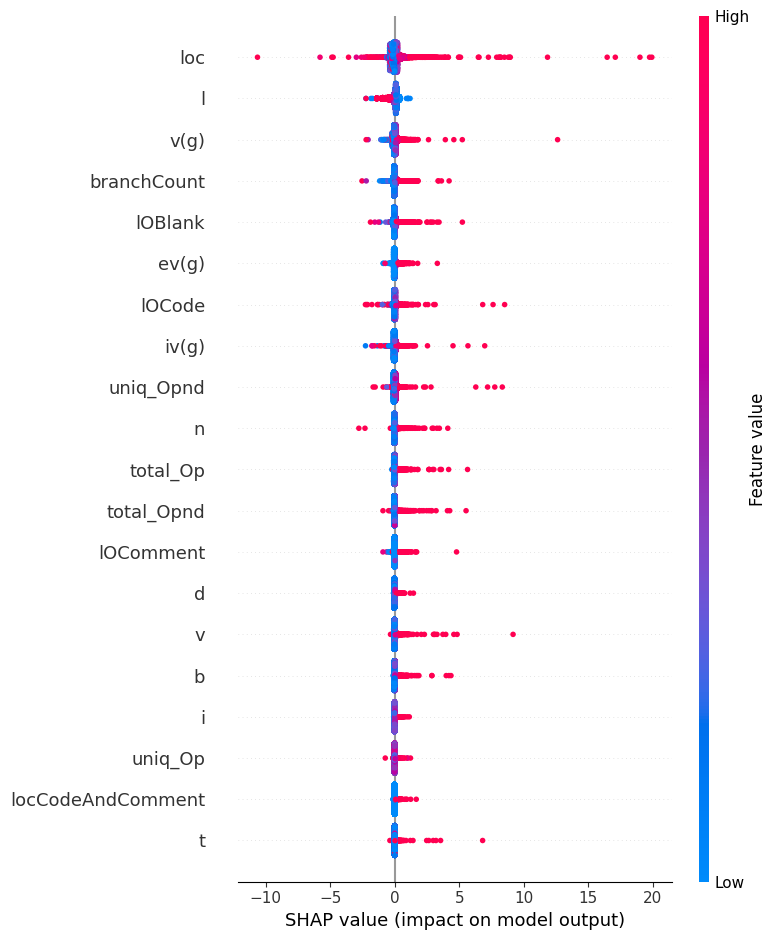

In [ ]:
# Plot the SHAP values
shap.summary_plot(shap_values.values, X_test_scaled, feature_names=software_defect.iloc[:, 1:-1].columns)

Based on the plot, we can see that features loc, l, v(g), and branchCount are considered to be important by our model in making predictions. These input features are what we mentioned as highly correlated features with the defect variable when we plot the confusion matrix in the EDA. Moreover, features like e and t are considered to be least important by our model in making predictions. These underlying patterns are somehow correct from our understanding, and that is why our model is able to obtain a decent performance on the classification task. However, since the performance is still not optimal, we would then want to use some more complex model to see if we can obatin better performance on the dataset.

Intermediate Model - Random Forest
---

To build more complex model on the dataset, we decide to build a Random Forest model as our intermediate model. Random Forest is an ensemble learning method that operates by constructing a multitude of decision trees during training and outputs the mode of the classes for classification tasks or the average prediction for regression tasks. The strength of Random Forest lies in its ability to handle non-linear relationships, capture intricate patterns, and mitigate overfitting by aggregating the predictions from multiple trees. As an intermediate step, it allows us to assess the impact of increased model complexity on model's performance and sets the stage for potential further refinement in pursuit of optimal performance.

In [ ]:
#@title Build Random Forest Model
rf = RandomForestClassifier(random_state=seed)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

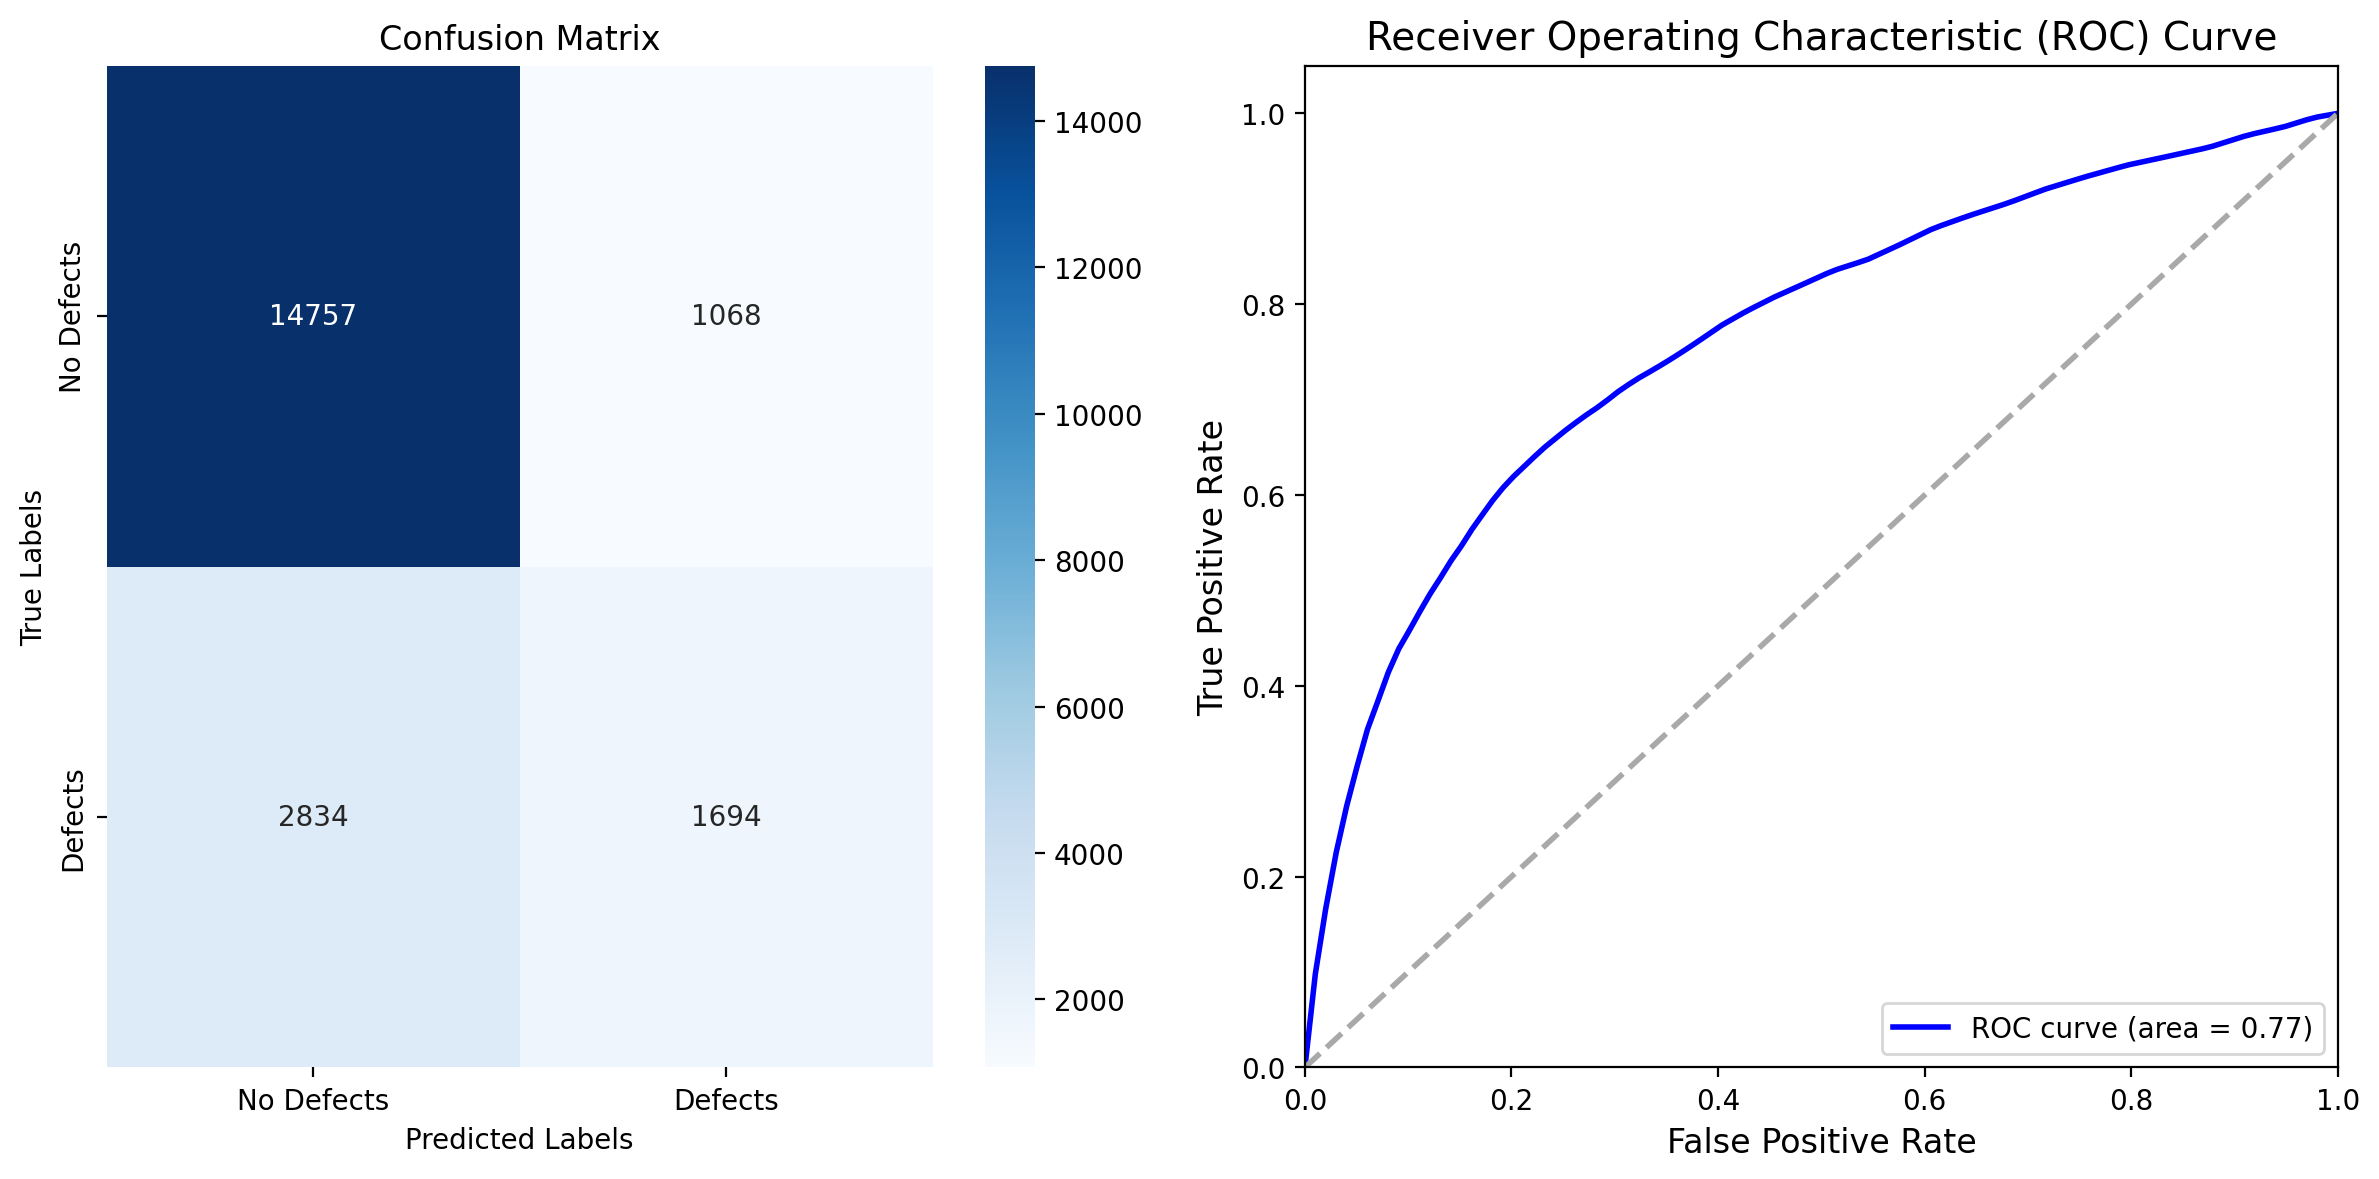

Intermediate Test Results: 
              precision    recall  f1-score   support

           0       0.84      0.93      0.88     15825
           1       0.61      0.37      0.46      4528

    accuracy                           0.81     20353
   macro avg       0.73      0.65      0.67     20353
weighted avg       0.79      0.81      0.79     20353

Intermediate Test AUC:  0.77


In [ ]:
# Evaluating the model on the test set
report, auc = evaluate_model(rf, X_test, y_test)

print("Intermediate Test Results: ")
print(report)
print("Intermediate Test AUC: ", auc)

Based on the above metrics, we see that the Random Forest model is more capable of making prediction on our dataset, as it achieves sub-optimal result compared to what we get from the logistic regression model even without any hyperparameters tuning steps. This might result from its complex and complicated algorithm nature. With that being said, we want to do hyperparemeter search on the model to see if we can achieve better performance.

---

Before doing the hyperparemter tuning, we would like to explore an alternative strategy beyond the regularization employed in the logistic regression model. Given the presence of highly correlated input features and the abundance of variables within our dataset, we want to do a very popular dimensionality reduction algorithm called Principal Component Analysis (PCA). PCA allows us to mitigate the impact of multicollinearity and reduce the dimensionality of the feature space, potentially enhancing model interpretability and generalization. Therefore, it is worth giving a try to see whether doing dimensionality reduction would improve the overall performance of our Random Forest model's prediction.

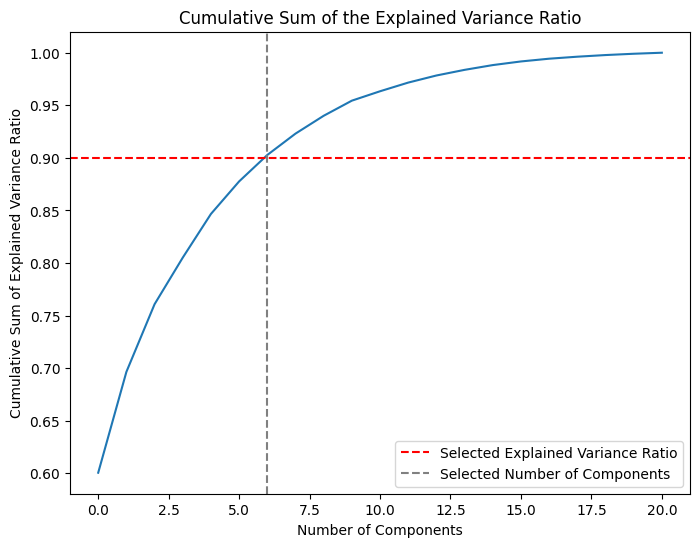

In [ ]:
#@title Principal Component Analysis (PCA)
# Instantiate the PCA
pca = PCA(random_state=seed)

# Fit the PCA to the scaled train set
pca.fit(X_train_scaled)

# Plot the cumulative sum of the explained variance ratio
cum_evr = np.cumsum(pca.explained_variance_ratio_)
intersection_idx = np.argmax(cum_evr >= 0.9)

plt.figure(figsize=(8, 6))
plt.plot(cum_evr)
plt.axhline(y=0.9, color='red', linestyle='--', label='Selected Explained Variance Ratio')
plt.axvline(x=intersection_idx, color='gray', linestyle='--', label='Selected Number of Components')
plt.title('Cumulative Sum of the Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Sum of Explained Variance Ratio')
plt.legend(loc='lower right')
plt.show()

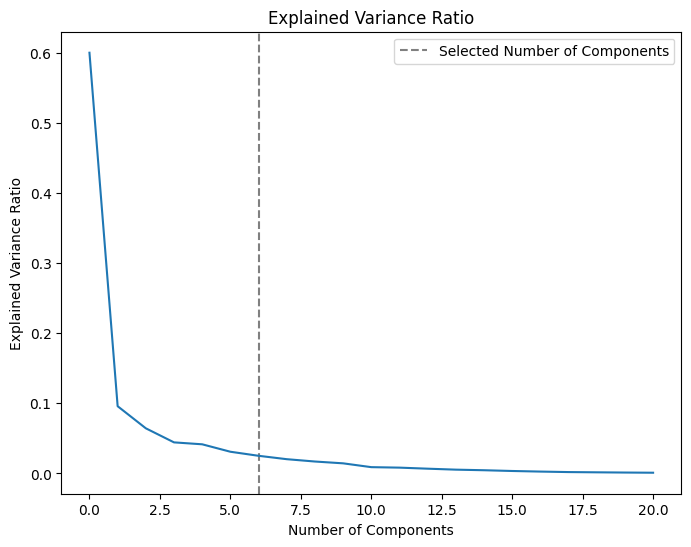

In [ ]:
# Plot the explained variance ratio
plt.figure(figsize=(8, 6))
plt.axvline(x=intersection_idx, color='gray', linestyle='--', label='Selected Number of Components')
plt.plot(pca.explained_variance_ratio_)
plt.title('Explained Variance Ratio')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.legend(loc='upper right')
plt.show()

With the above analysis, we see that the selected number of components is 6, as it explains approximately 90% of the variance in the original data, which is sufficient to represent the original dataset. Note that we have successfully selected 6 features to feed into our model (compared to 22 before), and we want to see if this could help improve our model's performance.

In [ ]:
#@title Feature Selection via PCA
# Instantiate the PCA with selected number of components (6)
pca = PCA(n_components=6, random_state=seed)

# Fit the PCA to the train set
pca.fit(X_train_scaled)

# Transform the train, validation, and test sets
X_train_pca = pca.transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [ ]:
# Now, let's fit our Random Forest model to the transfomred data
rf_pca = RandomForestClassifier(random_state=seed)
rf_pca.fit(X_train_pca, y_train)

RandomForestClassifier(random_state=42)

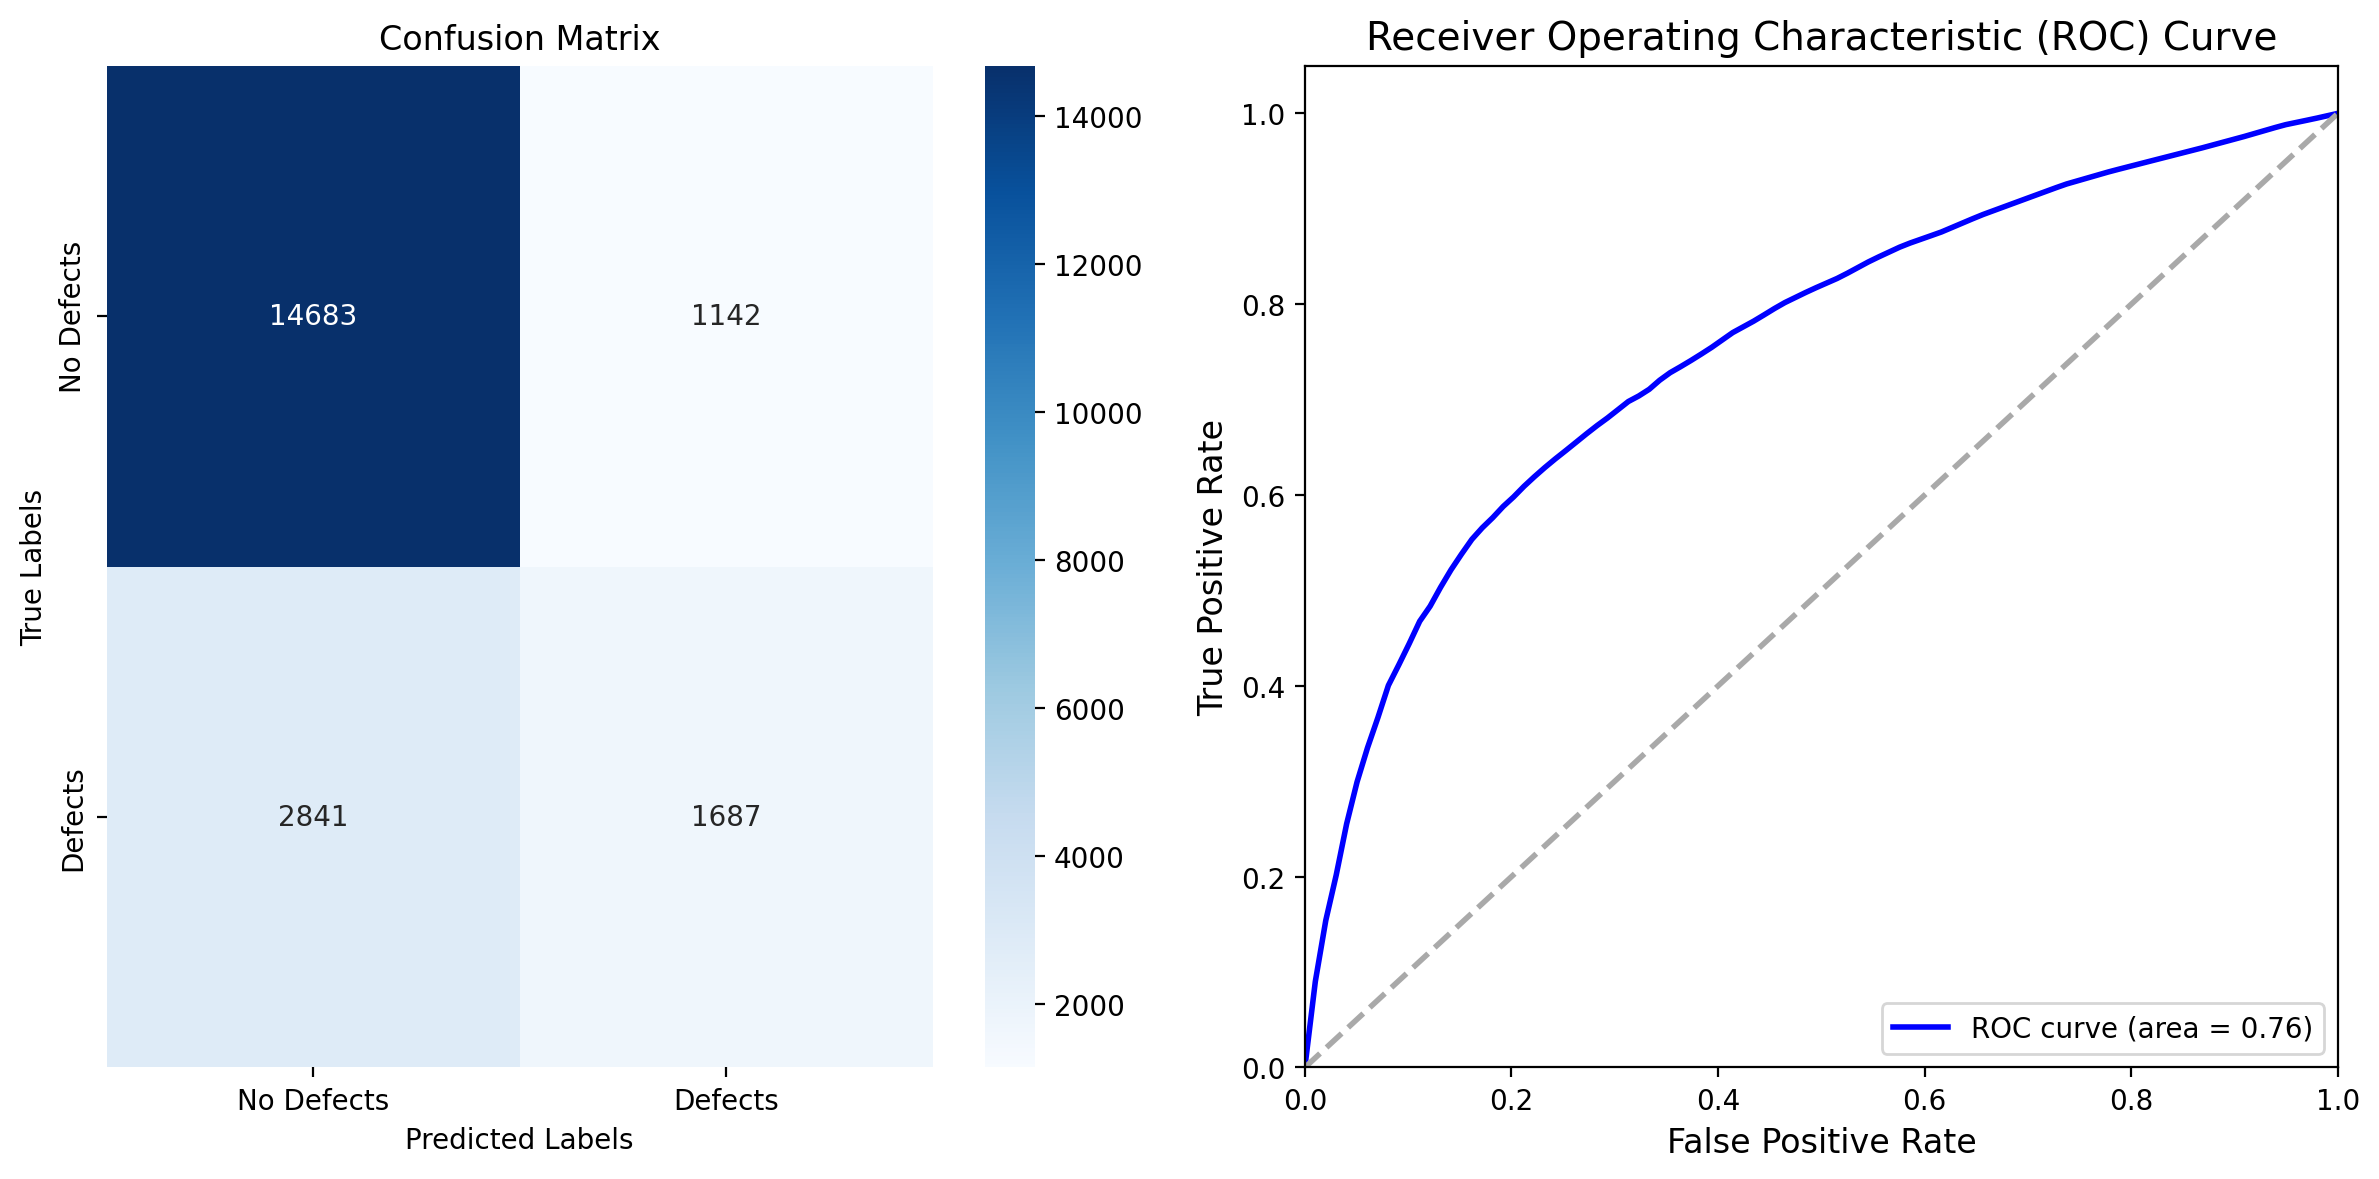

Intermediate Test Results (PCA): 
              precision    recall  f1-score   support

           0       0.84      0.93      0.88     15825
           1       0.60      0.37      0.46      4528

    accuracy                           0.80     20353
   macro avg       0.72      0.65      0.67     20353
weighted avg       0.78      0.80      0.79     20353

Intermediate Test AUC:  0.76


In [ ]:
# Evaluating the resulting model on the test set
report, auc = evaluate_model(rf_pca, X_test_pca, y_test)

print("Intermediate Test Results (PCA): ")
print(report)
print("Intermediate Test AUC: ", auc)

Based on the above metrics, we see that the performance our model on the PCA transformed data actually decreases. The model is now less capable of predicting both positive samples and negative samples. One plausible interpretation of this outcome is that PCA, while effectively reducing the dimensionality of the feature space, might discard critical information essential for the model's discriminatory power. The principal components retained after PCA may not encapsulate the key features contributing to the variability in the dataset, leading to a loss of performance. Therefore, we will continue to use our original data to do hyperparameter search on the Random Forest model.

----

In order to fully leverage the ability of random forest, we will then doing a hyperparameter search for the model. Specifically, we will search for five different hyperparameters of random forest which are crucial for the performance of the model.
- **max_depth**: This parameter controls the maximum depth of each decision tree in the forest. A deeper tree may capture more intricate patterns but is also more prone to overfitting.
- **min_samples_split**: It defines the minimum number of samples required to split an internal node. Setting an appropriate value helps control overfitting and enhances generalization.
- **max_leaf_nodes**: This parameter limits the maximum number of terminal nodes or leaves in each tree. It contributes to controlling the complexity of individual trees.
- **min_samples_leaf**: It sets the minimum number of samples required to be in a leaf node. Adjusting this parameter helps in preventing small leaf nodes that might capture noise in the data.
- **n_estimators**: This parameter determines the number of trees in the forest. Increasing the number of trees can lead to a more robust and stable model, but it also requires more computational costs.

Note: Since the search space for the hyperparameters of Random forest is quite larger (3 * 243 = 739 fits for every combination), which is very time-comsuming, we will instead using a **Random Search**. The benefit of a random search is that we are not trying every combination, but selecting at random to sample a wide range of values.

In [ ]:
#@title Hyperparemter Tuning for Random Forest
# Defining the parameter grid
param_grid = {"max_depth": [10, 20, 30],
                "min_samples_split": [2, 5, 10],
                "max_leaf_nodes": [100, 150, 200],
                "min_samples_leaf": [2, 5, 10],
                "n_estimators": [100, 200, 500],
              }


# Initializing Grid Search with cross-validation
grid_search = RandomizedSearchCV(RandomForestClassifier(random_state=seed), param_grid, scoring=['f1_weighted', 'roc_auc'], cv = 3, n_jobs = -1, verbose = 1, refit='f1_weighted')

# Fitting grid search
grid_search.fit(X_train, y_train)

# Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_leaf_nodes': 100, 'max_depth': 10}
Best Score: 0.7950220631872581


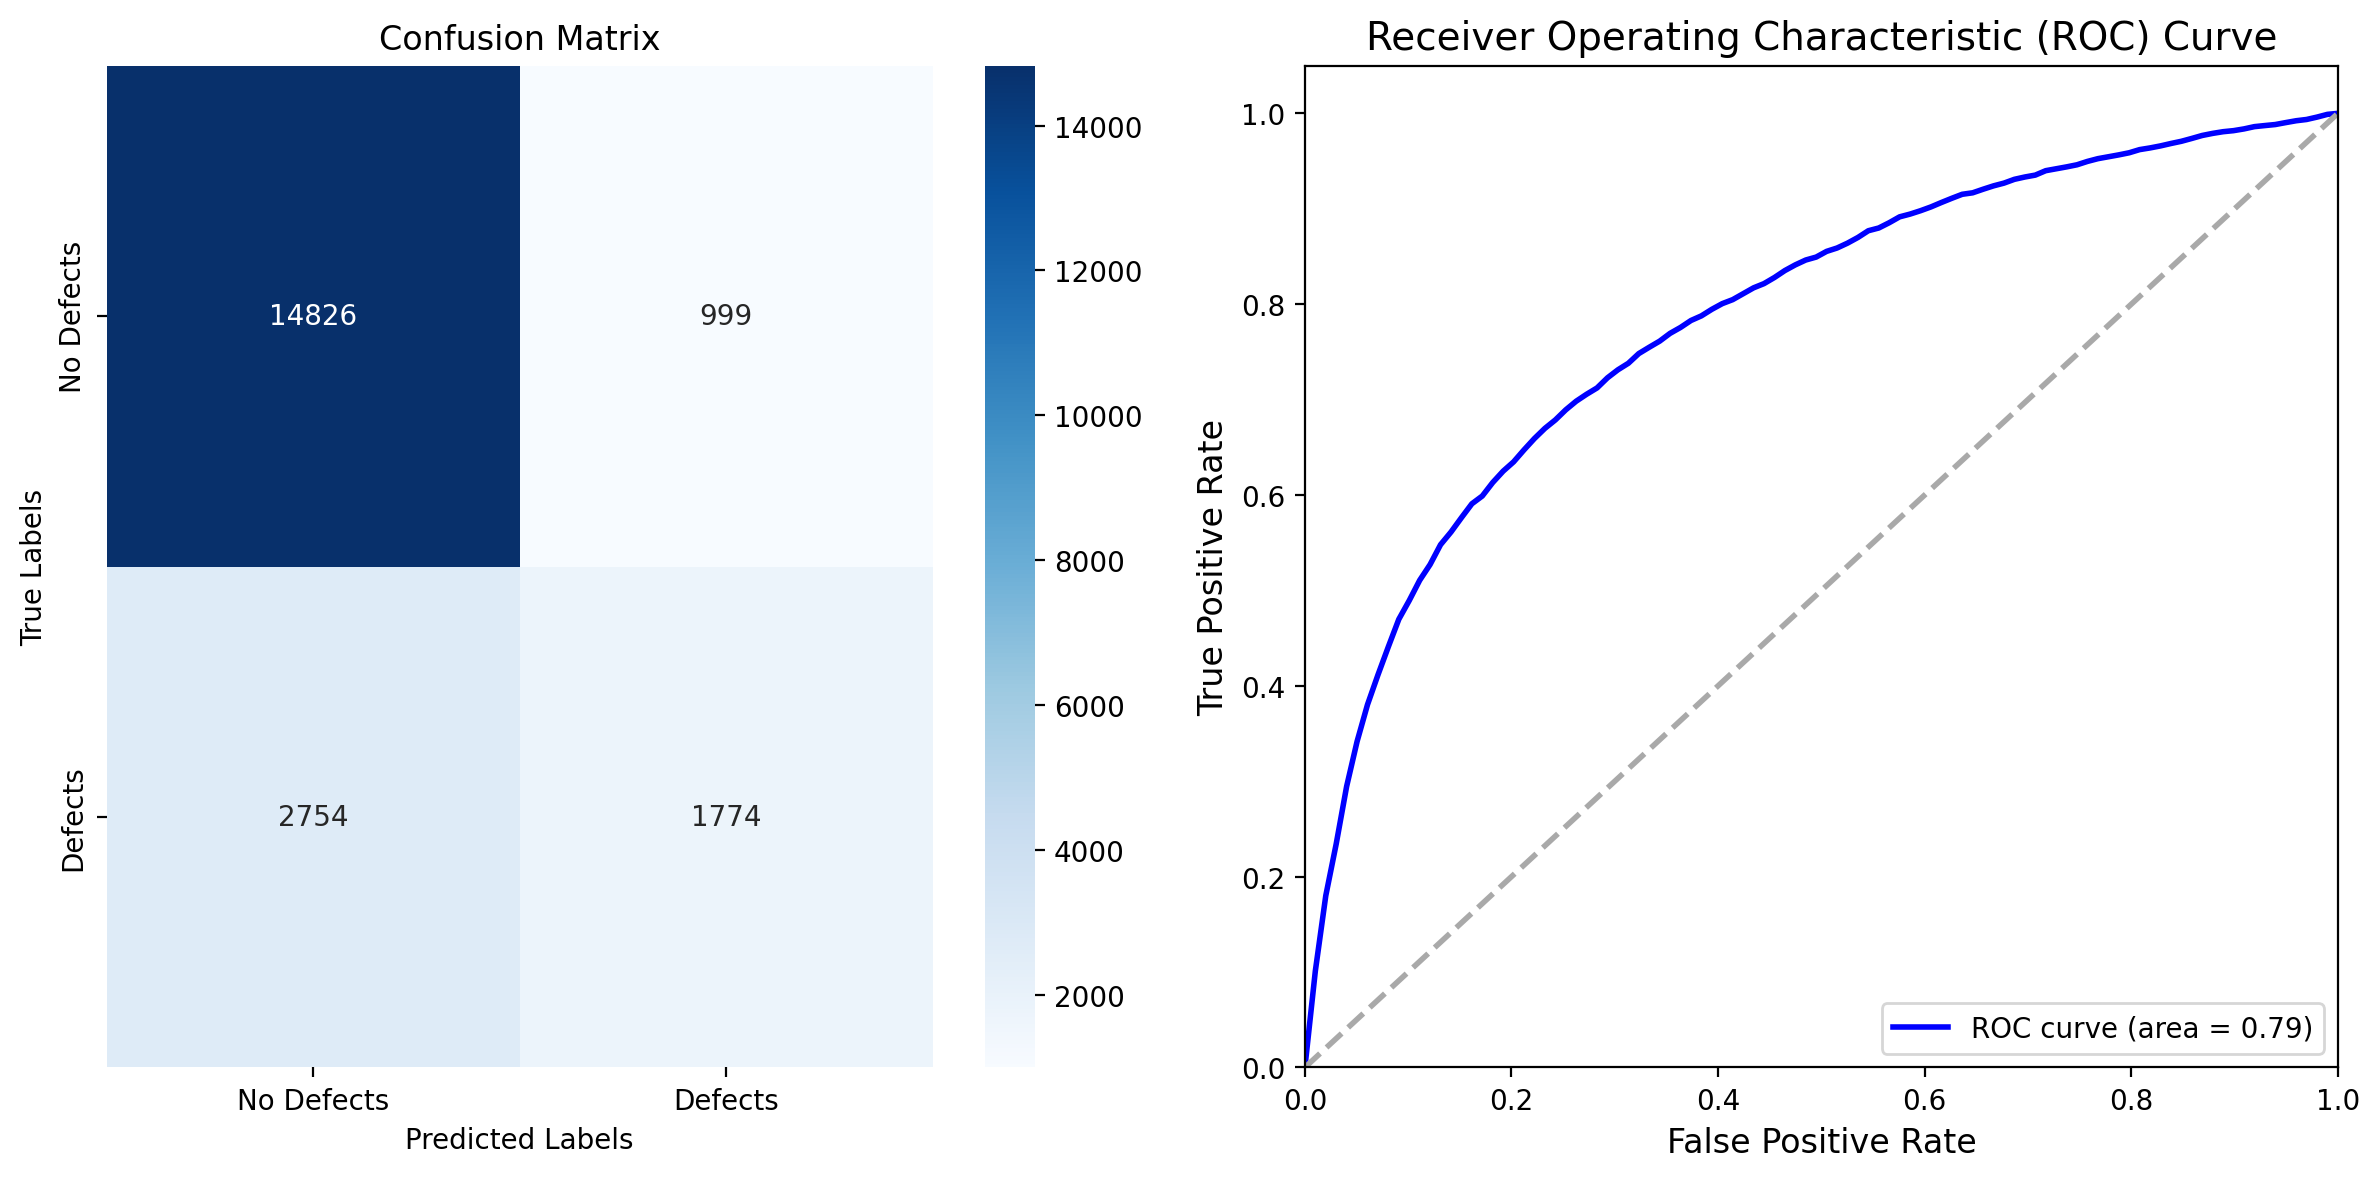

Baseline Test Results (Tuned): 
              precision    recall  f1-score   support

           0       0.84      0.94      0.89     15825
           1       0.64      0.39      0.49      4528

    accuracy                           0.82     20353
   macro avg       0.74      0.66      0.69     20353
weighted avg       0.80      0.82      0.80     20353

Baseline Test AUC:  0.79


In [ ]:
# Let's get the tuned Random Forest
rf_tuned = grid_search.best_estimator_

# Finally, let's evaluating the resulting model on the test set
report, auc = evaluate_model(rf_tuned, X_test, y_test)

print("Baseline Test Results (Tuned): ")
print(report)
print("Baseline Test AUC: ", auc)

Based on the above the metrics, we can see that the tuned random forest model outperforms the initial random forest model as well as the tuned logistic regression, which is good! However, based on the confusion matrix as well as the F1 score, we see that the model is still not perform optimally on the dataset, as there are sitll 20% of samples being misclassified. Let's try some other models!

Intermediate Model - Gradient Tree Boosting
---

To build more complex model on the dataset, we decide to build another tree structure model called Gradient Tree Boosting. Although this model is still considered as tree structured, it is quite different from random forest. The Gradient Tree Boosting model builds a sequence of decision trees in a staged manner. Unlike the parallel construction of trees in Random Forest, Gradient Tree Boosting model constructs trees sequentially, with each subsequent tree attempting to correct the errors made by the previous ones. This iterative process allows Gradient Tree Boosting to focus on capturing the residual errors and gradually improve the overall predictive performance. Let's see how it performs on our dataset!

In [ ]:
#@title Build Gradient Tree Boosting on orginal data
gb = GradientBoostingClassifier(random_state=seed)
gb.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

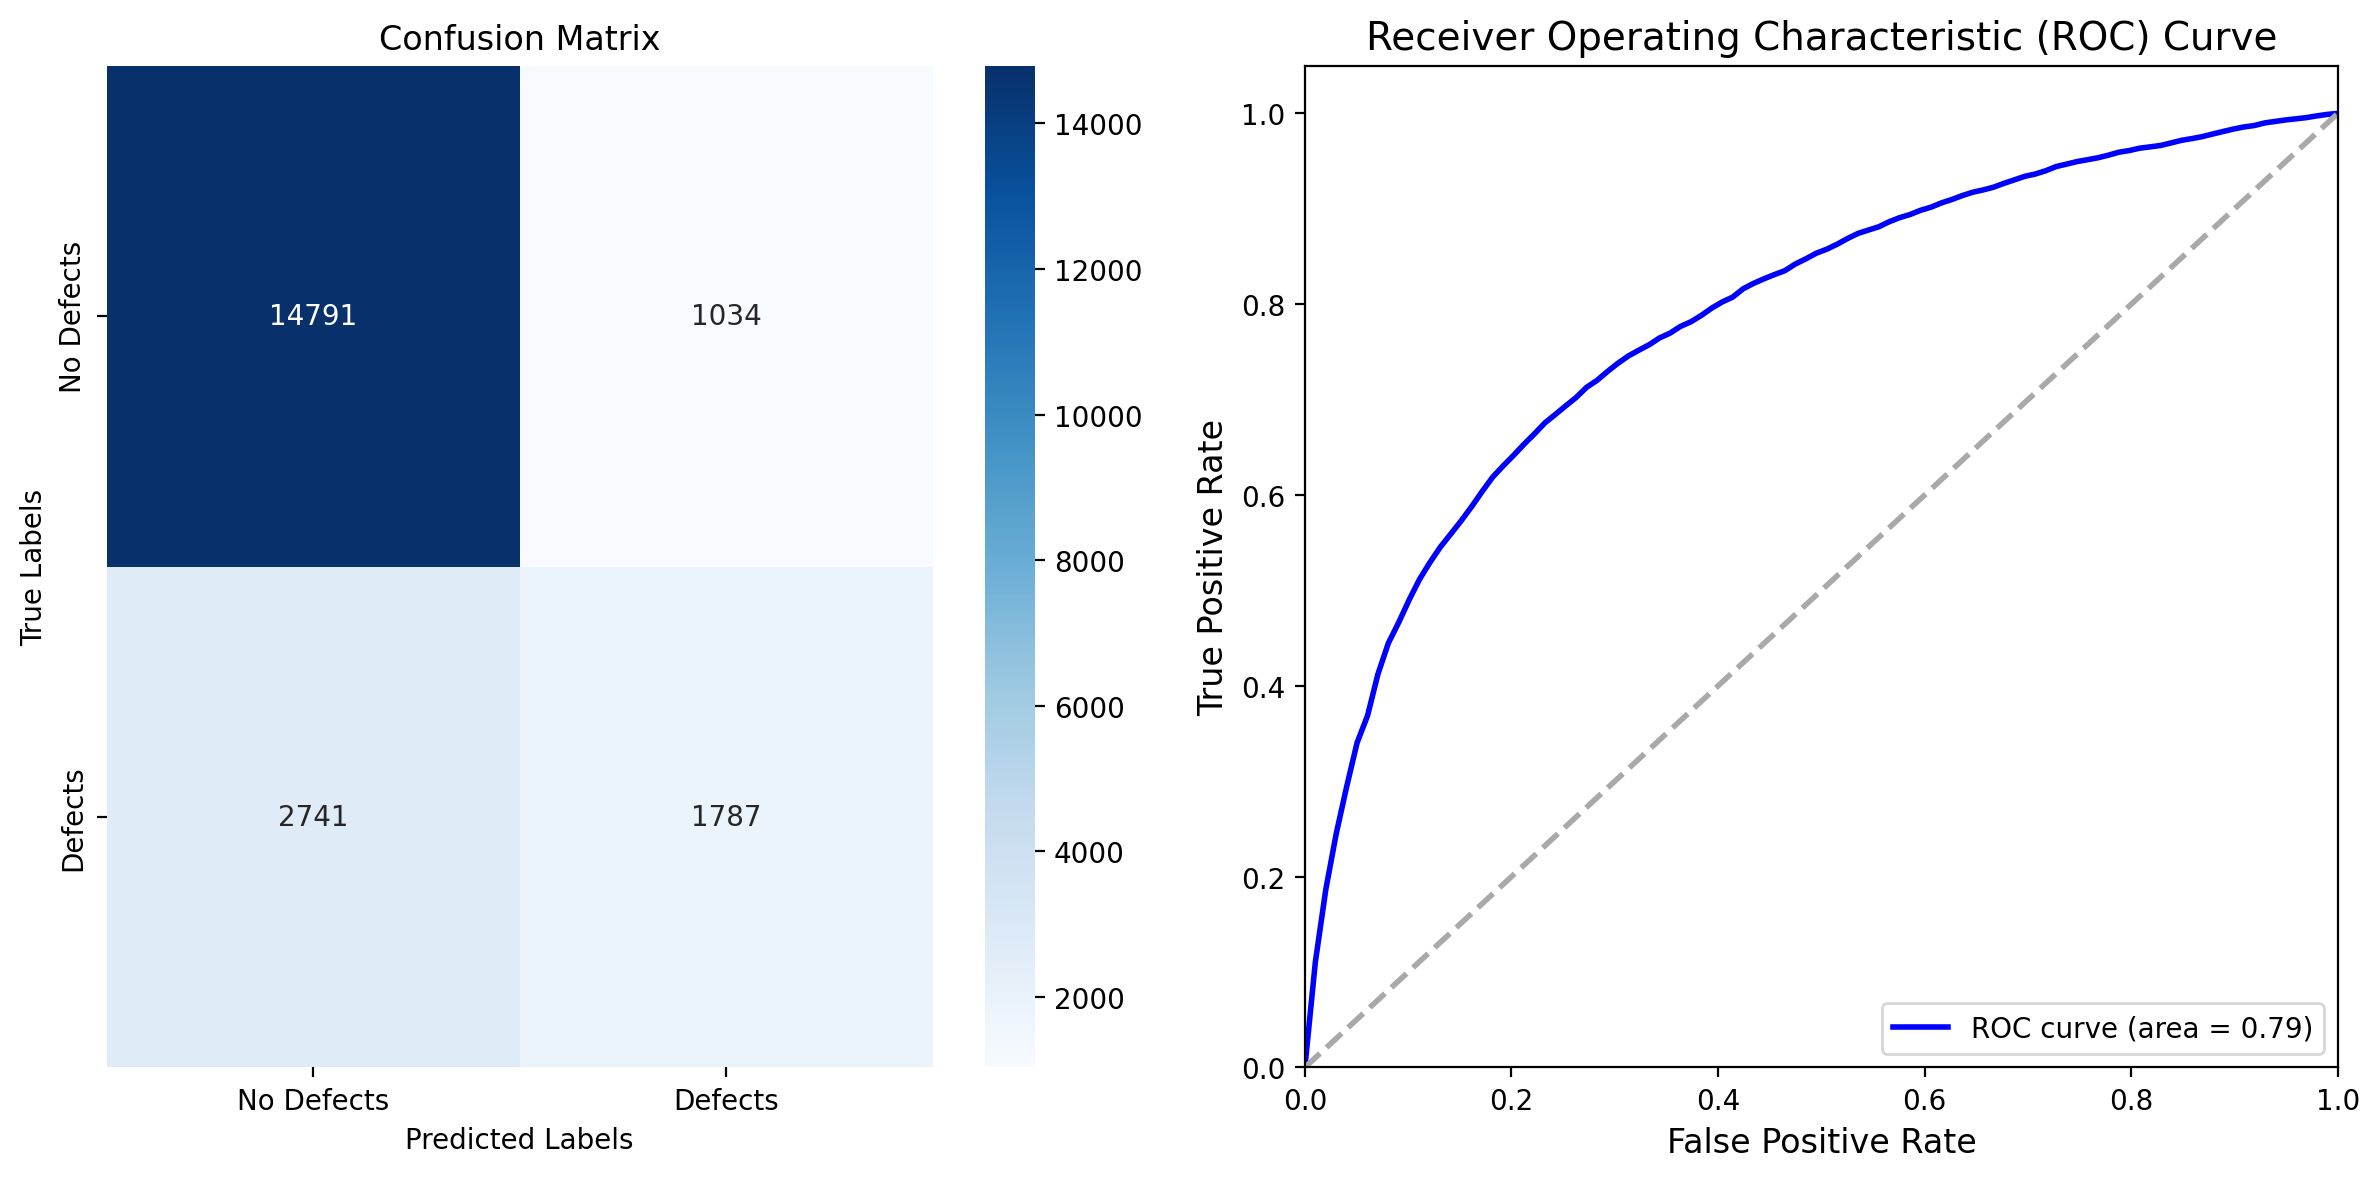

Intermediate Test Results: 
              precision    recall  f1-score   support

           0       0.84      0.93      0.89     15825
           1       0.63      0.39      0.49      4528

    accuracy                           0.81     20353
   macro avg       0.74      0.66      0.69     20353
weighted avg       0.80      0.81      0.80     20353

Intermediate Test AUC:  0.79


In [ ]:
# Evaluating the model on the test set
report, auc = evaluate_model(gb, X_test, y_test)

print("Intermediate Test Results: ")
print(report)
print("Intermediate Test AUC: ", auc)

Based on the above metircs, we see that the Gradient Tree Boosting model is even more capable on the prediction of defects. Without any hyperparameter tuning, the Gradient Tree Boosting model outperforms both tuned baseline logistic regression as well as the tuned Random Forest model in the previous step. The inherent nature of Gradient Tree Boosting that builds tree sequentially during the training process indeed improves our performance metrics on the task. Let's try to see how it performs on the PCA transformed data and how it goes after hyperparamter tuning!

In [ ]:
#@title Build Gradient Tree Boosting on PCA transfomred data
gb_pca = GradientBoostingClassifier(random_state=seed)
gb_pca.fit(X_train_pca, y_train)

GradientBoostingClassifier(random_state=42)

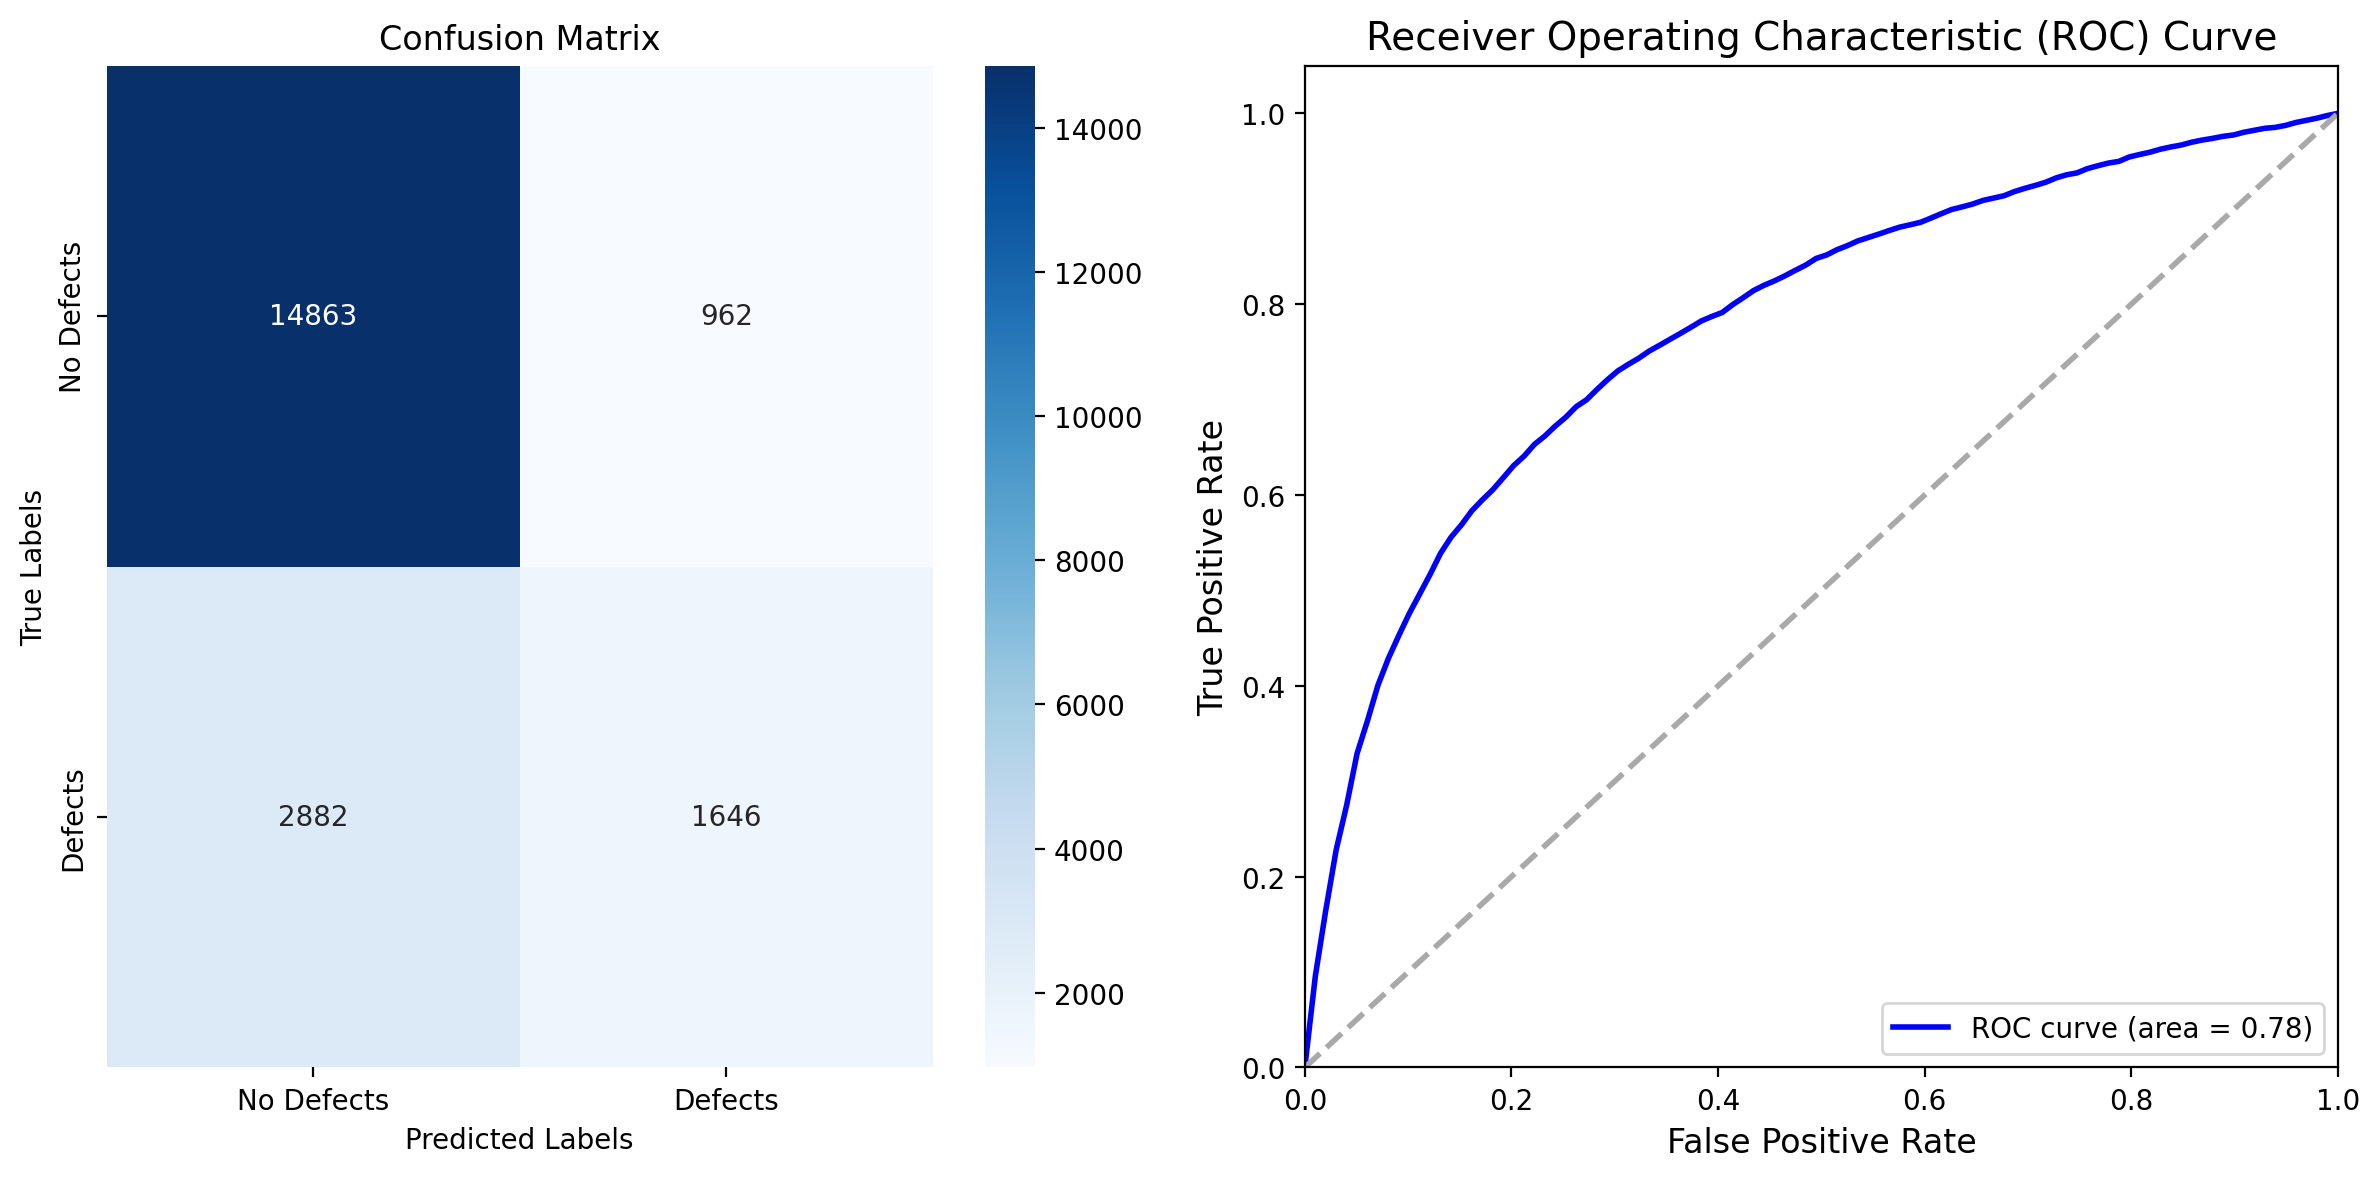

Intermediate Test Results (PCA): 
              precision    recall  f1-score   support

           0       0.84      0.94      0.89     15825
           1       0.63      0.36      0.46      4528

    accuracy                           0.81     20353
   macro avg       0.73      0.65      0.67     20353
weighted avg       0.79      0.81      0.79     20353

Intermediate Test AUC:  0.78


In [ ]:
# Evaluating the resulting model on the test set
report, auc = evaluate_model(gb_pca, X_test_pca, y_test)

print("Intermediate Test Results (PCA): ")
print(report)
print("Intermediate Test AUC: ", auc)

Based on the above metrics, we see that the performance of Gradient Tree Boosting on the PCA transformed data also decreases compared to what we got from the intial model. Therefore, we will also use original data to do our hyperparameter search for the Gradient Tree Boosting model!

---

In order to fully leverage the ability of Gradient Tree Boosting, we will again doing a hyperparameter search for the model. Specifically, we will search for five different hyperparameters of Gradient Tree Boosting which are crucial for the performance of the model.
- **learning_rate**: This parameter determines the step size at each iteration while moving toward a minimum of the loss function. A smaller learning rate typically requires more boosting rounds but may lead to better generalization.
- **max_depth**: The maximum depth of each decision tree in the ensemble. It controls the complexity of individual trees and, if set too high, may result in overfitting.
- **min_samples_split**: The minimum number of samples required to split an internal node. Higher values can prevent overfitting by avoiding splits on small subsets.
- **min_samples_leaf**: The minimum number of samples required to be in a leaf node. It regulates tree growth by setting the minimum size of terminal nodes.
- **n_estimators**: The number of boosting stages or trees to be built. Increasing this value adds more trees to the ensemble, potentially improving model performance, but it comes at the cost of increased computational complexity.

Note: Since the search space for the hyperparameters of Gradient Tree Boosting is also quite larger (3 * 243 = 739 fits for every combination), which is very time-comsuming, so we will again using the Random Search for this part.

In [ ]:
#@title Hyperparemter Tuning for Gradient Tree Boosting
# Defining the parameter grid
param_grid = {"learning_rate": [0.01, 0.1, 0.2],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 5],
            "max_depth":[3, 5, 10],
            "n_estimators":[100, 200, 500]
         }


# Initializing Grid Search with cross-validation
grid_search = RandomizedSearchCV(GradientBoostingClassifier(random_state=seed),
                           param_grid, scoring=['f1_weighted', 'roc_auc'], cv = 3, n_jobs = -1, verbose = 1, refit='f1_weighted')

# Fitting grid search
grid_search.fit(X_train, y_train)

# Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 3, 'learning_rate': 0.1}
Best Score: 0.7960730571258442


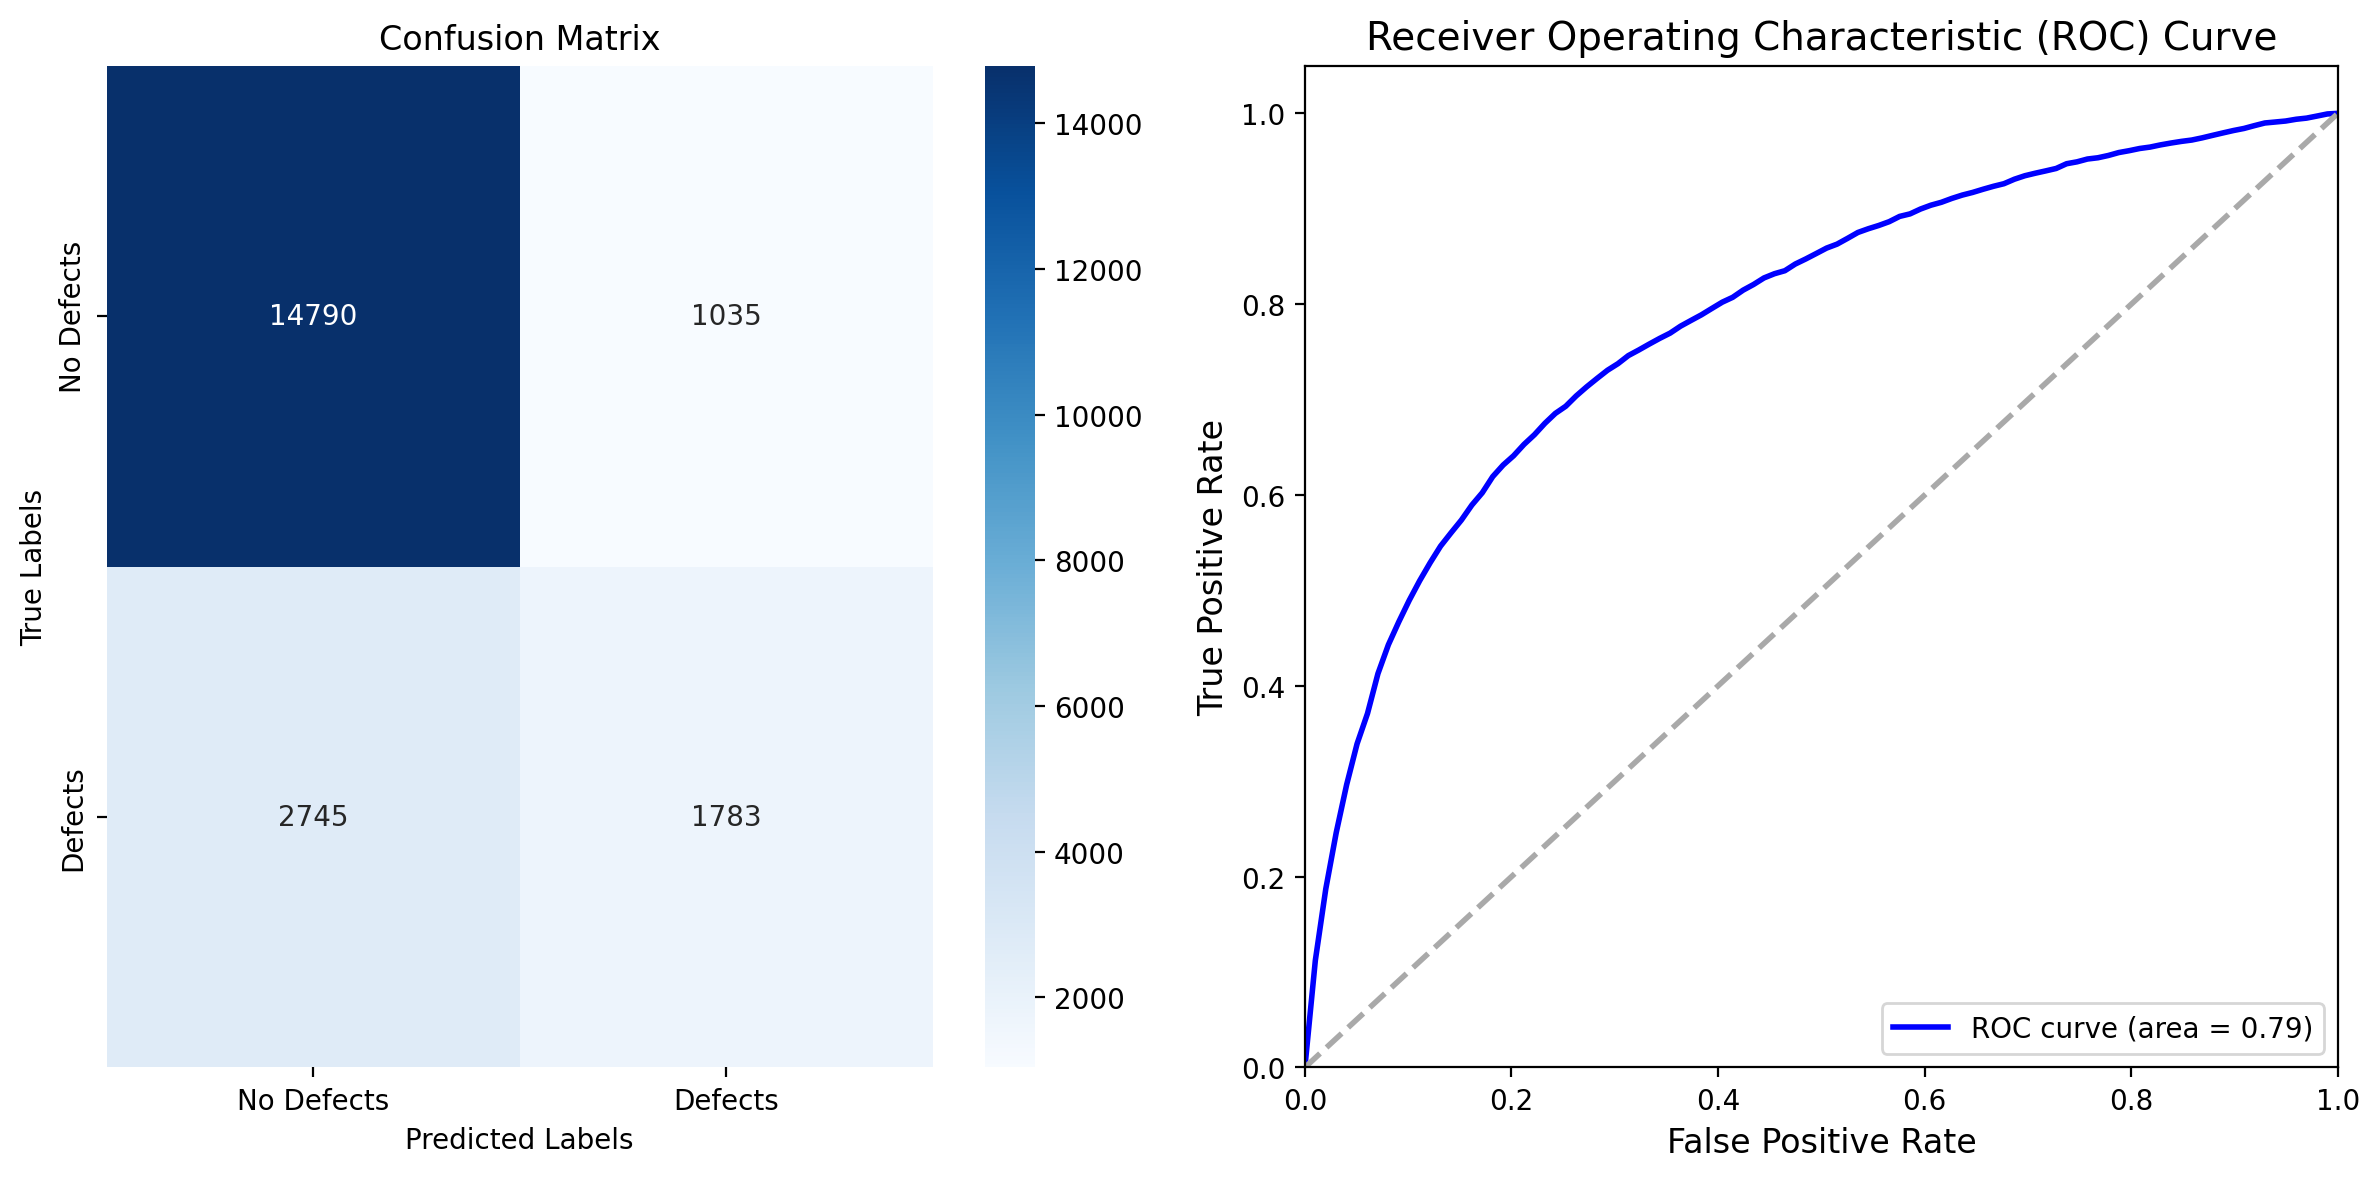

Baseline Test Results (Tuned): 
              precision    recall  f1-score   support

           0       0.84      0.93      0.89     15825
           1       0.63      0.39      0.49      4528

    accuracy                           0.81     20353
   macro avg       0.74      0.66      0.69     20353
weighted avg       0.80      0.81      0.80     20353

Baseline Test AUC:  0.79


In [ ]:
# Let's get the tuned Gradient Tree Boosting
gb_tuned = grid_search.best_estimator_

# Finally, let's evaluating the resulting model on the test set
report, auc = evaluate_model(gb_tuned, X_test, y_test)

print("Baseline Test Results (Tuned): ")
print(report)
print("Baseline Test AUC: ", auc)

Based on the above the metrics, we can see that the tuned Gradient Tree Boosting does not improve after doing the hyperparemeter search. Firstly, it's possible that the default hyperparameters of the Gradient Tree Boosting model were already near optimal for the given dataset, leaving limited room for significant enhancement through tuning. Additionally, the dataset characteristics may not allow the full strengths of the Gradient Tree Boosting algorithm on this task. It is also conceivable that the chosen hyperparameter grid for the search might not have covered the most beneficial combinations, necessitating a more exhaustive exploration. For now, why not explore more!

---


Note that the training of Gradient Tree Boosting takes very long time. Therefore, one potential direction could be trying some other more efficient and powerful boosting model - XGBoost, which will be coming in the next step.

Intermediate Model - XGBoost Classifier
---

For the last intermediate model, we will implement the XGBoost Classifier. XGBoost, short for eXtreme Gradient Boosting, is a powerful and widely used machine learning algorithm that belongs to the ensemble learning family. XGBoost is an ensemble of decision trees that are trained sequentially, each tree correcting the errors of its predecessor. It incorporates regularization techniques to prevent overfitting and employs a gradient boosting framework, optimizing the model's performance by minimizing a specified loss function. This model is quite similar to Gradient Tree Boosting, but it is known for its enhanced efficiency and scalability. Let's try it out!

In [ ]:
#@title Build XGBoost Classifier on orginal data
xgb = XGBClassifier(random_state=seed)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

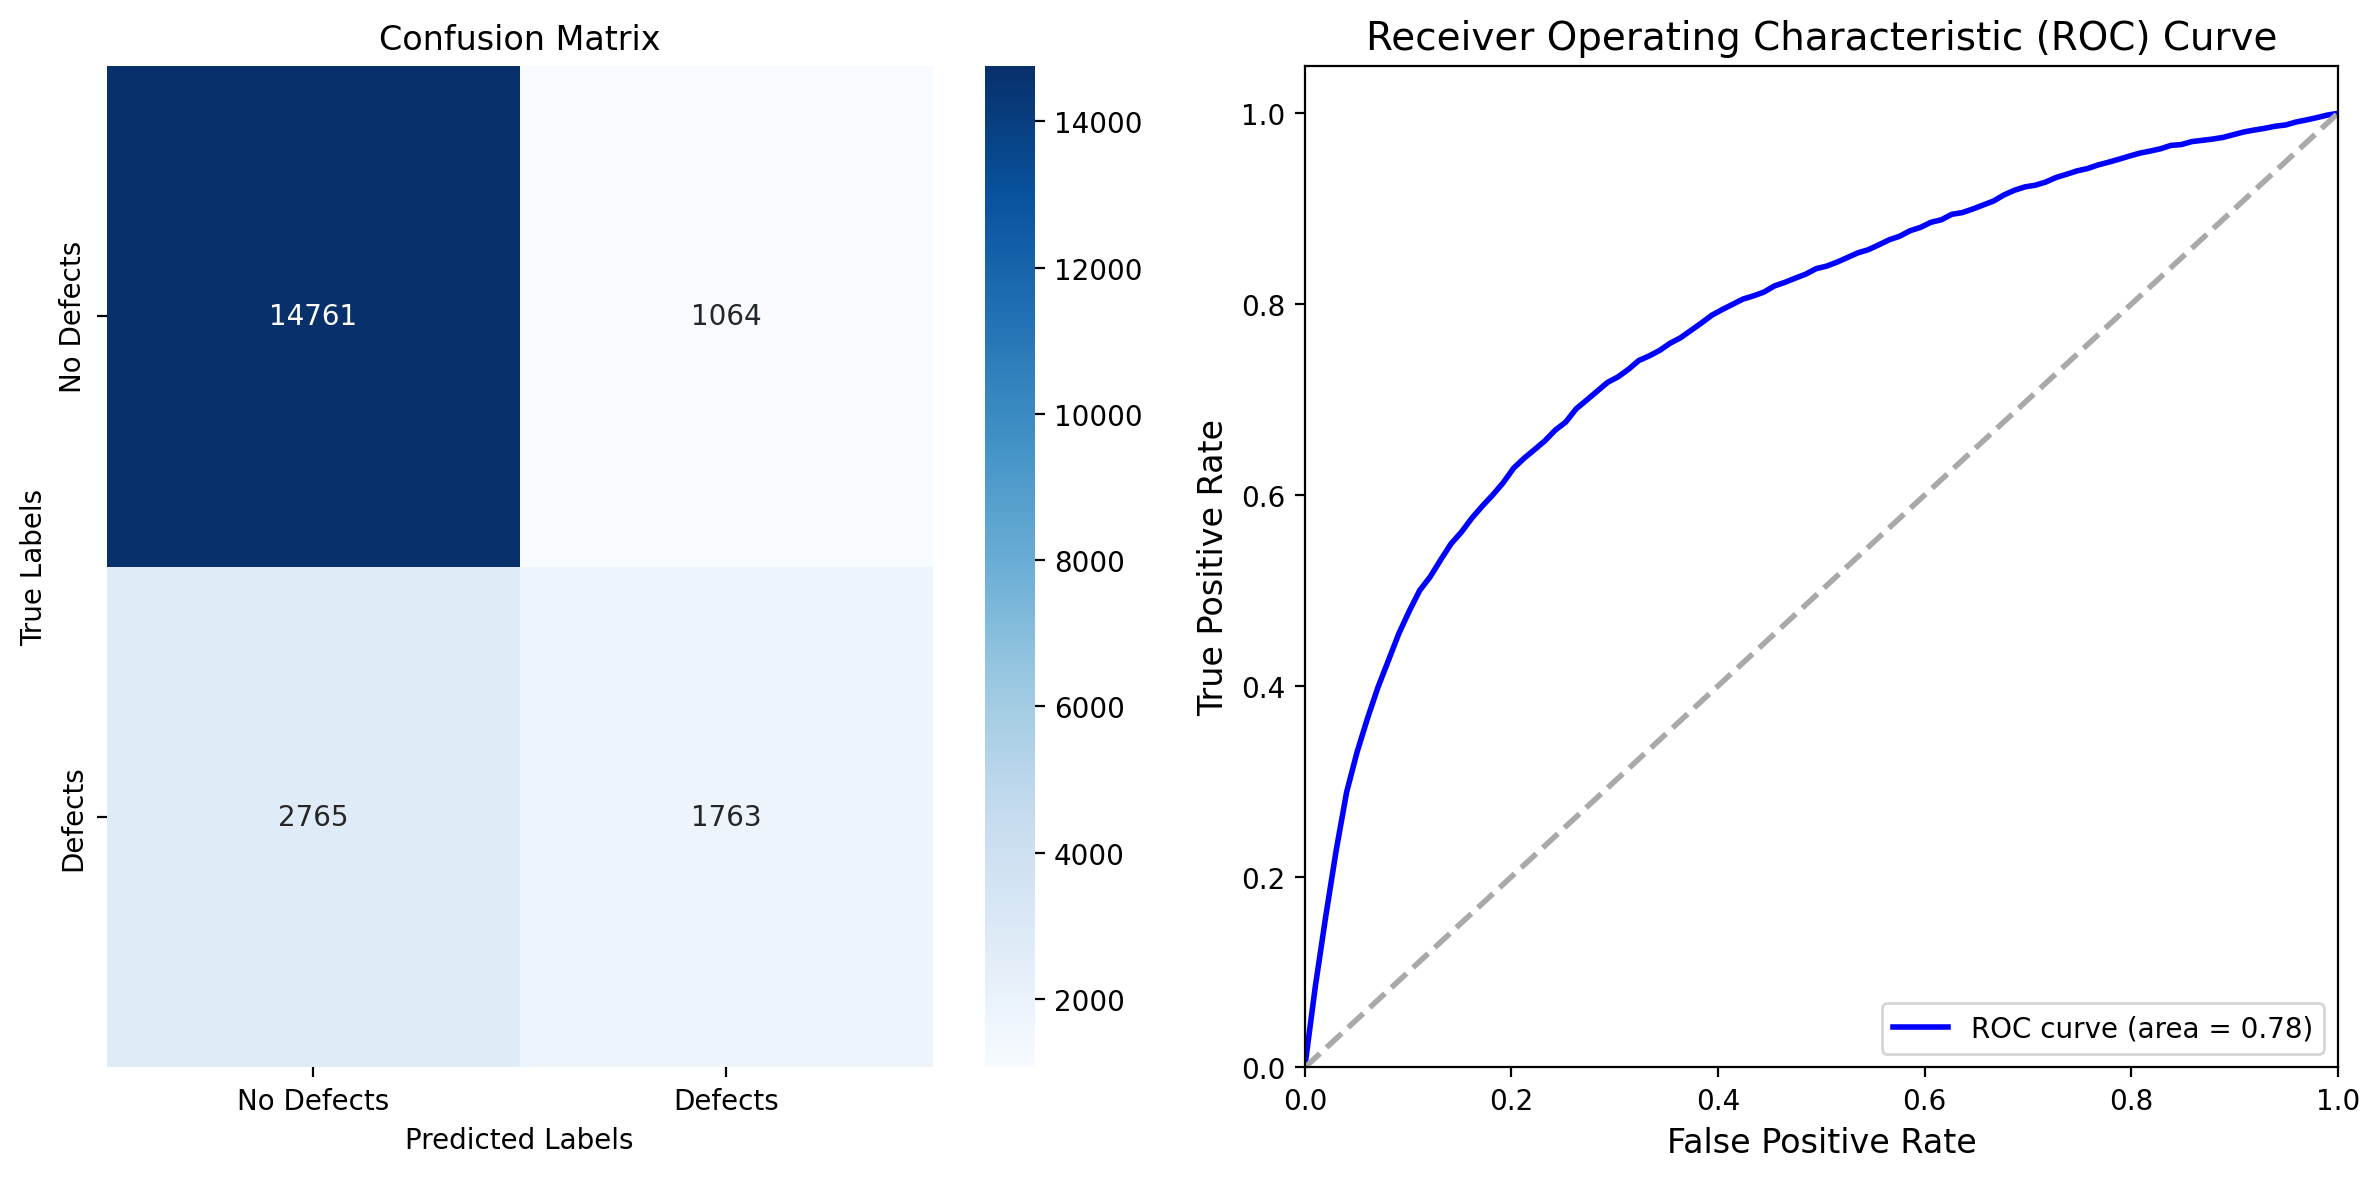

Intermediate Test Results: 
              precision    recall  f1-score   support

       False       0.84      0.93      0.89     15825
        True       0.62      0.39      0.48      4528

    accuracy                           0.81     20353
   macro avg       0.73      0.66      0.68     20353
weighted avg       0.79      0.81      0.79     20353

Intermediate Test AUC:  0.78


In [ ]:
# Evaluating the model on the test set
report, auc = evaluate_model(xgb, X_test, y_test)

print("Intermediate Test Results: ")
print(report)
print("Intermediate Test AUC: ", auc)

Based on the above metrics, we see that the performance of XGBoost remains almost the same as the untuned Gradient Tree Boosting. However, one thing to notice that XGBoost takes less training time compared to Gradient Tree Boost due to its efficency. Also, it is worth noticing that untuned XGBoost misclassified more positive samples compared to untuned Gradient Tree Boosting. Some explanation might be XGBoost is more capable of learning the undelying data patterns, in which it better performs on the training set while leading to a slight overfit on the data. Individual ensemble might be overfit on the local region, causing its deteroriated overall performance. Therefore, we want to tune the XGBoost in the next step to see any potential improvement. Before that, let's see how XGBoost performs on the PCA transformed data.

In [ ]:
#@title Build XGBoost Classifier on PCA transfomred data
xgb_pca = XGBClassifier(random_state=seed)
xgb_pca.fit(X_train_pca, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

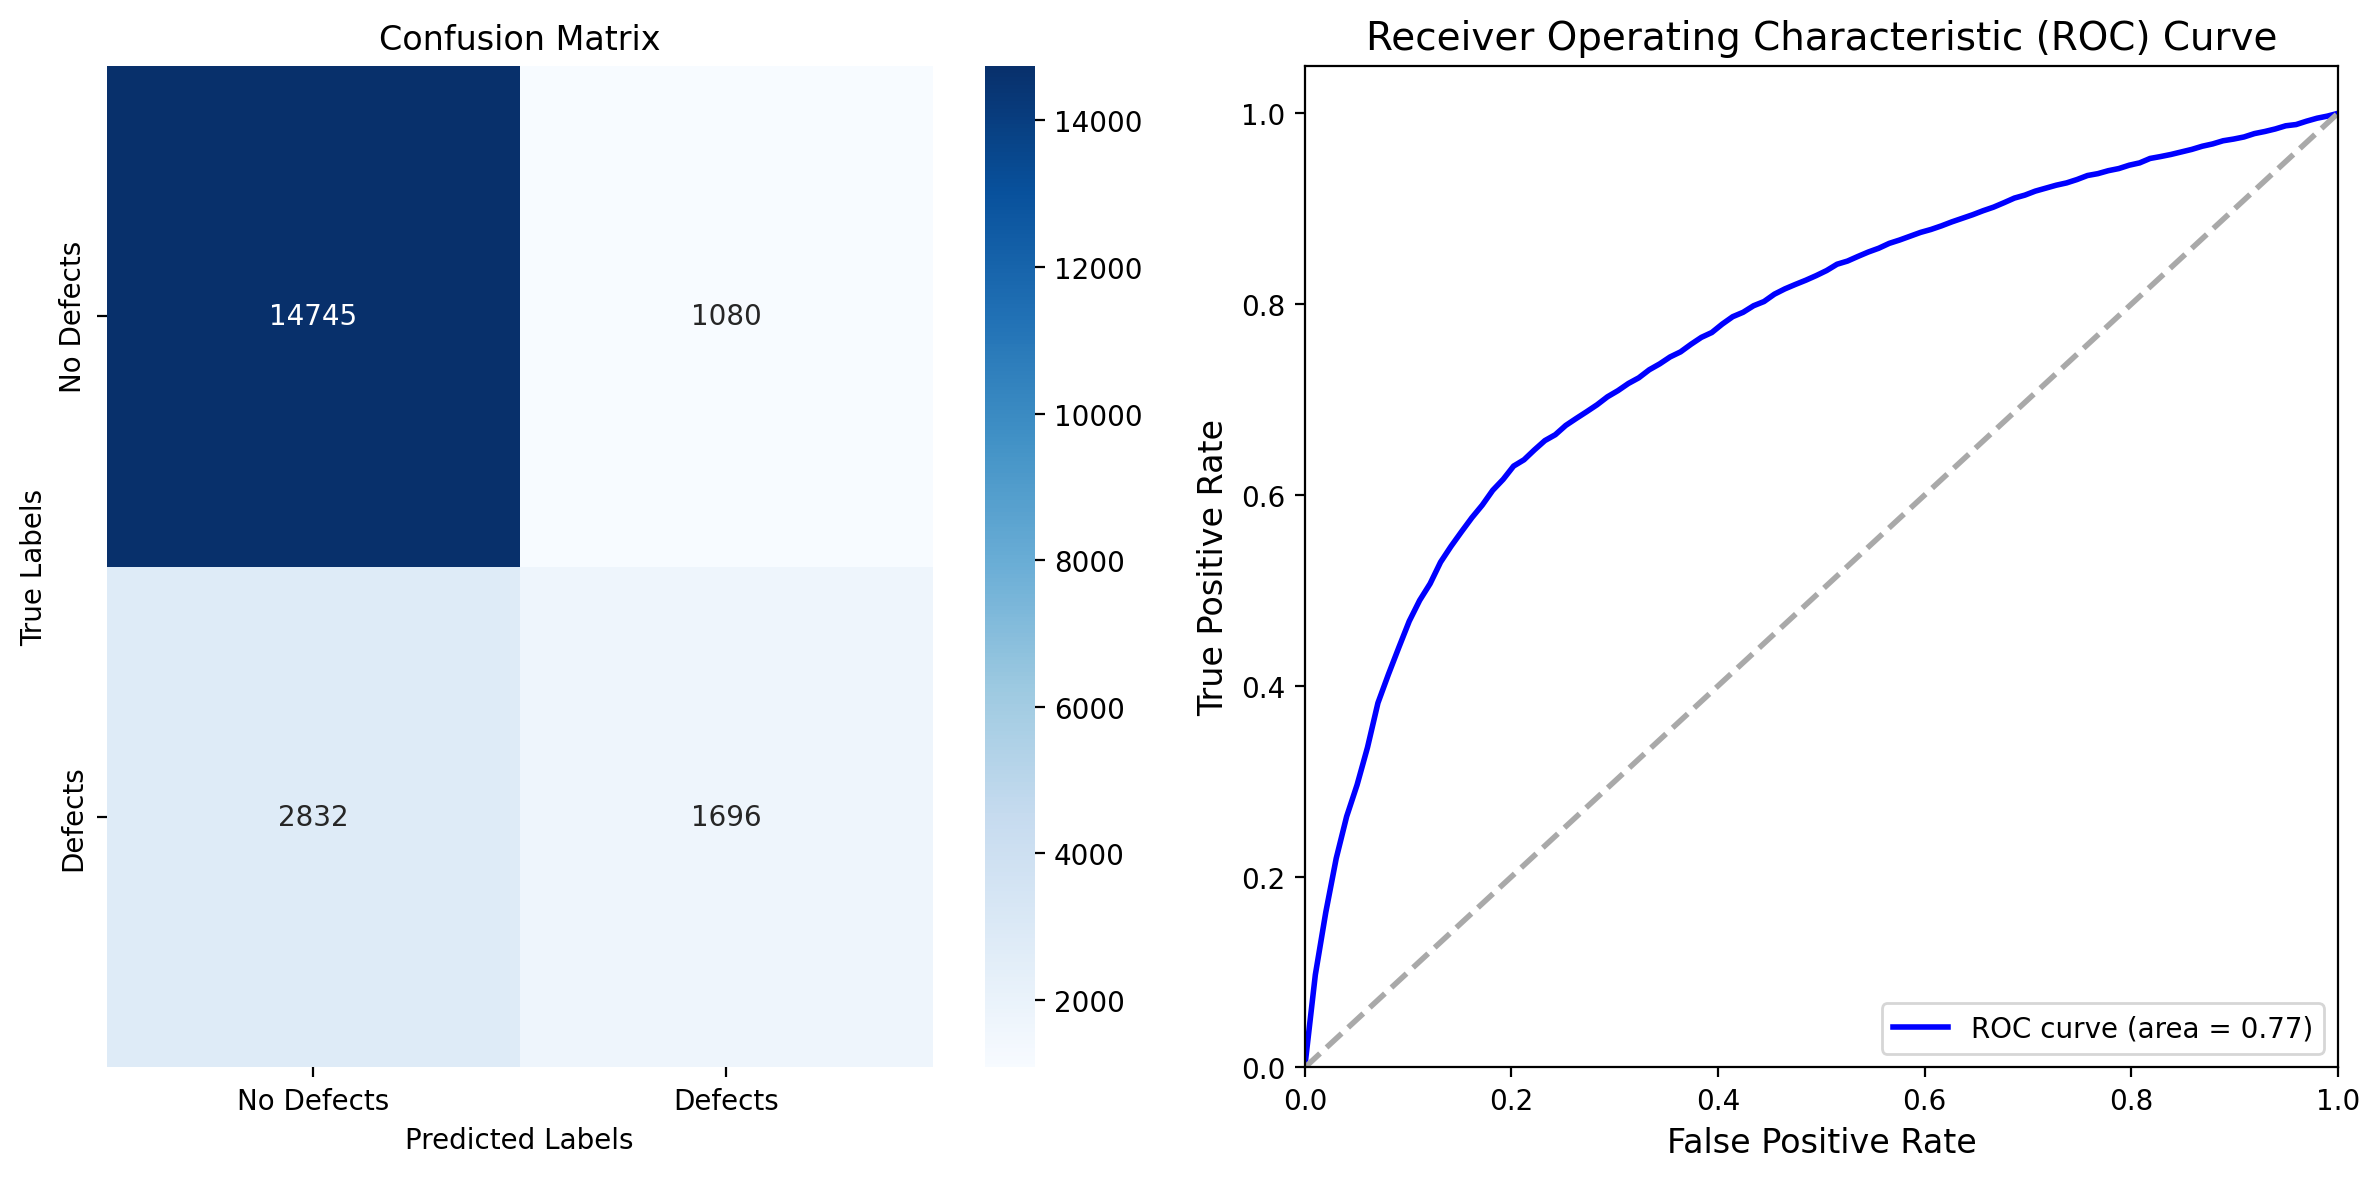

Intermediate Test Results (PCA): 
              precision    recall  f1-score   support

       False       0.84      0.93      0.88     15825
        True       0.61      0.37      0.46      4528

    accuracy                           0.81     20353
   macro avg       0.72      0.65      0.67     20353
weighted avg       0.79      0.81      0.79     20353

Intermediate Test AUC:  0.77


In [ ]:
# Evaluating the resulting model on the test set
report, auc = evaluate_model(xgb_pca, X_test_pca, y_test)

print("Intermediate Test Results (PCA): ")
print(report)
print("Intermediate Test AUC: ", auc)

Based on the above metrics, we see that same as Gradient Tree Boosting, XGBoost actually performs worse on the feature selected data. This might futher approve that our data is not suitable for PCA as this process might loss some key information for tree-structured model to make predictions. Therefore, we will continue doing our hyperparameter search on the original data for XGBoost model.


---


In order to fully leverage the ability of XGBoost Classifier, we will again doing a hyperparameter search for the model. Specifically, we will search for three different hyperparameters of XGBoost Classifier which are crucial for the performance of the model.
- **n_estimators**: This parameter determines the total number of boosting rounds or trees in the ensemble. Adjusting the number of trees can impact the model's complexity and generalization.
- **max_depth**: The maximum depth of each individual tree in the ensemble. Controlling the depth helps prevent overfitting and influences the granularity of feature interactions.
- **learning_rate**: It regulates the contribution of each tree to the final prediction and it plays a crucial role in the convergence speed and overall performance of the model.

For this part, we will still use Grid Search for the hyperparameter tuning due to the efficiency of XGBoost.

In [ ]:
#@title Hyperparemter Tuning for XGBoost Classifier
# Defining the parameter grid
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [5, 10, 100],
    'learning_rate': [0.01, 0.05, 0.1]
}


# Initializing Grid Search with cross-validation
grid_search = GridSearchCV(XGBClassifier(random_state=seed),
                           param_grid, scoring=['f1_weighted', 'roc_auc'], cv = 3, n_jobs = -1, verbose = 1, refit='f1_weighted')

# Fitting grid search
grid_search.fit(X_train, y_train)

# Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 1000}
Best Score: 0.7954336999443371


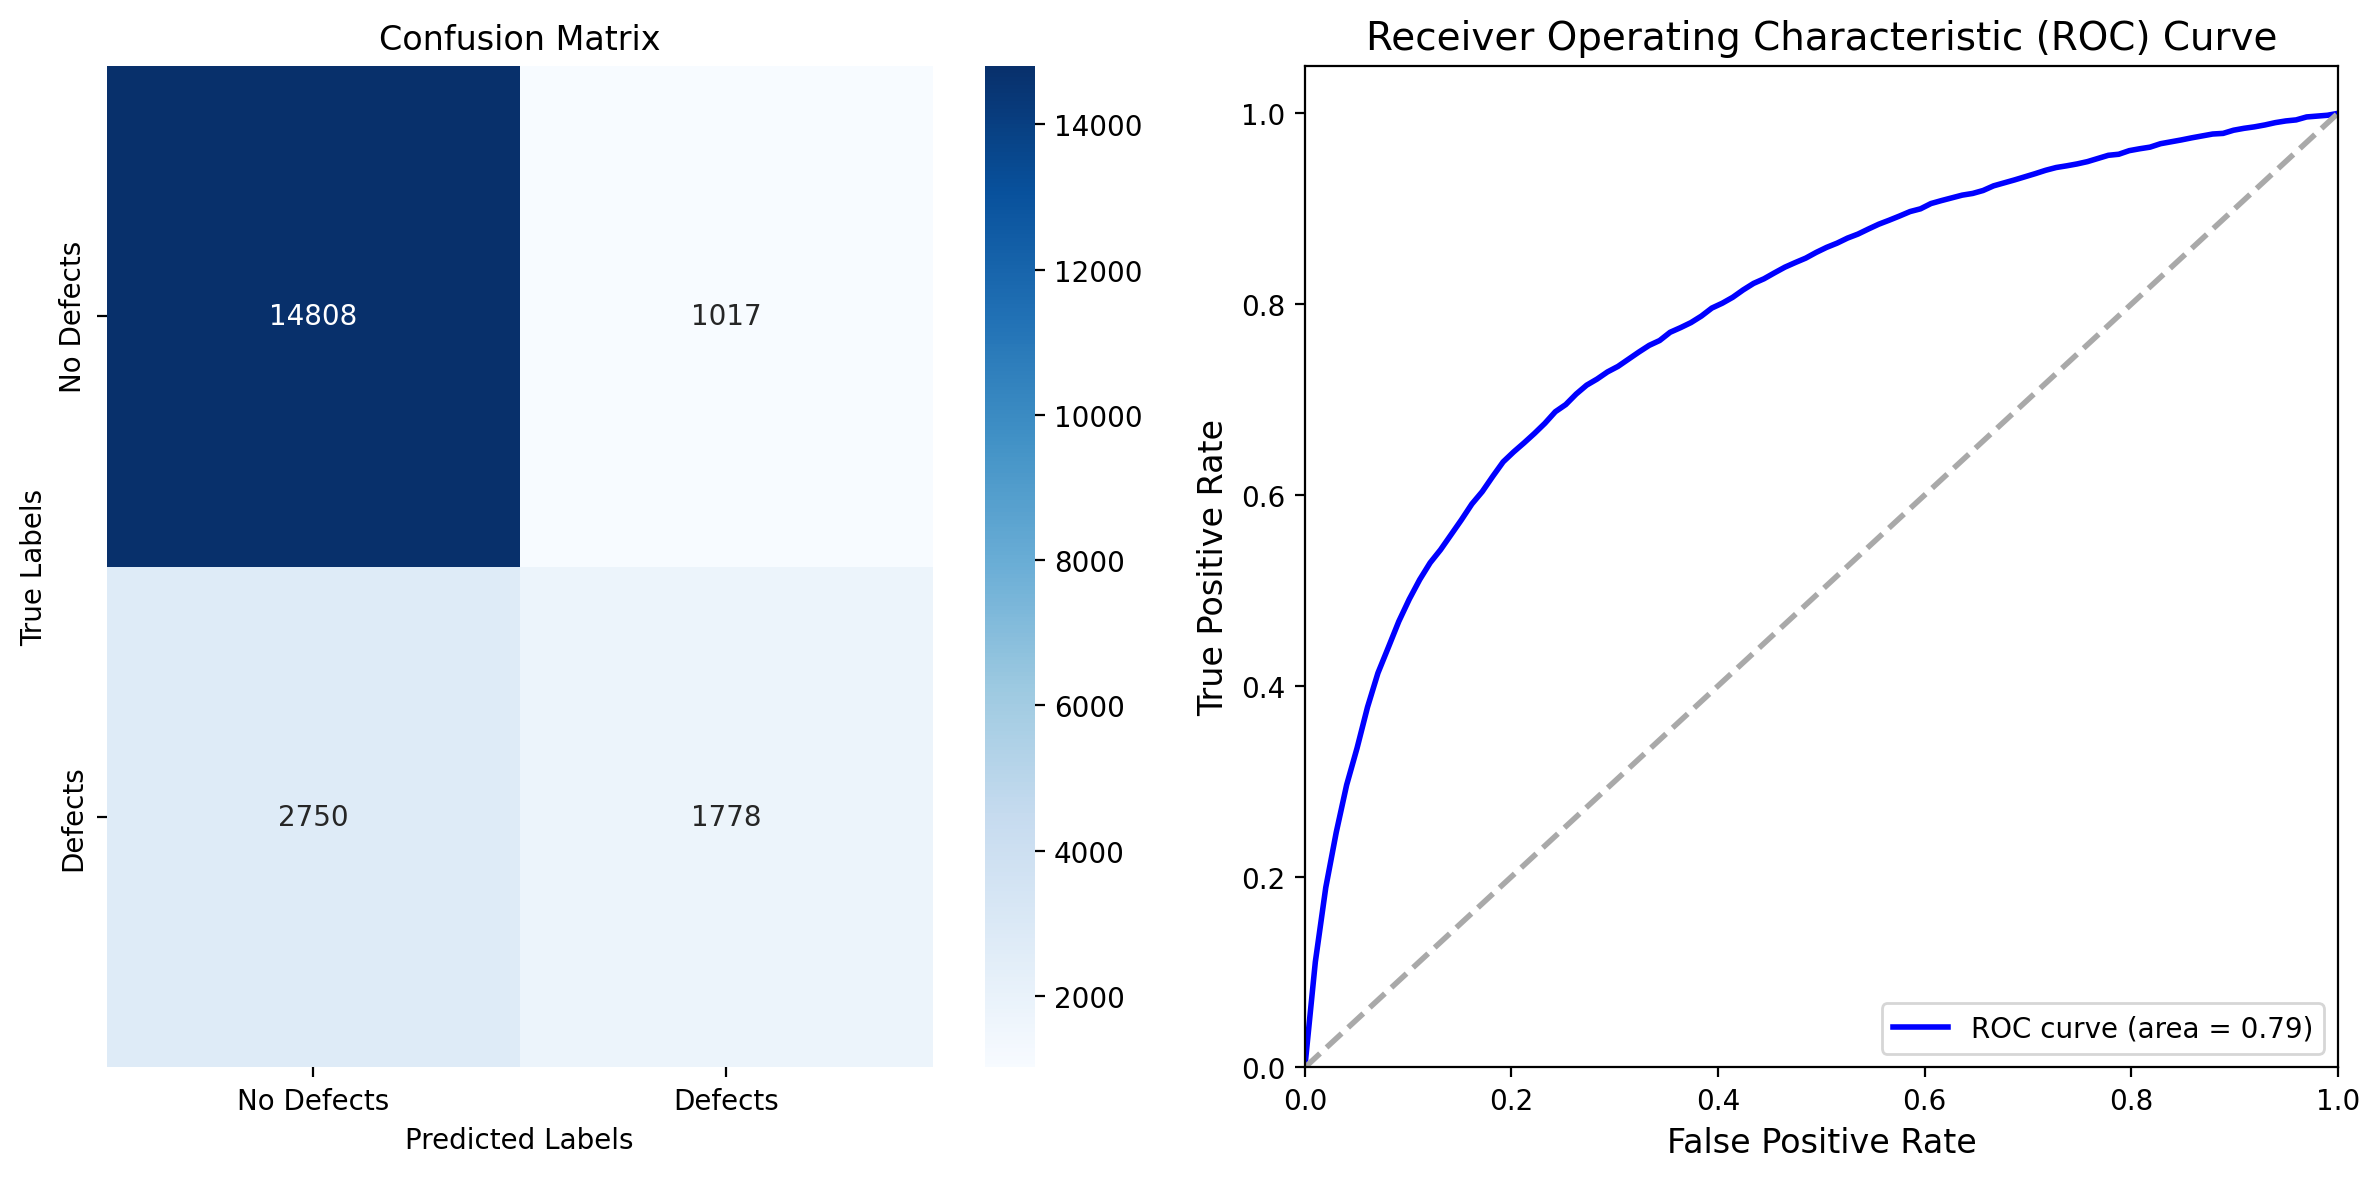

Baseline Test Results (Tuned): 
              precision    recall  f1-score   support

       False       0.84      0.94      0.89     15825
        True       0.64      0.39      0.49      4528

    accuracy                           0.81     20353
   macro avg       0.74      0.66      0.69     20353
weighted avg       0.80      0.81      0.80     20353

Baseline Test AUC:  0.79


In [ ]:
# Let's get the tuned XGBoost Classifier
xgb_tuned = grid_search.best_estimator_

# Finally, let's evaluating the resulting model on the test set
report, auc = evaluate_model(xgb_tuned, X_test, y_test)

print("Baseline Test Results (Tuned): ")
print(report)
print("Baseline Test AUC: ", auc)

Based on the above metics, we see that the performance remain the same compare to the tuned Gradient Tree Boosting, but with more efficient and stablized learning process. Indeed, it is worth trying to build even more complex and deeper model for our prediction. Stay tuned!

# Feature Engineering (Data Augmentation)
---

Before we build even deeper models, let's do a further feature engineering on our data in addition to the Normalization(StandardScalar) & Dimensionality Reduction(PCA). As we observed in the EDA process, our data is imbalanced in terms of the target variable (True/False Defects). Therefore, we want to make the data balanced by doing data augmentation on the dataset. This is done through the help of a package called, [SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html). (oversampling)

In [ ]:
#@title Doing data augmentation to balance the training dataset

# Initialize the SMOTE object
sm = SMOTE(random_state=seed, n_jobs=-1)
X_train_aug, y_train_aug = sm.fit_resample(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


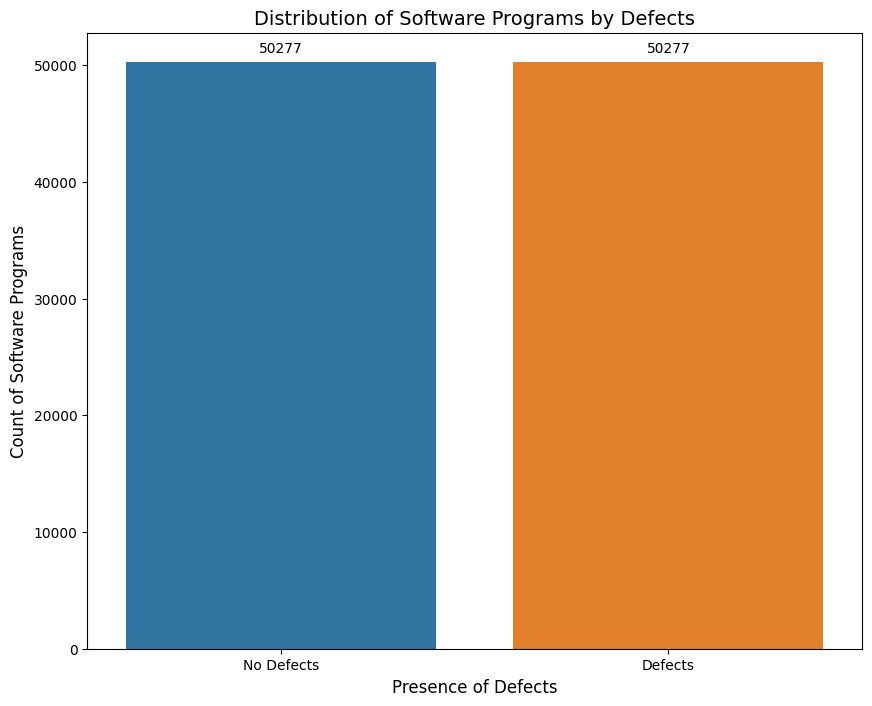

In [ ]:
#@title Plot the histogram of the training dataset
plt.figure(figsize=(10, 8))

ax = sns.countplot(x=y_train_aug)
plt.title('Distribution of Software Programs by Defects', fontsize=14)
plt.xlabel('Presence of Defects', fontsize=12)
plt.ylabel('Count of Software Programs', fontsize=12)
plt.xticks([0, 1], ['No Defects', 'Defects'])

# Add annotations on top of the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.show()

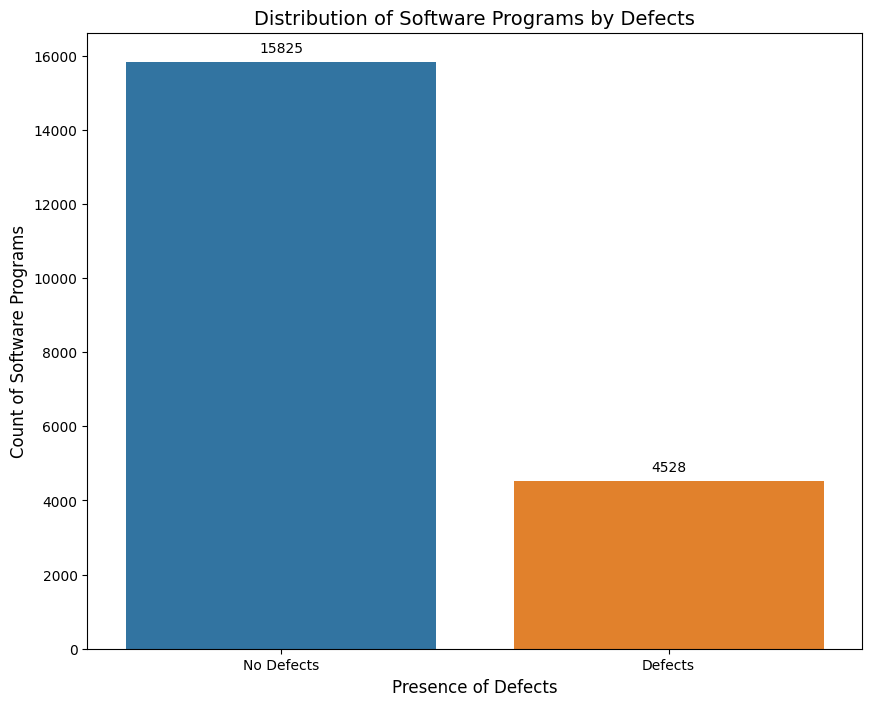

In [ ]:
#@title Plot the histogram of the testing dataset
plt.figure(figsize=(10, 8))

ax = sns.countplot(x=y_test)
plt.title('Distribution of Software Programs by Defects', fontsize=14)
plt.xlabel('Presence of Defects', fontsize=12)
plt.ylabel('Count of Software Programs', fontsize=12)
plt.xticks([0, 1], ['No Defects', 'Defects'])

# Add annotations on top of the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.show()

Now, from the above histograms, we see that our training dataset is balanced after SMOTE, but the testing dataset is untouched for the following reasons:

- **Avoiding Data Leakage:** When we apply SMOTE or any form of data augmentation to our test or validation set, there's a risk of data leakage. This happens when information from our training data unintentionally influences the test data, resulting in overly optimistic and non-generalizable performance metrics. We ensure that our test data is a completely independent sample to accurately evaluate our model's performance.

- **Preserving Original Data Distribution:** Our test and validation sets are designed to assess how well our model generalizes to new, unseen data. In real-life scenarios, our model will encounter data with its original distribution, not a synthetically balanced one. Therefore, we maintain the test and validation data to reflect the true distribution of real-world data.

- **Purpose of SMOTE:** We use SMOTE to address the issue of class imbalance in our training data. It synthesizes new examples from the minority class, creating a balanced dataset. This approach improves our model's learning of the characteristics of the minority class, which may be underrepresented in the original dataset.

- **Evaluation Integrity:** If we alter the test data distribution using techniques like SMOTE, we're no longer evaluating our model's performance against a realistic scenario. The metrics we obtain would not accurately represent our model's ability to perform on actual, imbalanced data as typically found in real-world applications.

In [ ]:
#@title Redo StandardScaler to Transform the Dataset
# Instantiate the StandardScaler
scaler = StandardScaler()

# Fit the scaler to the train set
scaler.fit(X_train_aug)

# Transform the train, validation, and test sets
X_train_scaled = scaler.transform(X_train_aug)
# X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

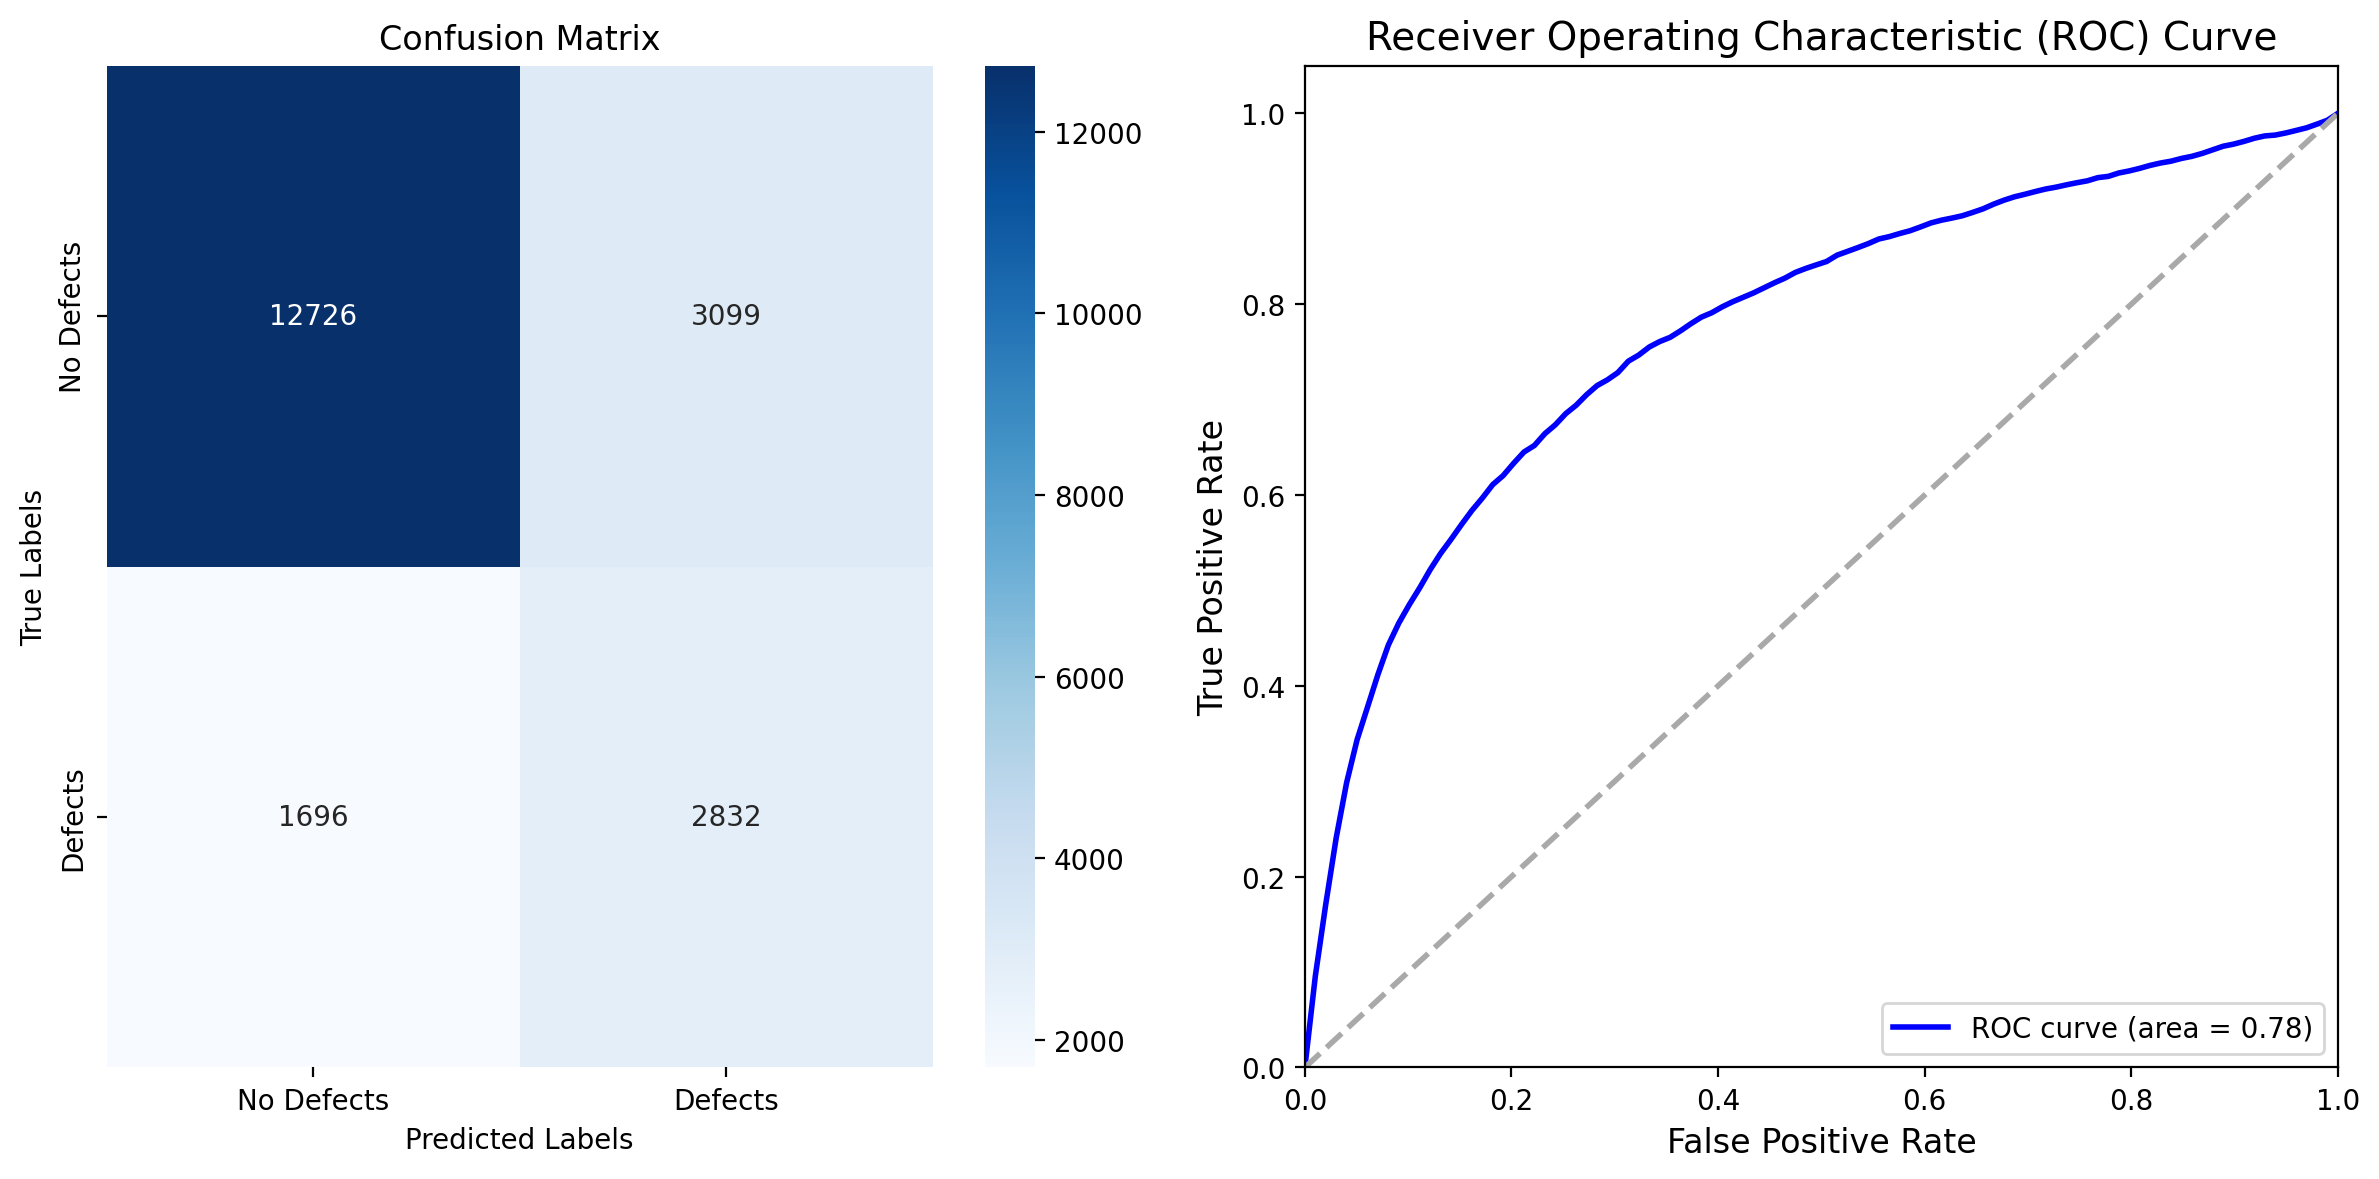

Balanced Test Results: 
              precision    recall  f1-score   support

       False       0.88      0.80      0.84     15825
        True       0.48      0.63      0.54      4528

    accuracy                           0.76     20353
   macro avg       0.68      0.71      0.69     20353
weighted avg       0.79      0.76      0.77     20353

Balanced Test AUC:  0.78


In [ ]:
#@title Refit the Logistic Regression on the Balanced dataset
log_reg_new = LogisticRegression(random_state=seed, max_iter=1000, class_weight='balanced', penalty='elasticnet', solver='saga', C=0.001, l1_ratio=1)
log_reg_new.fit(X_train_scaled, y_train_aug)

# Evaluating the resulting model on the test set
report, auc = evaluate_model(log_reg_new, X_test_scaled, y_test)

print("Balanced Test Results: ")
print(report)
print("Balanced Test AUC: ", auc)

In [ ]:
#@title Refit the Random Forest on the Balanced dataset
rf_new = RandomForestClassifier(random_state=seed, n_estimators=100,
                                min_samples_split=2, min_samples_leaf=5,
                                max_leaf_nodes=100, max_depth=10)
rf_new.fit(X_train_aug, y_train_aug)

# Evaluating the resulting model on the test set
report, auc = evaluate_model(rf_new, X_test, y_test)

print("Balanced Test Results: ")
print(report)
print("Balanced Test AUC: ", auc)

Balanced Test Results: 
              precision    recall  f1-score   support

       False       0.88      0.84      0.86     15825
        True       0.51      0.59      0.54      4528

    accuracy                           0.78     20353
   macro avg       0.69      0.71      0.70     20353
weighted avg       0.79      0.78      0.79     20353

Balanced Test AUC:  0.78


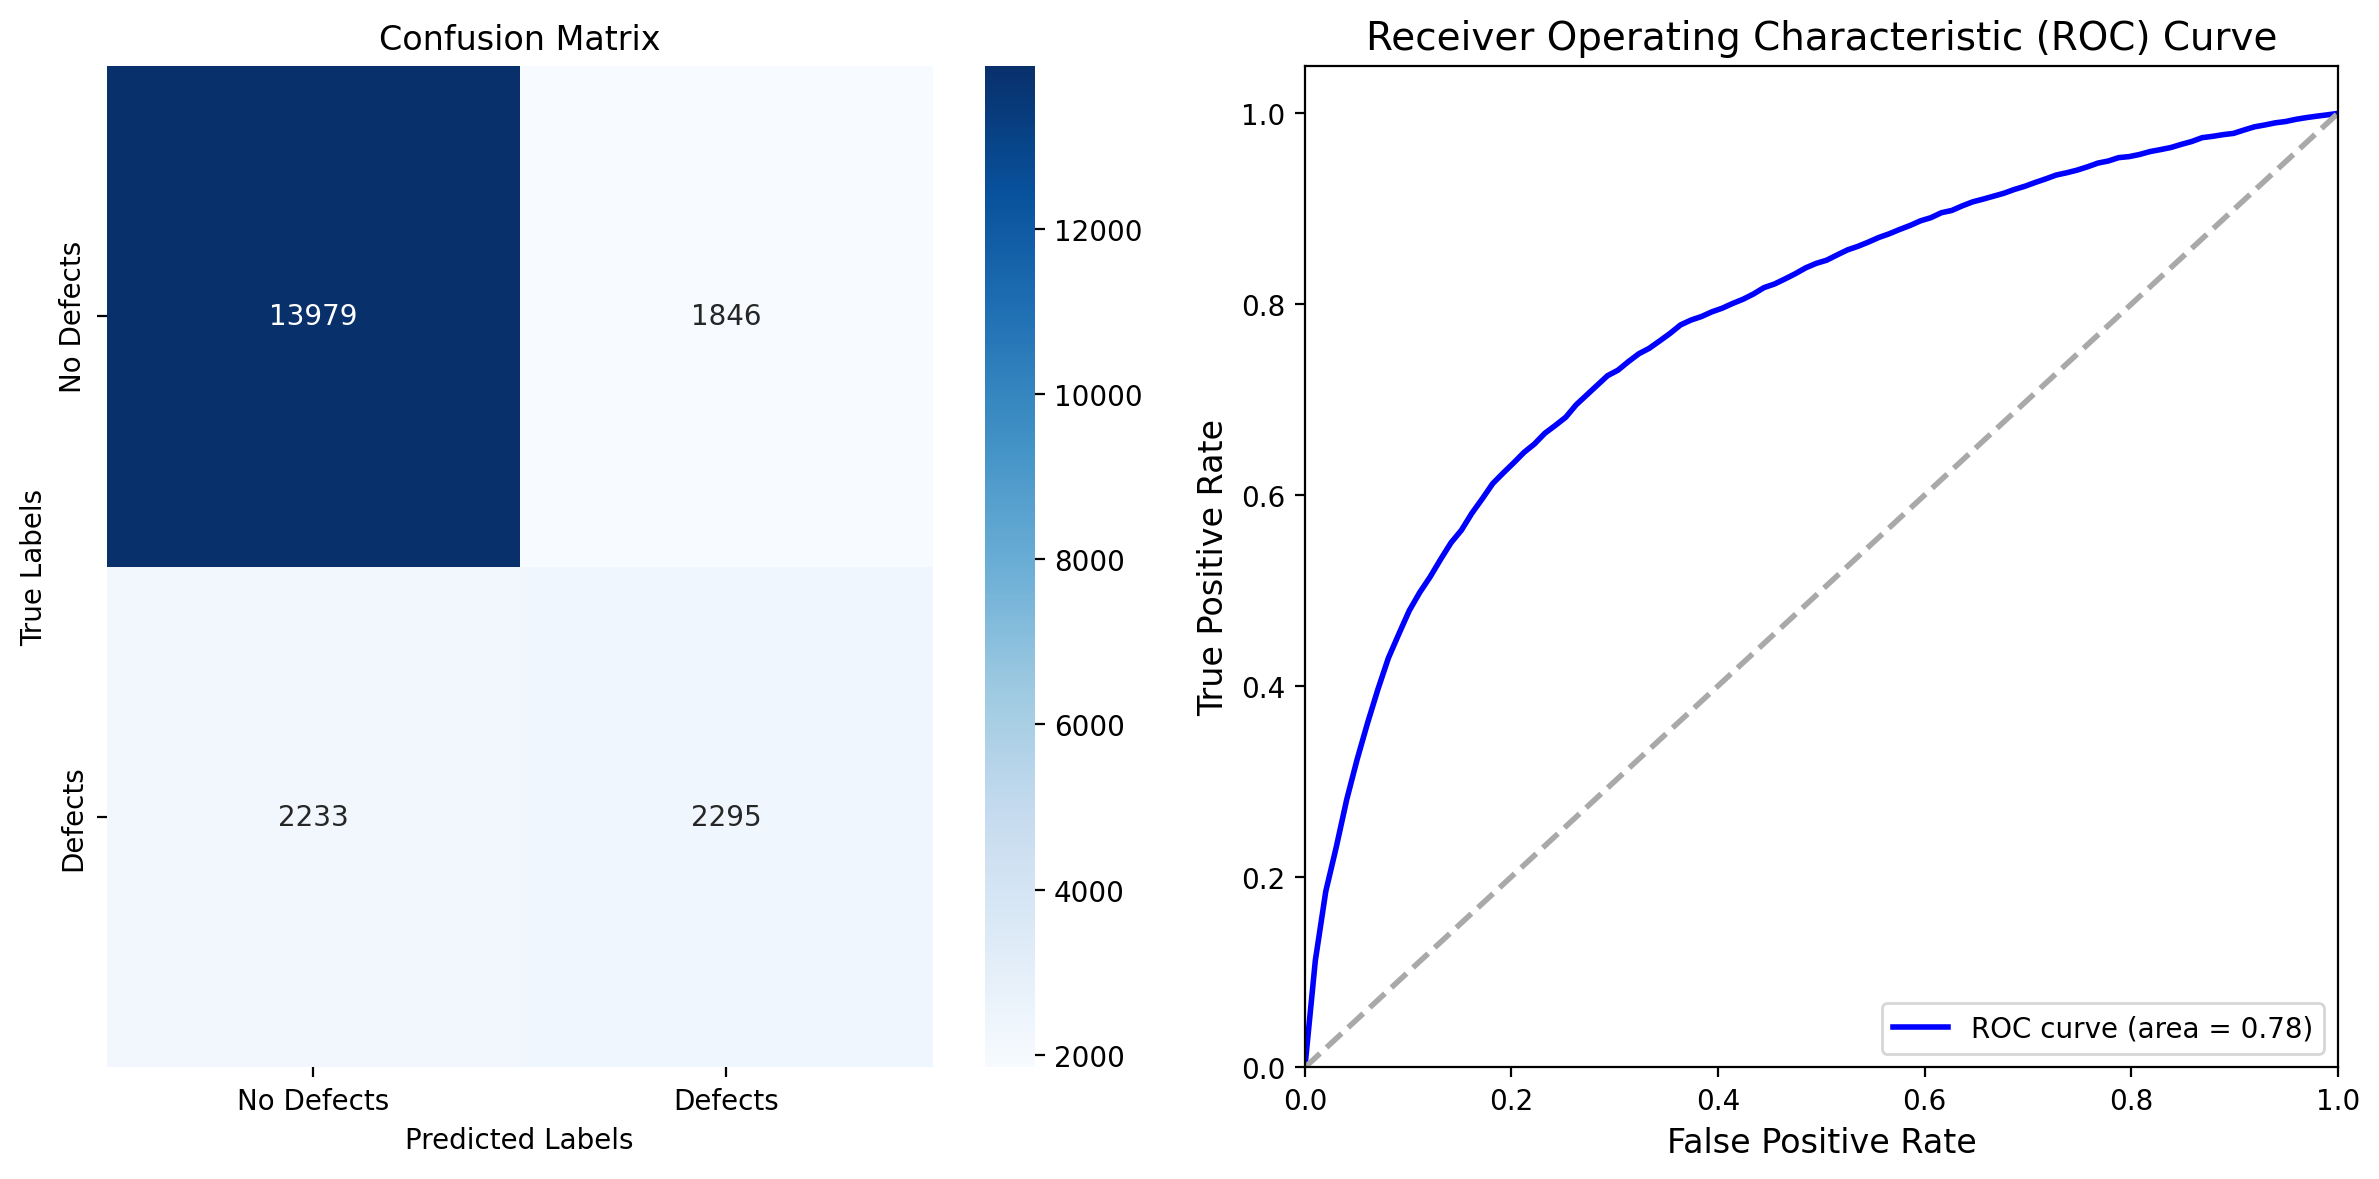

Balanced Test Results: 
              precision    recall  f1-score   support

       False       0.86      0.88      0.87     15825
        True       0.55      0.51      0.53      4528

    accuracy                           0.80     20353
   macro avg       0.71      0.70      0.70     20353
weighted avg       0.79      0.80      0.80     20353

Balanced Test AUC:  0.78


In [ ]:
#@title Refit the Gradient Tree Boosting on the Balanced dataset
gb_new = GradientBoostingClassifier(random_state=seed, n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_depth=3, learning_rate=0.1)
gb_new.fit(X_train_aug, y_train_aug)

# Evaluating the resulting model on the test set
report, auc = evaluate_model(gb_new, X_test, y_test)

print("Balanced Test Results: ")
print(report)
print("Balanced Test AUC: ", auc)

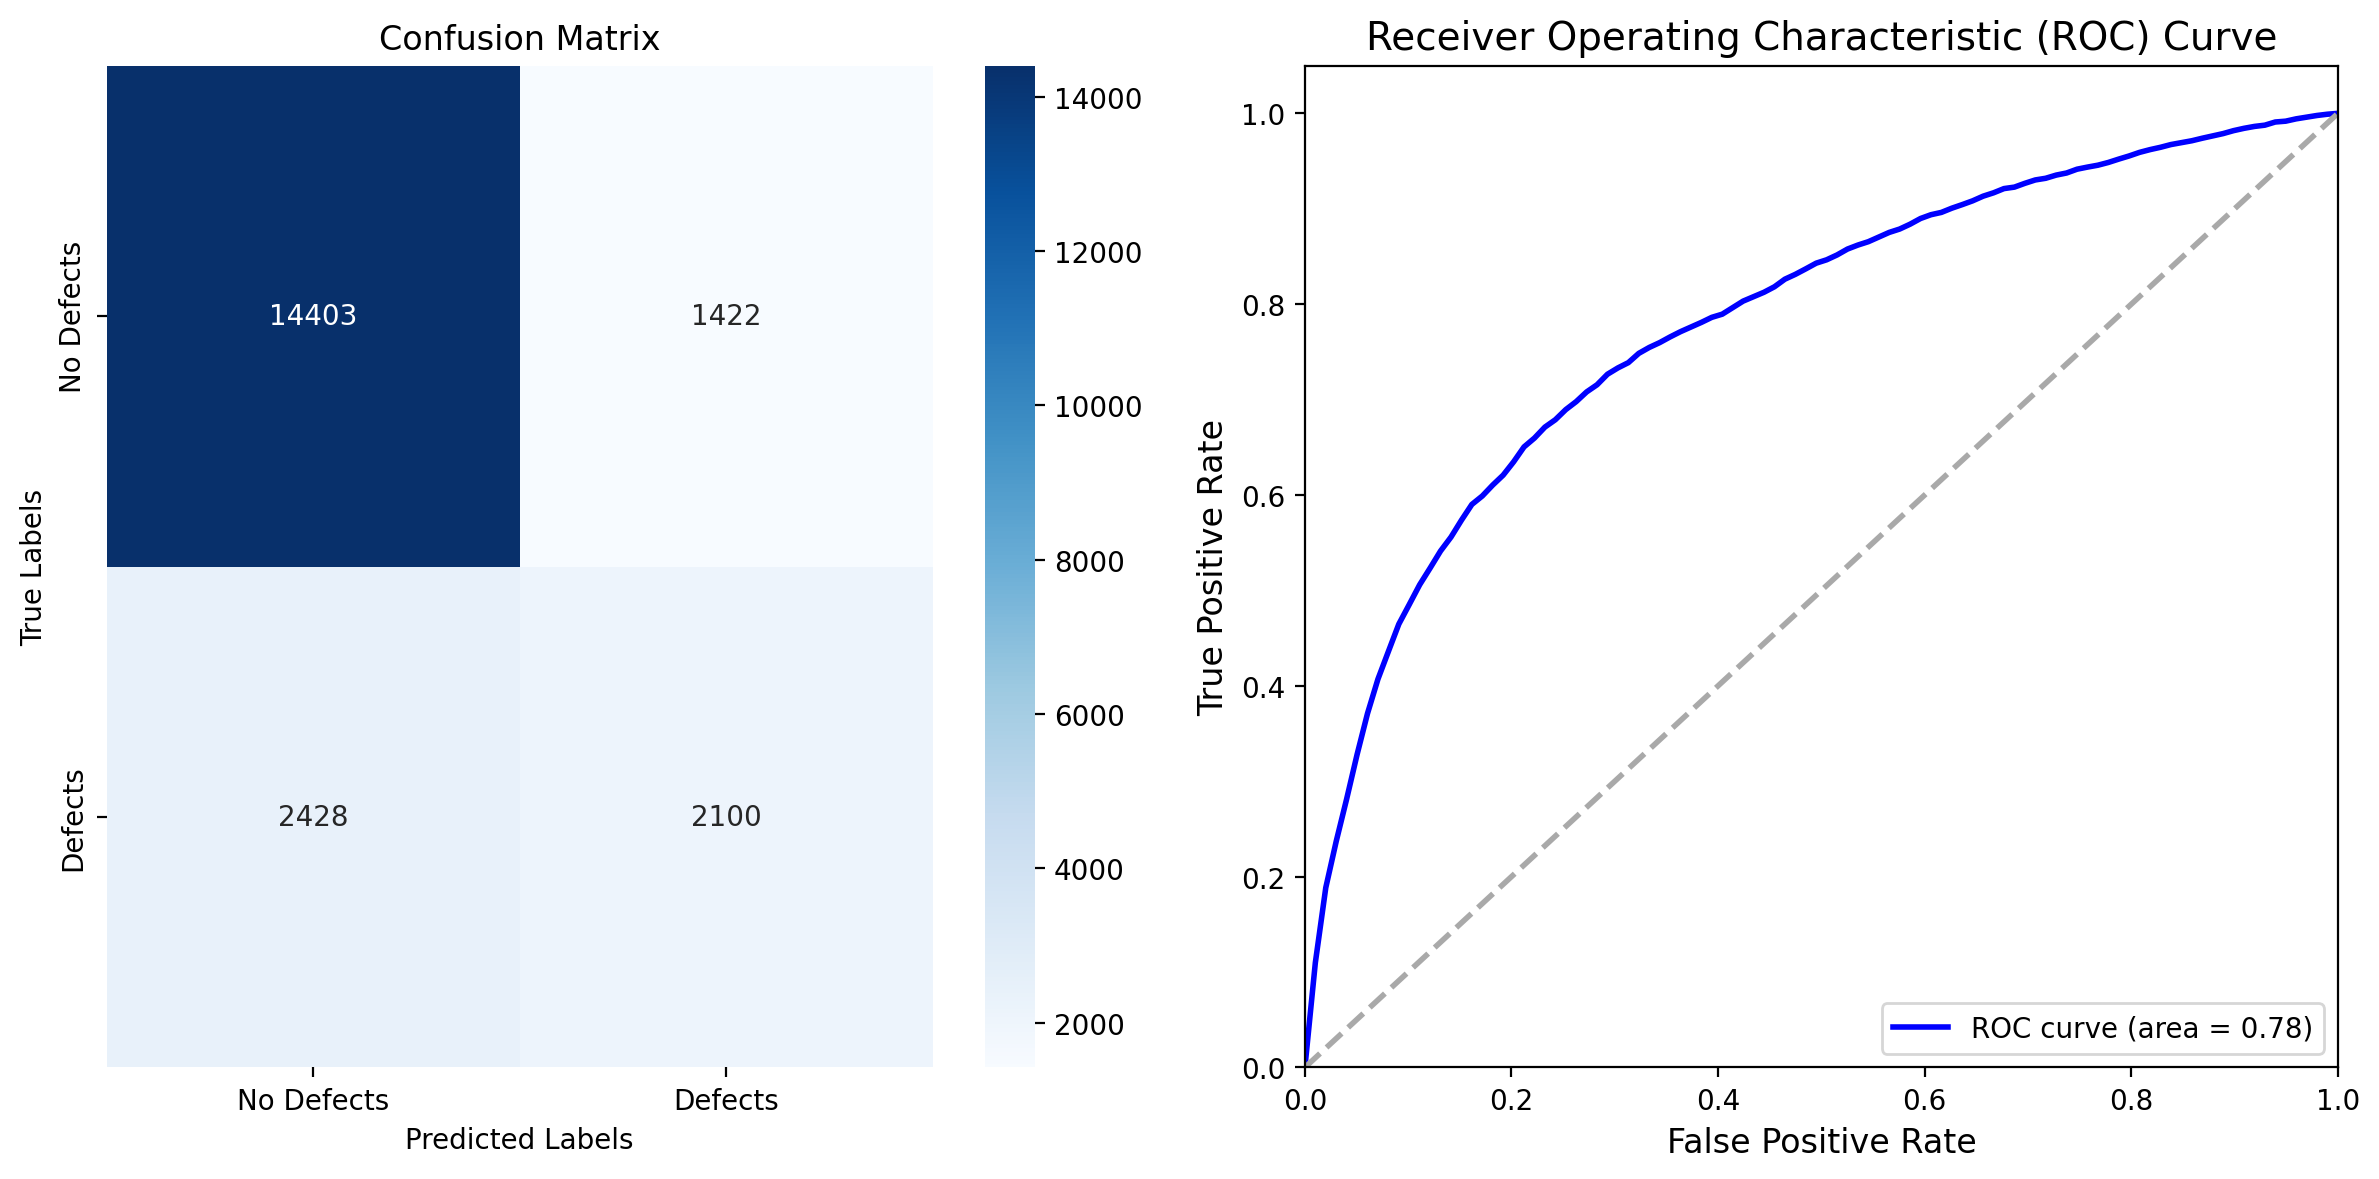

Balanced Test Results: 
              precision    recall  f1-score   support

       False       0.86      0.91      0.88     15825
        True       0.60      0.46      0.52      4528

    accuracy                           0.81     20353
   macro avg       0.73      0.69      0.70     20353
weighted avg       0.80      0.81      0.80     20353

Balanced Test AUC:  0.78


In [ ]:
#@title Refit the XGB Classifier on the Balanced dataset
xgb_new = XGBClassifier(random_state=seed, learning_rate=0.01, max_depth=5, n_estimators=1000)
xgb_new.fit(X_train_aug, y_train_aug)

# Evaluating the resulting model on the test set
report, auc = evaluate_model(xgb_new, X_test, y_test)

print("Balanced Test Results: ")
print(report)
print("Balanced Test AUC: ", auc)

Unfortunately, we did not see many improvements in the Area Under the Curve (AUC) following the application of SMOTE to our models. However, the figure presented here offers an interesting observation. The F1 scores for 'No Defects' remain largely consistent across both Vanilla and SMOTE Data Augmented models, suggesting that our data augmentation techniques did not compromise the model's ability to correctly classify the majority class.

On the other hand, when we look at the 'Defects' class, there is a discernible improvement in the F1 scores after data augmentation across all model types. Although the increase is not dramatic, it indicates that SMOTE has had a positive effect on the model's performance for the minority class. Specifically, the models seem to be better at balancing precision and recall for the 'Defects' class post-augmentation.

This improvement is crucial for applications where the minority class is of greater interest or has a higher cost of misclassification. The F1 score is particularly important in such scenarios because it conveys the harmonic mean of precision and recall, two metrics that are critical in the context of imbalanced classes.

In summary, while our AUC did not show the improvement we hoped for, the data suggests that SMOTE has made our models better at identifying the more critical 'Defects' class without detriment to the 'No Defects' class. This nuanced benefit may not be captured fully by AUC but is clearly demonstrated in the F1 scores for the 'Defects' class, underscoring the value of data augmentation in improving model performance for class imbalance problems.

In [ ]:
#@title Plot the F1-scores for all models with and without SMOTE

import matplotlib.pyplot as plt
import pandas as pd

# Dataset
data = {
    "Model": [
        "Logistic Regression", "Random Forest", "Gradient Tree Boosting", "XGBoost",
        "Logistic Regression (Data Aug)", "Random Forest (Data Aug)",
        "Gradient Tree Boosting (Data Aug)", "XGBoost (Data Aug)"
    ],
    "F1 Score - No Defects": [0.84, 0.89, 0.89, 0.89, 0.84, 0.86, 0.87, 0.88],
    "F1 Score - Defects": [0.54, 0.49, 0.49, 0.49, 0.54, 0.54, 0.53, 0.52]
}

df = pd.DataFrame(data)

# Separating vanilla and data augmented models
vanilla = df.iloc[0:4]
data_aug = df.iloc[4:8]

# Setting up plot parameters
models = df['Model'].unique()[0:4]  # Model names
bar_width = 0.35  # Width of a bar
index = range(len(models))  # Index for bar positions
colors = ['#1f77b4', '#ff7f0e']  # Colors for the bars

# Creating the plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot for 'No Defects'
axes[0].bar(index, vanilla['F1 Score - No Defects'], bar_width, color=colors[0], label='Vanilla')
axes[0].bar([i + bar_width for i in index], data_aug['F1 Score - No Defects'], bar_width, color=colors[1], label='Data Aug')
axes[0].set_title('F1 Score - No Defects')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('F1 Score')
axes[0].set_xticks([i + bar_width/2 for i in index])
axes[0].set_xticklabels(models)
#axes[0].legend()

# Plot for 'Defects'
axes[1].bar(index, vanilla['F1 Score - Defects'], bar_width, color=colors[0], label='Vanilla')
axes[1].bar([i + bar_width for i in index], data_aug['F1 Score - Defects'], bar_width, color=colors[1], label='Data Aug')
axes[1].set_title('F1 Score - Defects')
axes[1].set_xlabel('Model')
axes[1].set_xticks([i + bar_width/2 for i in index])
axes[1].set_xticklabels(models)
axes[1].legend()

# Final adjustments
plt.suptitle('Comparison of F1 Scores on Test Data for Vanilla and Data Augmented Models')
plt.tight_layout()
plt.show()


Based on the above plot, we can see that models perform better on classifying the postive samples on the augmented dataset, while they perform worse on the original dataset. As dataset becomes more balanced, model performance on positive samples tends to improve due to the increased emphasis on the minority class. However, the trade-off is that the models exhibit a decrease in performance on the original dataset, particularly for the majority class. The improved performance on the augmented dataset suggests that the augmentation process has successfully provided the models with additional positive samples, allowing them to better learn the underlying patterns associated with this class. Nevertheless, it's crucial to carefully consider the implications of this trade-off, as the goal is often to build models that generalize effectively to real-world scenarios. (be more sensitive to positive samples, and we did it!!)

----


Now, with this new balanced training dataset, let's now proceed to even deeper model to see what happen!!

# Final Model - Feed-Forward Neural Network

To see if we could perform better on the binary classification task on this dataset, the Feed-Forward Neural Network will be chosen as our final model because of its capability to comprehensively capture intricate patterns within the dataset. Unlike traditional machine learning algorithms, neural networks are adept at learning hierarchical representations of features. Moreover, the non-linear activation functions and hidden layers allows it to learn more complex relationship in the data. We hope that Feed-Forward Neural Network could further improve our performance metrics on this dataset.

In [ ]:
# Define the Dataset class
class SoftwareDefectDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.to_numpy(), dtype=torch.float32)
        self.y = torch.tensor(y.to_numpy(), dtype=torch.int64)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Instantiate the Dataset class
train_dataset = SoftwareDefectDataset(X_train_aug, y_train_aug)
val_dataset = SoftwareDefectDataset(X_val, y_val)
test_dataset = SoftwareDefectDataset(X_test, y_test)

# Define the DataLoader class
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
# Define the Neural Network class
class SoftwareDefectClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SoftwareDefectClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, output_dim)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.relu(self.fc5(x))
        x = self.dropout(x)
        x = self.fc6(x)
        return x

In [ ]:
# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Define the training function
def train(data_loader, model, optimizer, device):
    model.train()
    total_loss = 0
    for data in data_loader:
        X, y = data
        X = X.to(device, dtype=torch.float32)
        y = y.to(device, dtype=torch.int64)

        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)

# Define the evaluation function
def evaluate(data_loader, model, device):
    model.eval()
    y_pred_list = []
    y_true_list = []
    with torch.no_grad():
        for data in data_loader:
            X, y = data
            X = X.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.int64)
            y_pred = model(X)
            y_pred_list.extend(y_pred.cpu().numpy().tolist())
            y_true_list.extend(y.cpu().numpy().tolist())
    return y_pred_list, y_true_list


# Create the model instance
model = SoftwareDefectClassifier(X_train_aug.shape[1], 1)

# Move the model to the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the number of epochs
epochs = 50

# Define the early stopping parameters
patience = 10
counter = 0
best_loss = np.inf
train_losses = []
val_losses = []

# Define the training loop
for epoch in range(epochs):
    train_loss = train(train_loader, model, optimizer, device)
    y_pred_list, y_true_list = evaluate(val_loader, model, device)
    y_true_tensor = torch.tensor(y_true_list).float().view(-1, 1)
    val_loss = criterion(torch.tensor(y_pred_list), y_true_tensor)
    y_pred_list = np.array(y_pred_list) >= 0.5
    precision = classification_report(y_true_list, y_pred_list, output_dict=True)['weighted avg']['precision']
    recall = classification_report(y_true_list, y_pred_list, output_dict=True)['weighted avg']['recall']
    f1 = classification_report(y_true_list, y_pred_list, output_dict=True)['weighted avg']['f1-score']
    print(f"Epoch: {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    train_losses.append(train_loss)
    val_losses.append(val_loss.item())

    if val_loss < best_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        best_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            break

cuda
Epoch: 1, Training Loss: 1.1193, Validation Loss: 0.6186, Precision: 0.7645, Recall: 0.7906, F1: 0.7394
Epoch: 2, Training Loss: 0.6577, Validation Loss: 0.6049, Precision: 0.7697, Recall: 0.7938, F1: 0.7468
Epoch: 3, Training Loss: 0.6484, Validation Loss: 0.6081, Precision: 0.7758, Recall: 0.7997, F1: 0.7688
Epoch: 4, Training Loss: 0.6407, Validation Loss: 0.6002, Precision: 0.7499, Recall: 0.7841, F1: 0.7287
Epoch: 5, Training Loss: 0.6249, Validation Loss: 0.6022, Precision: 0.7861, Recall: 0.7709, F1: 0.7772
Epoch: 6, Training Loss: 0.6195, Validation Loss: 0.5874, Precision: 0.7860, Recall: 0.7634, F1: 0.7722
Epoch: 7, Training Loss: 0.6094, Validation Loss: 0.5958, Precision: 0.7877, Recall: 0.7904, F1: 0.7890
Epoch: 8, Training Loss: 0.6045, Validation Loss: 0.5915, Precision: 0.7876, Recall: 0.7857, F1: 0.7866
Epoch: 9, Training Loss: 0.6142, Validation Loss: 0.5910, Precision: 0.7859, Recall: 0.7868, F1: 0.7863
Epoch: 10, Training Loss: 0.6023, Validation Loss: 0.5377, 

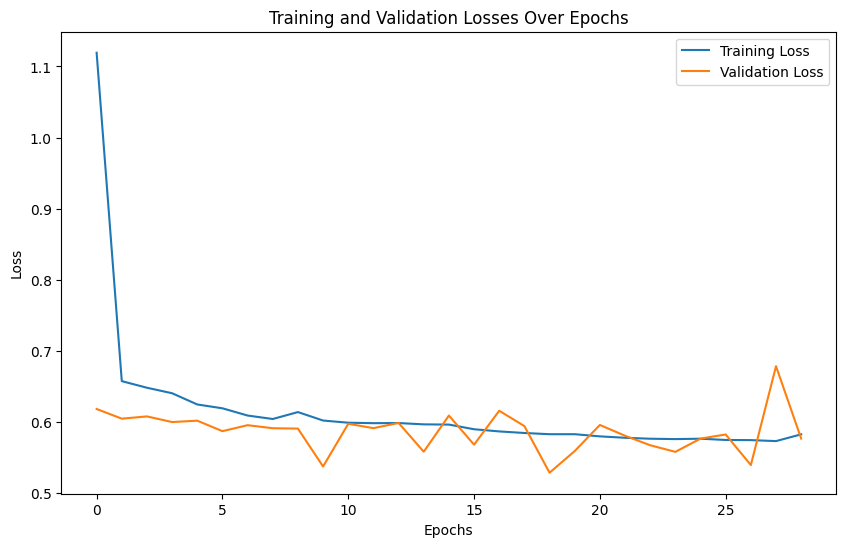

In [ ]:
#@title Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In analyzing our training plot, we observe that the training loss exhibited a significant decrease from the initial epoch, which suggests that our model started learning quite effectively from the training dataset right away. As the epochs progressed, our training loss continued to demonstrate a general declining trend with some expected fluctuations, indicative of the ongoing optimization process of the model's parameters.

Parallel to the training loss, our validation loss also began at a higher value, yet it quickly aligned with the downward trend of the training loss. This alignment is encouraging as it implies that our model is generalizing well and not just memorizing the training data, which would be indicated by a diverging validation loss.

However, it's noteworthy that towards the end of the training epochs, we encountered a spike in the validation loss. This sudden increase could potentially signal the onset of overfitting, or it may reflect an anomaly due to the variability inherent in the validation dataset. This spike merits further investigation to ascertain its cause and to determine if it's a recurring pattern that needs to be addressed with adjustments to our model, such as tuning the learning rate or implementing early stopping.

tensor(0.5332)
Test Results: 
              precision    recall  f1-score   support

           0       0.86      0.88      0.87     15825
           1       0.55      0.50      0.52      4528

    accuracy                           0.80     20353
   macro avg       0.70      0.69      0.70     20353
weighted avg       0.79      0.80      0.79     20353

Test AUC:  0.6905527621009384


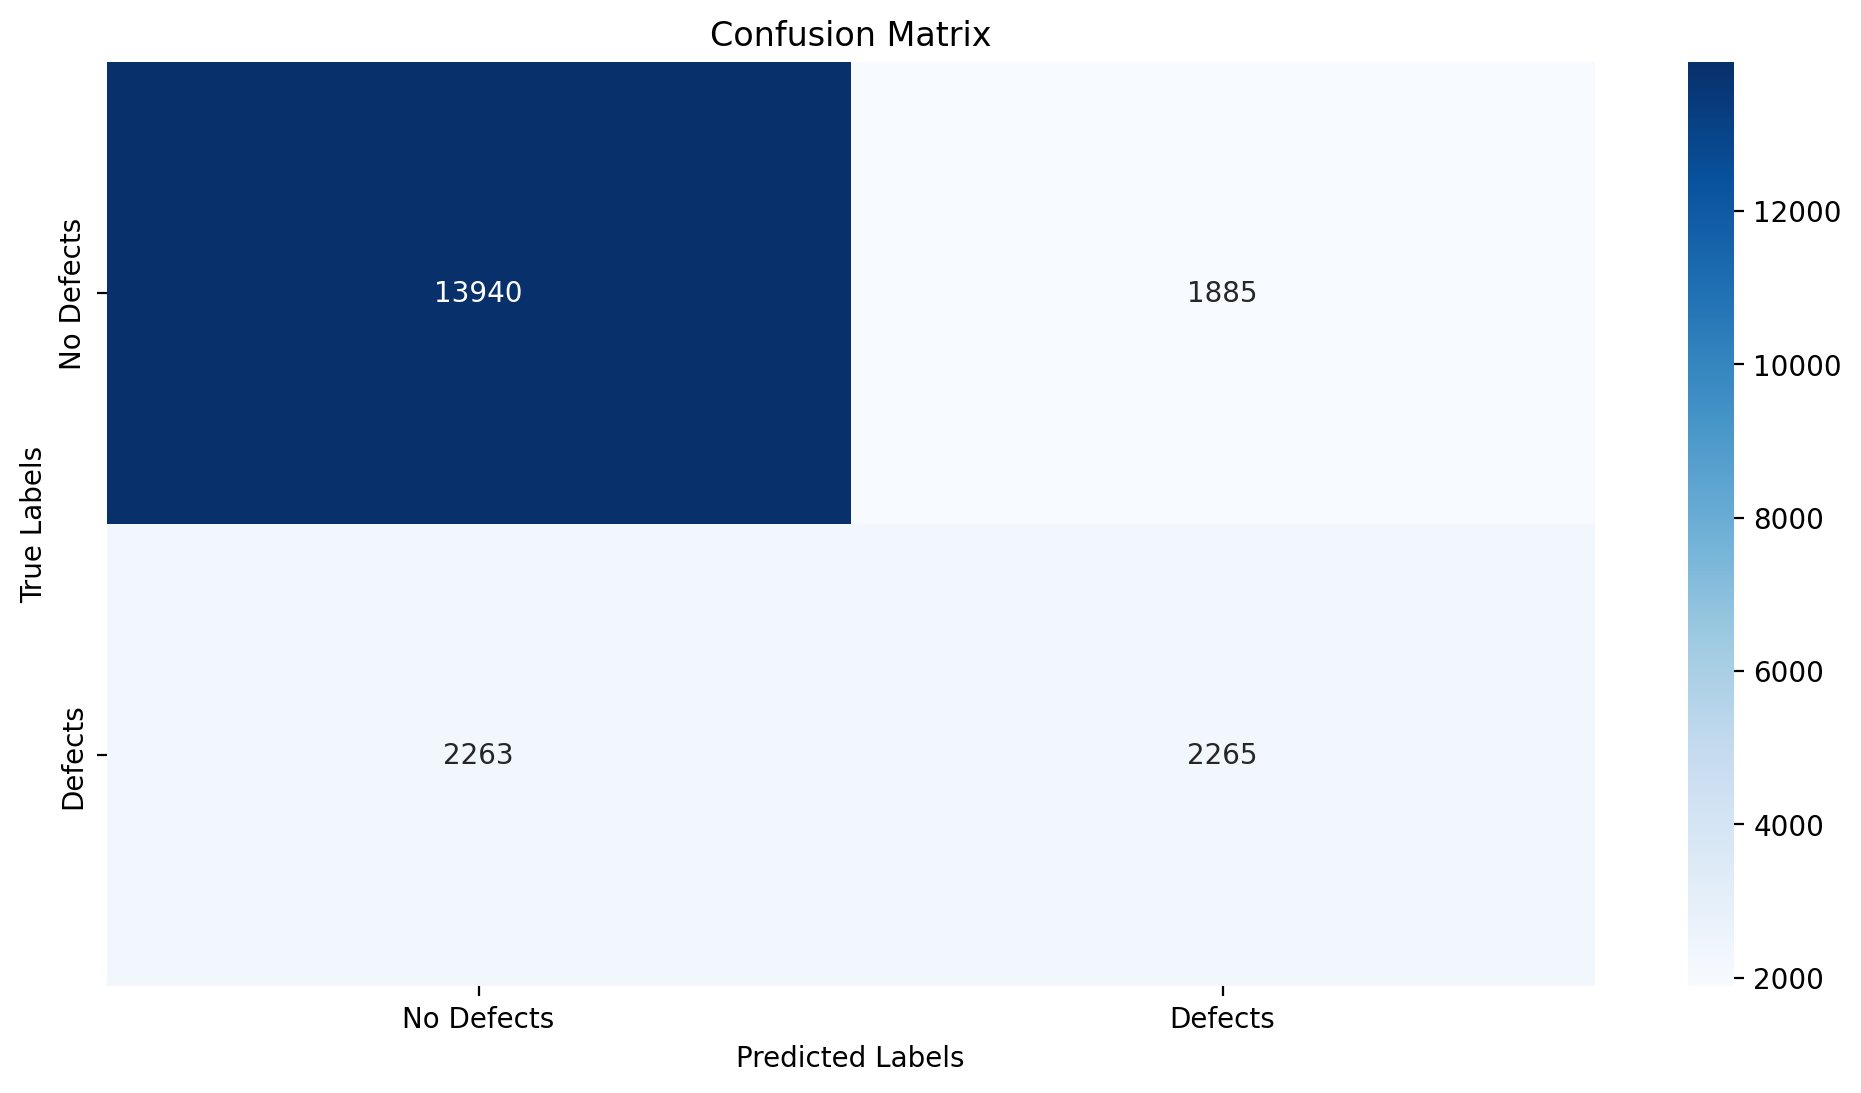

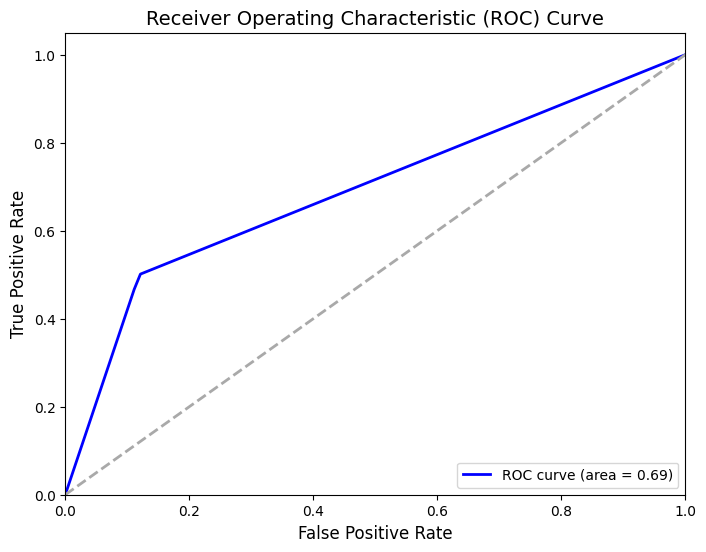

In [ ]:
#@title Evaluate the model on the test dataset
# Load the best model
model.load_state_dict(torch.load('best_model.pt'))

y_pred_list, y_true_list = evaluate(test_loader, model, device)
y_true_tensor = torch.tensor(y_true_list).float().view(-1, 1)
val_loss = criterion(torch.tensor(y_pred_list), y_true_tensor)
print(val_loss)
y_pred_list = np.array(y_pred_list) >= 0.5
report = classification_report(y_true_list, y_pred_list)
auc = roc_auc_score(y_true_list, y_pred_list)
print("Test Results: ")
print(report)
print("Test AUC: ", auc)

# Plot the confusion matrix
cm = confusion_matrix(y_true_list, y_pred_list)
plt.figure(figsize=(12, 6), dpi=200)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['No Defects', 'Defects'], yticklabels=['No Defects', 'Defects'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Plot the ROC Curve
fpr, tpr, _ = roc_curve(y_true_list, y_pred_list)
smooth_fpr = np.linspace(0, 1, 100)
smooth_tpr = np.interp(smooth_fpr, fpr, tpr)
smooth_roc_auc = roc_auc_score(y_true_list, y_pred_list)

plt.figure(figsize=(8, 6))
plt.plot(smooth_fpr, smooth_tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % smooth_roc_auc)
plt.plot([0, 1], [0, 1], color='darkgray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc="lower right")
plt.show()

To effectively compare our custom model against previous iterations, we've created a figure to measure AUC, Macro F1, Weighted F1, and Accuracy. This will allow us to quickly discern improvements or areas needing attention in our model's performance.

# Plot All Models' Performance Metrics

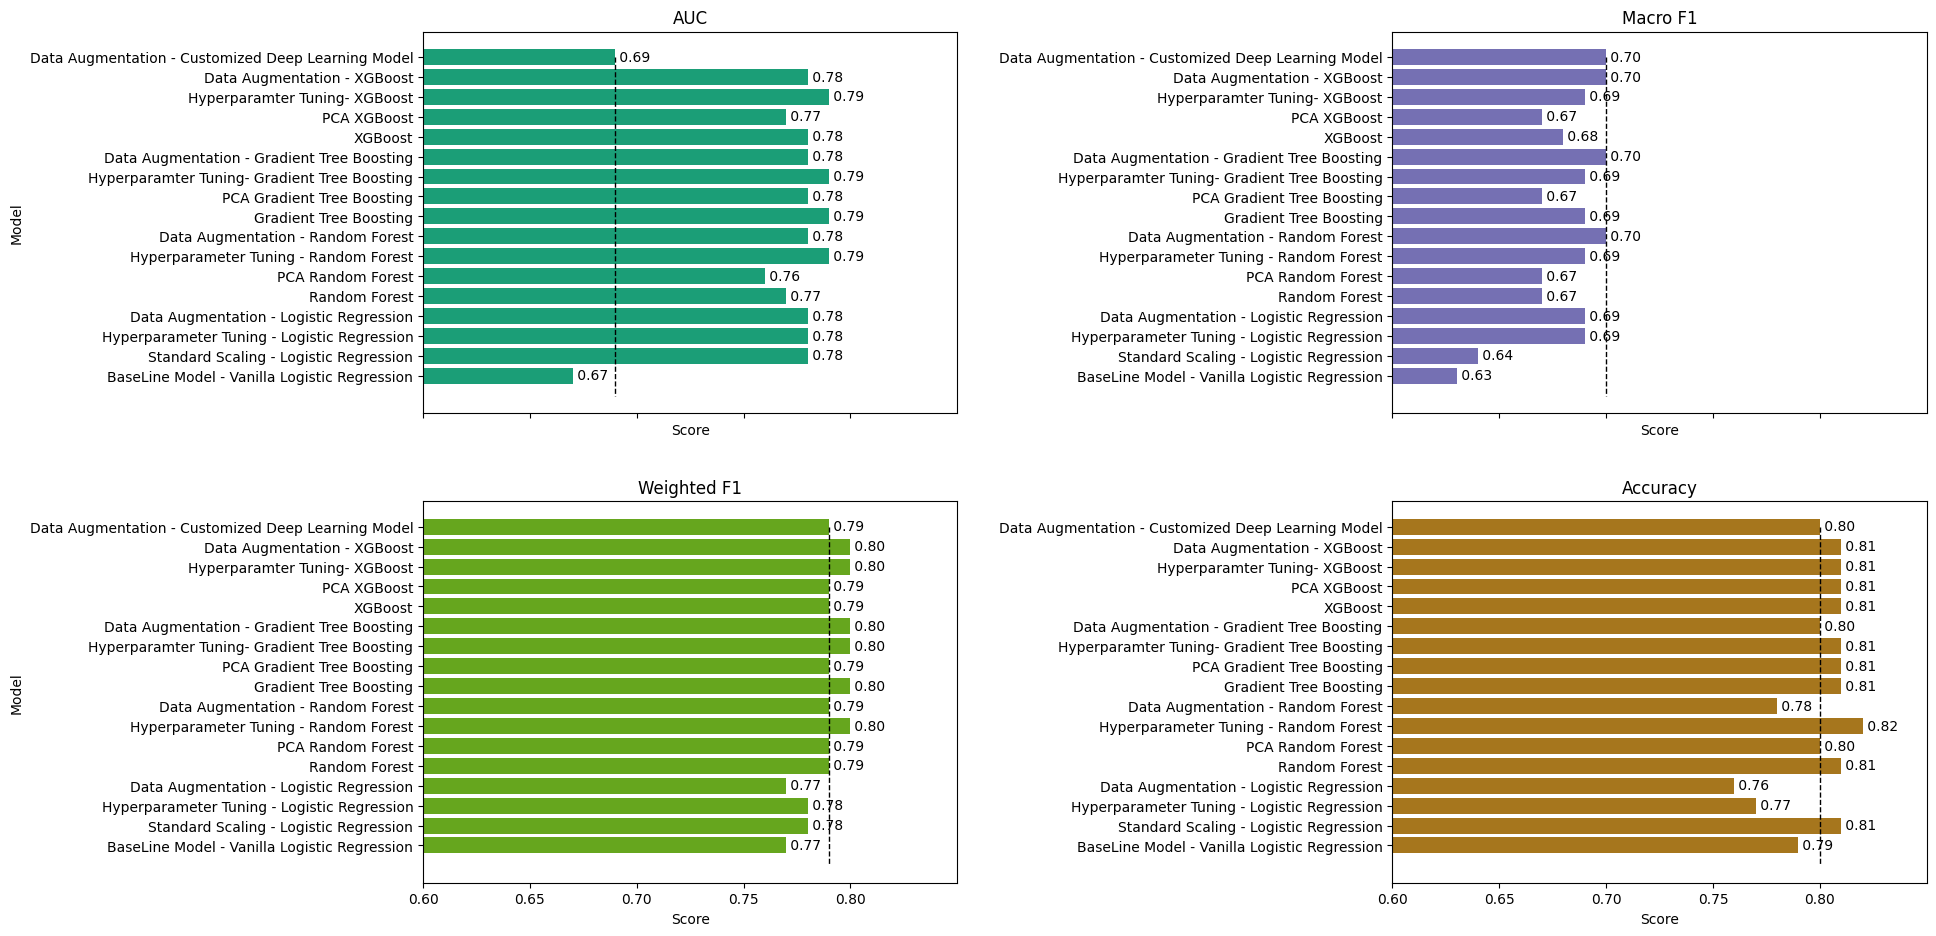

In [ ]:
# Data from the user's table
data = {
    'Model': [
        'BaseLine Model - Vanilla Logistic Regression',
        'Standard Scaling - Logistic Regression',
        'Hyperparameter Tuning - Logistic Regression',
        'Data Augmentation - Logistic Regression',
        'Random Forest',
        'PCA Random Forest',
        'Hyperparameter Tuning - Random Forest',
        'Data Augmentation - Random Forest',
        'Gradient Tree Boosting',
        'PCA Gradient Tree Boosting',
        'Hyperparamter Tuning- Gradient Tree Boosting',
        'Data Augmentation - Gradient Tree Boosting',
        'XGBoost',
        'PCA XGBoost',
        'Hyperparamter Tuning- XGBoost',
        'Data Augmentation - XGBoost',
        'Data Augmentation - Customized Deep Learning Model'
    ],
    'AUC': [
        0.67, 0.78, 0.78, 0.78, 0.77, 0.76, 0.79, 0.78,
        0.79, 0.78, 0.79, 0.78, 0.78, 0.77, 0.79, 0.78, 0.69
    ],
    'Macro F1': [
        0.63, 0.64, 0.69, 0.69, 0.67, 0.67, 0.69, 0.7,
        0.69, 0.67, 0.69, 0.7, 0.68, 0.67, 0.69, 0.7, 0.7
    ],
    'Weighted F1': [
        0.77, 0.78, 0.78, 0.77, 0.79, 0.79, 0.8, 0.79,
        0.8, 0.79, 0.8, 0.8, 0.79, 0.79, 0.8, 0.8, 0.79
    ],
    'Accuracy': [
        0.79, 0.81, 0.77, 0.76, 0.81, 0.8, 0.82, 0.78,
        0.81, 0.81, 0.81, 0.8, 0.81, 0.81, 0.81, 0.81, 0.8
    ]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Plotting
fig, ax = plt.subplots(2, 2, figsize=(20, 10), sharex=True)

# Flatten the axes array for easy iterating
ax = ax.flatten()

# Loop through the metrics and create a bar plot for each
for i, metric in enumerate(titles):
    bars = ax[i].barh(df['Model'], df[metric], color=plt.cm.Dark2(i / 4))
    ax[i].set_title(metric)
    ax[i].set_xlim(0.65, 0.85)  # Set the same x-axis limits for comparison
    ax[i].set_xlabel('Score')

    # Draw a line from the deep learning model bar to the bottom
    # Find the index of the deep learning model
    dl_index = df.index[df['Model'] == 'Data Augmentation - Customized Deep Learning Model'].tolist()[0]
    dl_score = df.loc[dl_index, metric]

    # Draw a line
    ax[i].plot([dl_score, dl_score], [dl_index, -1], 'k--', lw=1)

    # Annotate the scores on the bars
    for index, bar in enumerate(bars):
        width = bar.get_width()
        ax[i].text(width, index, f' {width:.2f}', va='center')

# Set the y-axis labels only on the leftmost subplot
ax[0].set_ylabel('Model')
ax[2].set_ylabel('Model')

# Set the y-ticks to be the model names
plt.yticks(range(len(df['Model'])), df['Model'])
plt.xticks(np.arange(0.60, 0.85, 0.05))

# Add some spacing between the subplots
plt.tight_layout(pad=3.0)

# Show the plot
plt.show()

The comparison of our models suggests that while our deep learning model presents competitive F1 and Accuracy scores, its AUC lags behind traditional machine learning models. This discrepancy implies that the deep learning model may struggle with effectively ranking predictions at varying thresholds. Despite data augmentation improving the Macro F1 score, it does not have a corresponding positive impact on AUC. Traditional models, especially when fine-tuned, seem to offer a more consistent performance across the board.

In examining the confusion matrix, we observe that the neural network has an edge over logistic regression in predicting positive cases but falls short in identifying negative cases. Additionally, it doesn't surpass tree-based algorithms for either class prediction. Several factors could contribute to this situation. The neural network's architecture, capable of capturing complex patterns, might be too sophisticated for our dataset, leading to a scenario where simpler models perform better due to better generalization. Also, the performance of neural networks is highly sensitive to hyperparameter settings. An optimal configuration of layers, nodes, learning rates, and other parameters is crucial. The current setup might not be ideal, and further tuning could potentially unlock better performance from the neural network.

# Conclusion

Upon evaluating various models using a dataset geared towards predicting defects in C programs, we conclude that traditional machine learning models with hyperparameter tuning and PCA show superior performance in key metrics. Despite the advanced capabilities of our custom deep learning model, it has not achieved a leading position, especially in the AUC metric, which is crucial for predicting defect presence with high confidence—a feature vital for the intended use in Integrated Development Environments (IDEs).

**Findings/Insights**
- Our analysis yielded the insight that data augmentation positively influences the Macro F1 score, implying improved recall and precision balance among classes. However, this does not extend to AUC, suggesting that while the model's predictive accuracy on seen data improves, its ability to generalize and confidently rank predictions across unseen data requires enhancement. For an IDE tool designed to aid developers, it is critical that the model not only identifies defects accurately but also ranks these predictions reliably to prioritize developer attention effectively.

**Challenges/Obstacles**
- A significant challenge we face is the underwhelming AUC of the deep learning model, given that the IDE tool we aim to create must reliably rank each prediction's likelihood of being a defect. The synthetic nature of our dataset, which is derived from a model trained on data from 2004, might not capture the full complexity or feature set necessary for a deep learning model to excel. Additionally, the potential non-linear and high-dimensional patterns characteristic of software defects might not be fully realized by the model in its current form.

**Future Works/Next Steps**
- Moving forward, we will delve deeper into the neural network's structure, experimenting with various configurations and learning strategies to capture the intricate relationships within our dataset. We aim to enrich the model's learning context, potentially by incorporating additional real-world data or by synthesizing more complex features that could highlight the subtleties of defective versus non-defective code.

- Furthermore, we intend to explore advanced data augmentation techniques that may better simulate the real-world variance in software defects. Cost-sensitive learning and other imbalance-targeting strategies will be evaluated to enhance the model's performance on minority classes, which are often the most critical to detect in a defect prediction context.

## ***The End! Thanks for following through our project! Hope you find this clear and insightful!***